<a href="https://colab.research.google.com/github/sharathc21/ML/blob/main/CNN/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, ZeroPadding2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.backend import set_session

from keras.utils import np_utils
from keras.datasets import mnist

In [2]:
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()


11490434/11490434 [==============================] - 2s 0us/step


In [3]:
# Library for Transfer Learning
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [4]:
# Libraries for TensorFlow
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image

In [5]:
# Verifying dataset

print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)
print(ytrain)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
[5 0 4 ... 5 6 8]


In [6]:
# Convert the images into 3 channels as MNIST images are Black and White so have 1 channel

xtrain=np.dstack([xtrain] * 3)
xtest=np.dstack([xtest]*3)
xtrain.shape,xtest.shape

((60000, 28, 84), (10000, 28, 84))

In [7]:
# Reshape images as per the tensor format required by tensorflow

xtrain = xtrain.reshape(-1, 28,28,3)
xtest= xtest.reshape (-1,28,28,3)
xtrain.shape,xtest.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [8]:
# Resize the images 48*48 as required by VGG16

# from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import img_to_array, array_to_img

xtrain = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in xtrain])
xtest = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in xtest])
#train_x = preprocess_input(x)
xtrain.shape, xtest.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [9]:
# Verifying the output

# Training Dataset
print("Training Dataset")

x=np.array(xtrain) # Converting to np arrary to pass to the model
print(x.shape)

y=to_categorical(ytrain) # onehot encoding of the labels
# print(y)
print(y.shape)

# Test Dataset
print("Test Dataset")

test_images=np.array(xtest) 
print(test_images.shape)

test_image_label=to_categorical(ytest) # onehot encoding of the labels)
print(test_image_label.shape)

# Validation Dataset
print("Validation Dataset")

val_images=np.array(xtest) 
print(val_images.shape)

val_image_label=to_categorical(ytest) # onehot encoding of the labels)
print(val_image_label.shape)


Training Dataset
(60000, 48, 48, 3)
(60000, 10)
Test Dataset
(10000, 48, 48, 3)
(10000, 10)
Validation Dataset
(10000, 48, 48, 3)
(10000, 10)


In [10]:
# Check properties of the model that we are going to use for Transfer Learning

print("Summary of default VGG16 model.\n")

# we are using VGG16 for transfer learnin here. So we have imported it
from tensorflow.keras.applications import VGG16


# initializing model with weights='imagenet'i.e. we are carring its original weights
model_vgg16=VGG16(weights='imagenet')

# display the summary to see the properties of the model
model_vgg16.summary()

Summary of default VGG16 model.

553467096/553467096 [==============================] - 25s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                          

Observations:
We want to carry weights as it was in original model, so we are carring weights = 'imagenet'
The very first layer is input layer which accept image size = (224, 224, 3). Our image size are different, so we need to change the parameter - image_size in the first layer. Our size will be: (224,224, 3)
We want to change the last layer as we have 10 class classificatoin problem. So, we will not include top layer
Also, we will not train all the layers except the last one as we will have to train that. So, we will set properties for trainable = False excet for the top i.e. last layer.


In [11]:
from tensorflow.keras import models, layers

In [12]:
# Modelling WITH Transfer Learning

# Here we will prepare model as per our requirements

print("Summary of Custom VGG16 model.\n")
print("1) We setup input layer and 2) We removed top (last) layer. \n")

# let us prepare our input_layer to pass our image size. default is (224,224,3). we will change it to (224,224,3)
input_layer=layers.Input(shape=(48,48,3))

# initialize the transfer model VGG16 with appropriate properties per our need.
# we are passing paramers as following
# 1) weights='imagenet' - Using this we are carring weights as of original weights.
# 2) input_tensor to pass the VGG16 using input_tensor
# 3) we want to change the last layer so we are not including top layer
model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)

# See the summary of the model with our properties.
model_vgg16.summary()

Summary of Custom VGG16 model.

1) We setup input layer and 2) We removed top (last) layer. 

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None

Observation:

The first layer is having image size = (224,224,3) now as we defined.
Also, see the folloiwng 2 top (last) layers which were there in original VGG16 are now not the part of our customized layer because we set include_top=False:
block5_pool (MaxPooling2D) (None, 7, 7, 512) 0

block5_pool (MaxPooling2D) (None, 7, 7, 512) 0

flatten (Flatten) (None, 25088) 0

fc1 (Dense) (None, 4096) 102764544

fc2 (Dense) (None, 4096) 16781312

predictions (Dense) (None, 1000) 4097000


In [13]:
print("Summary of Custom VGG16 model.\n")
print("1) We flatten the last layer and added 1 Dense layer and 1 output layer.\n")

last_layer=model_vgg16.output # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer) 

# Add dense layer
dense1=layers.Dense(100,activation='relu')(flatten)
dense1=layers.Dense(100,activation='relu')(flatten)
dense1=layers.Dense(100,activation='relu')(flatten)


# Add dense layer to the final output layer
output_layer=layers.Dense(10,activation='softmax')(flatten)

# Creating modle with input and output layer
model=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
model.summary()

Summary of Custom VGG16 model.

1) We flatten the last layer and added 1 Dense layer and 1 output layer.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                     

In [14]:
# we will freez all the layers except the last layer

# we are making all the layers intrainable except the last layer
print("We are making all the layers intrainable except the last layer. \n")
for layer in model.layers[:-1]:
    layer.trainable=False
model.summary()

We are making all the layers intrainable except the last layer. 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                             

In [15]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=5)
# print(xtrain)
# print(xtest)
# print(ytrain)
# print(ytest)

print("Splitting data for train and test completed.")

Splitting data for train and test completed.


In [16]:
#  Compiling Model

model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])

print("Model compilation completed.")
model.summary()

Model compilation completed.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (No

In [17]:
# Fit the Model

# xtrain2=xtrain.reshape(60000,48,48,3)
# xtest2=xtest.reshape(10000,48,48,3)

history = model.fit(xtrain,ytrain,epochs=20,batch_size=128,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")

Epoch 1/20
375/375 [==============================] - 25s 46ms/step - loss: 2.0649 - accuracy: 0.7216 - val_loss: 0.5743 - val_accuracy: 0.8658
Epoch 2/20
375/375 [==============================] - 18s 49ms/step - loss: 0.4597 - accuracy: 0.8832 - val_loss: 0.3723 - val_accuracy: 0.8999
Epoch 3/20
375/375 [==============================] - 17s 45ms/step - loss: 0.3355 - accuracy: 0.9058 - val_loss: 0.3183 - val_accuracy: 0.9082
Epoch 4/20
375/375 [==============================] - 17s 46ms/step - loss: 0.2864 - accuracy: 0.9148 - val_loss: 0.3042 - val_accuracy: 0.9086
Epoch 5/20
375/375 [==============================] - 17s 46ms/step - loss: 0.2659 - accuracy: 0.9184 - val_loss: 0.2861 - val_accuracy: 0.9152
Epoch 6/20
375/375 [==============================] - 17s 45ms/step - loss: 0.2488 - accuracy: 0.9243 - val_loss: 0.2683 - val_accuracy: 0.9216
Epoch 7/20
375/375 [==============================] - 17s 45ms/step - loss: 0.2413 - accuracy: 0.9258 - val_loss: 0.2565 - val_accuracy:

In [18]:

# This function helps to predict individual image supplied to it

# Function 1

def predict(img_name):
    img=image.load_img(img_name,target_size=(48,48))
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img=preprocess_input(img)

    prediction=model.predict(img.reshape(1,48,48,3))
    output=np.argmax(prediction)

    print(class_names[output] + ": " + Get_Element_Name(class_names[output]))

    
# Function 2

# This function plots the image supplied in array
def plot_image(i, predictions_array, true_label, img): # taking index and 3 arrays viz. prediction array, true label array and image array
    
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img.astype('int32'))
    
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

    if predicted_label == true_label: #setting up label color
        color='green' # correct then blue colour
    else:
        color='red' # wrong then red colour
    
    plt.xlabel("{} {:2.0f}% \n ({})".format(Get_Element_Name(predicted_label), 
                                            100*np.max(predictions_array), Get_Element_Name(true_label), 
                                            color=color, horizontalalignment='left'))
        
        
#     plt.xlabel("{} {:2.0f}% ({})".format(val_class_names[predicted_label], 
#                                          100*np.max(predictions_array), val_class_names[true_label]), 
#                                          color=color)


# Function 3

# This function plots bar chart supplied in the array data
def plot_value_array(i, predictions_array, true_label): # taking index along with predictions and true label array
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

    if predicted_label == 0:
        predicted_label=1
    if true_label == 0:
        true_label=1
    
    thisplot=plt.bar(range(10), predicted_label, color='seashell')
    plt.ylim([0,1])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

In [20]:
# Preparing prediction arrary

from tqdm import tqdm
predictions=[]

for img in tqdm(xtest):
    img=img.reshape(1,48,48,3)
    predictions.append(model.predict(img))

  0%|          | 0/12000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 415ms/step


  0%|          | 1/12000 [00:00<1:30:13,  2.22it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 4/12000 [00:00<25:16,  7.91it/s]  

1/1 [==============================] - 0s 13ms/step


  0%|          | 7/12000 [00:00<16:20, 12.23it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 10/12000 [00:00<12:47, 15.63it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 13/12000 [00:00<11:06, 17.98it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 16/12000 [00:01<10:23, 19.22it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 19/12000 [00:01<09:47, 20.40it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 22/12000 [00:01<09:29, 21.04it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 25/12000 [00:01<09:17, 21.49it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 28/12000 [00:01<09:05, 21.94it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 31/12000 [00:01<08:50, 22.56it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 34/12000 [00:01<08:39, 23.05it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 37/12000 [00:02<08:40, 22.99it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 40/12000 [00:02<08:44, 22.81it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 43/12000 [00:02<08:52, 22.46it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 46/12000 [00:02<08:51, 22.50it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 49/12000 [00:02<08:41, 22.90it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 52/12000 [00:02<08:31, 23.35it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 55/12000 [00:02<08:23, 23.72it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 58/12000 [00:02<08:43, 22.83it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 61/12000 [00:03<08:34, 23.21it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 64/12000 [00:03<08:29, 23.45it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 67/12000 [00:03<08:55, 22.27it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 70/12000 [00:03<08:59, 22.13it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 73/12000 [00:03<08:48, 22.57it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 76/12000 [00:03<09:11, 21.60it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 79/12000 [00:03<09:05, 21.84it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 82/12000 [00:04<08:56, 22.19it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 85/12000 [00:04<08:57, 22.18it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 88/12000 [00:04<08:58, 22.11it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 91/12000 [00:04<09:13, 21.50it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 94/12000 [00:04<09:01, 21.98it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 97/12000 [00:04<08:48, 22.52it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 100/12000 [00:04<08:47, 22.58it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 103/12000 [00:04<08:44, 22.68it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 106/12000 [00:05<08:41, 22.79it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 109/12000 [00:05<08:45, 22.61it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 112/12000 [00:05<08:44, 22.68it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 115/12000 [00:05<08:50, 22.42it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 118/12000 [00:05<08:54, 22.21it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 121/12000 [00:05<08:48, 22.48it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 124/12000 [00:05<08:44, 22.66it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 127/12000 [00:06<08:53, 22.27it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 130/12000 [00:06<08:52, 22.31it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 133/12000 [00:06<08:43, 22.68it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 136/12000 [00:06<09:00, 21.95it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 139/12000 [00:06<08:54, 22.20it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 142/12000 [00:06<08:45, 22.56it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 145/12000 [00:06<08:56, 22.09it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 148/12000 [00:06<08:52, 22.25it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▏         | 151/12000 [00:07<09:06, 21.69it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 154/12000 [00:07<09:00, 21.91it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 157/12000 [00:07<09:09, 21.56it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▏         | 160/12000 [00:07<09:06, 21.67it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▏         | 163/12000 [00:07<08:51, 22.28it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 166/12000 [00:07<08:55, 22.09it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 169/12000 [00:07<08:55, 22.11it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 172/12000 [00:08<08:54, 22.12it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 175/12000 [00:08<09:27, 20.84it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 178/12000 [00:08<09:22, 21.02it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 181/12000 [00:08<09:37, 20.46it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 184/12000 [00:08<09:16, 21.22it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 187/12000 [00:08<08:59, 21.91it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 190/12000 [00:08<08:58, 21.93it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 193/12000 [00:09<08:51, 22.21it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 196/12000 [00:09<08:56, 21.98it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 199/12000 [00:09<08:47, 22.39it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 202/12000 [00:09<08:51, 22.20it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 205/12000 [00:09<09:01, 21.79it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 208/12000 [00:09<08:50, 22.21it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 211/12000 [00:09<08:50, 22.21it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 214/12000 [00:10<09:11, 21.38it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 217/12000 [00:10<09:01, 21.77it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 220/12000 [00:10<09:01, 21.74it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 223/12000 [00:10<09:41, 20.27it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 226/12000 [00:10<09:39, 20.30it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 229/12000 [00:10<09:23, 20.89it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 232/12000 [00:10<09:11, 21.34it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 235/12000 [00:11<09:02, 21.69it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 238/12000 [00:11<09:04, 21.62it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 241/12000 [00:11<08:57, 21.88it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 244/12000 [00:11<08:48, 22.23it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 247/12000 [00:11<08:43, 22.44it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 250/12000 [00:11<08:45, 22.38it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 253/12000 [00:11<08:34, 22.83it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 256/12000 [00:11<08:28, 23.12it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 259/12000 [00:12<08:29, 23.05it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 262/12000 [00:12<08:34, 22.83it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 265/12000 [00:12<08:32, 22.91it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 268/12000 [00:12<08:45, 22.31it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 271/12000 [00:12<09:09, 21.36it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 274/12000 [00:12<08:59, 21.75it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 277/12000 [00:12<08:53, 21.99it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 280/12000 [00:13<08:44, 22.35it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 283/12000 [00:13<08:40, 22.51it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 286/12000 [00:13<08:33, 22.80it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 289/12000 [00:13<08:50, 22.06it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 292/12000 [00:13<08:53, 21.95it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 295/12000 [00:13<09:02, 21.56it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 298/12000 [00:13<09:10, 21.27it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 301/12000 [00:13<09:05, 21.46it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 304/12000 [00:14<09:03, 21.53it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 307/12000 [00:14<08:56, 21.81it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 310/12000 [00:14<09:16, 21.00it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 313/12000 [00:14<09:05, 21.44it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 316/12000 [00:14<09:11, 21.17it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 319/12000 [00:14<08:59, 21.66it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 322/12000 [00:14<09:00, 21.62it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 325/12000 [00:15<09:06, 21.36it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 328/12000 [00:15<09:20, 20.81it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 331/12000 [00:15<09:24, 20.68it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 334/12000 [00:15<09:09, 21.22it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 337/12000 [00:15<09:19, 20.86it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 340/12000 [00:15<09:01, 21.55it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 343/12000 [00:15<08:54, 21.81it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 346/12000 [00:16<08:48, 22.05it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 349/12000 [00:16<08:48, 22.05it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 352/12000 [00:16<08:49, 21.98it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 355/12000 [00:16<08:51, 21.92it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 358/12000 [00:16<09:09, 21.19it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 361/12000 [00:16<09:08, 21.23it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 364/12000 [00:16<09:06, 21.31it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 367/12000 [00:17<09:04, 21.38it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 370/12000 [00:17<08:55, 21.73it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 373/12000 [00:17<09:10, 21.13it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 376/12000 [00:17<09:10, 21.11it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 379/12000 [00:17<09:52, 19.61it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 382/12000 [00:17<09:32, 20.28it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 385/12000 [00:17<09:31, 20.33it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 388/12000 [00:18<09:24, 20.58it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 391/12000 [00:18<09:17, 20.82it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 394/12000 [00:18<09:14, 20.95it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 397/12000 [00:18<09:06, 21.25it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 400/12000 [00:18<09:10, 21.08it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 403/12000 [00:18<09:02, 21.37it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 406/12000 [00:18<09:02, 21.36it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 409/12000 [00:19<08:54, 21.70it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 412/12000 [00:19<08:51, 21.81it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 415/12000 [00:19<08:58, 21.51it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 418/12000 [00:19<08:55, 21.61it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▎         | 421/12000 [00:19<08:49, 21.89it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 424/12000 [00:19<09:13, 20.93it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 427/12000 [00:19<09:09, 21.06it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 430/12000 [00:20<08:57, 21.54it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 433/12000 [00:20<09:10, 21.03it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▎         | 436/12000 [00:20<09:12, 20.94it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 439/12000 [00:20<09:08, 21.09it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 442/12000 [00:20<09:11, 20.95it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 445/12000 [00:20<09:20, 20.60it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 448/12000 [00:20<09:11, 20.96it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 451/12000 [00:21<09:08, 21.06it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 454/12000 [00:21<09:04, 21.21it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 457/12000 [00:21<08:56, 21.50it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 460/12000 [00:21<09:03, 21.22it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 463/12000 [00:21<09:03, 21.23it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 466/12000 [00:21<09:18, 20.64it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 469/12000 [00:21<09:05, 21.15it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 472/12000 [00:22<08:55, 21.52it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 475/12000 [00:22<08:58, 21.41it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 478/12000 [00:22<08:58, 21.41it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 481/12000 [00:22<09:10, 20.92it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 484/12000 [00:22<09:07, 21.02it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 487/12000 [00:22<09:16, 20.68it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 490/12000 [00:22<09:07, 21.03it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 493/12000 [00:23<09:09, 20.96it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 496/12000 [00:23<09:21, 20.47it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 499/12000 [00:23<09:20, 20.53it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 502/12000 [00:23<09:06, 21.02it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 505/12000 [00:23<09:15, 20.70it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 508/12000 [00:23<09:16, 20.67it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 511/12000 [00:23<09:02, 21.19it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 514/12000 [00:24<09:07, 20.97it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 517/12000 [00:24<08:58, 21.32it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 520/12000 [00:24<09:08, 20.93it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 523/12000 [00:24<09:10, 20.83it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 526/12000 [00:24<09:13, 20.73it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 529/12000 [00:24<09:19, 20.51it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 532/12000 [00:24<09:26, 20.23it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 535/12000 [00:25<13:00, 14.69it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 538/12000 [00:25<11:49, 16.15it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 541/12000 [00:25<10:50, 17.62it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 544/12000 [00:25<10:14, 18.63it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 547/12000 [00:25<09:59, 19.11it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 550/12000 [00:25<09:36, 19.86it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 553/12000 [00:26<09:25, 20.25it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 556/12000 [00:26<09:29, 20.09it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 559/12000 [00:26<09:17, 20.53it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 562/12000 [00:26<09:23, 20.30it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 565/12000 [00:26<09:25, 20.21it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 568/12000 [00:26<09:18, 20.48it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 571/12000 [00:26<09:15, 20.57it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 574/12000 [00:27<09:12, 20.68it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 577/12000 [00:27<09:00, 21.14it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 580/12000 [00:27<09:02, 21.05it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 583/12000 [00:27<09:03, 21.01it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 586/12000 [00:27<09:05, 20.91it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 589/12000 [00:27<09:04, 20.97it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 592/12000 [00:27<09:05, 20.93it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 595/12000 [00:28<09:25, 20.17it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 598/12000 [00:28<09:21, 20.31it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 601/12000 [00:28<09:19, 20.37it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 604/12000 [00:28<09:21, 20.29it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 607/12000 [00:28<09:11, 20.65it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▌         | 610/12000 [00:28<09:10, 20.69it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 613/12000 [00:29<09:02, 21.00it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▌         | 616/12000 [00:29<09:07, 20.80it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▌         | 619/12000 [00:29<09:11, 20.65it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 622/12000 [00:29<09:04, 20.91it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 625/12000 [00:29<09:10, 20.66it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▌         | 628/12000 [00:29<09:03, 20.91it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 631/12000 [00:29<09:19, 20.33it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▌         | 634/12000 [00:30<09:17, 20.40it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 637/12000 [00:30<09:13, 20.53it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 640/12000 [00:30<09:05, 20.81it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 643/12000 [00:30<09:26, 20.05it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 646/12000 [00:30<09:55, 19.05it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 649/12000 [00:30<09:39, 19.59it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 651/12000 [00:30<09:45, 19.37it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▌         | 653/12000 [00:31<09:44, 19.42it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 655/12000 [00:31<10:01, 18.86it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 658/12000 [00:31<09:40, 19.54it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 661/12000 [00:31<09:23, 20.13it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 664/12000 [00:31<09:00, 20.97it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 667/12000 [00:31<09:30, 19.88it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 670/12000 [00:31<09:16, 20.36it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 673/12000 [00:31<09:12, 20.52it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 676/12000 [00:32<09:16, 20.33it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 679/12000 [00:32<09:19, 20.25it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 682/12000 [00:32<09:09, 20.59it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 685/12000 [00:32<09:25, 20.01it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 688/12000 [00:32<09:16, 20.32it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 691/12000 [00:32<09:12, 20.48it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 694/12000 [00:33<09:19, 20.23it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 697/12000 [00:33<09:16, 20.32it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 700/12000 [00:33<09:17, 20.27it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 703/12000 [00:33<09:11, 20.47it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 706/12000 [00:33<09:11, 20.48it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 709/12000 [00:33<09:07, 20.61it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 712/12000 [00:33<09:20, 20.14it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 715/12000 [00:34<09:08, 20.58it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 718/12000 [00:34<09:09, 20.53it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 721/12000 [00:34<09:24, 19.99it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 724/12000 [00:34<09:08, 20.54it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 727/12000 [00:34<09:24, 19.96it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 730/12000 [00:34<09:10, 20.46it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 733/12000 [00:34<09:13, 20.36it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 736/12000 [00:35<09:21, 20.05it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 739/12000 [00:35<09:00, 20.82it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 742/12000 [00:35<08:59, 20.86it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 745/12000 [00:35<08:56, 20.97it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 748/12000 [00:35<09:03, 20.71it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▋         | 751/12000 [00:35<09:49, 19.09it/s]

1/1 [==============================] - 0s 68ms/step


  6%|▋         | 753/12000 [00:36<15:35, 12.02it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▋         | 755/12000 [00:36<14:14, 13.16it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 757/12000 [00:36<13:02, 14.37it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 760/12000 [00:36<11:38, 16.09it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▋         | 763/12000 [00:36<10:42, 17.49it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▋         | 765/12000 [00:36<12:42, 14.74it/s]

1/1 [==============================] - 0s 47ms/step


  6%|▋         | 767/12000 [00:37<16:51, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 769/12000 [00:37<15:41, 11.93it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▋         | 772/12000 [00:37<13:03, 14.33it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 774/12000 [00:37<12:10, 15.37it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 776/12000 [00:37<11:35, 16.15it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▋         | 779/12000 [00:37<12:19, 15.17it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 781/12000 [00:38<17:50, 10.48it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 783/12000 [00:38<15:42, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 785/12000 [00:38<13:57, 13.40it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 787/12000 [00:38<12:57, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 789/12000 [00:38<12:16, 15.23it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 792/12000 [00:38<11:06, 16.81it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 794/12000 [00:38<10:49, 17.25it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 796/12000 [00:39<10:49, 17.26it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 798/12000 [00:39<10:35, 17.64it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 801/12000 [00:39<09:58, 18.71it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 804/12000 [00:39<09:23, 19.87it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 806/12000 [00:39<09:26, 19.76it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 808/12000 [00:39<09:42, 19.22it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 810/12000 [00:39<09:41, 19.23it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 813/12000 [00:39<09:32, 19.54it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 815/12000 [00:40<09:37, 19.38it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 818/12000 [00:40<09:20, 19.93it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 820/12000 [00:40<09:37, 19.36it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 823/12000 [00:40<09:26, 19.74it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 825/12000 [00:40<09:33, 19.49it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 827/12000 [00:40<09:39, 19.29it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 829/12000 [00:40<09:44, 19.13it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 831/12000 [00:40<09:41, 19.21it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 833/12000 [00:40<09:41, 19.21it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 835/12000 [00:41<09:52, 18.86it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 838/12000 [00:41<09:40, 19.23it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 841/12000 [00:41<09:19, 19.96it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 844/12000 [00:41<09:13, 20.15it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 847/12000 [00:41<09:31, 19.51it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 849/12000 [00:41<09:28, 19.62it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 852/12000 [00:41<09:14, 20.09it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 855/12000 [00:42<09:10, 20.25it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 858/12000 [00:42<09:14, 20.11it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 861/12000 [00:42<09:19, 19.90it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 863/12000 [00:42<09:29, 19.56it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 865/12000 [00:42<09:48, 18.92it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 867/12000 [00:42<10:05, 18.39it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 870/12000 [00:42<09:33, 19.42it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 872/12000 [00:42<09:37, 19.28it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 875/12000 [00:43<09:27, 19.62it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 878/12000 [00:43<09:16, 19.98it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 880/12000 [00:43<09:25, 19.67it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 883/12000 [00:43<09:03, 20.45it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 886/12000 [00:43<09:09, 20.21it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 889/12000 [00:43<09:10, 20.17it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 892/12000 [00:43<09:06, 20.33it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 895/12000 [00:44<08:59, 20.57it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 898/12000 [00:44<09:08, 20.23it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 901/12000 [00:44<09:15, 19.98it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 903/12000 [00:44<09:19, 19.85it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 905/12000 [00:44<09:23, 19.68it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 908/12000 [00:44<09:23, 19.69it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 910/12000 [00:44<09:31, 19.42it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 912/12000 [00:44<09:28, 19.49it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 914/12000 [00:45<09:25, 19.59it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 916/12000 [00:45<09:34, 19.30it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 918/12000 [00:45<09:35, 19.25it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 921/12000 [00:45<09:19, 19.81it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 923/12000 [00:45<09:20, 19.75it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 925/12000 [00:45<09:32, 19.33it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 927/12000 [00:45<09:34, 19.28it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 929/12000 [00:45<09:34, 19.26it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 931/12000 [00:45<09:34, 19.28it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 934/12000 [00:46<09:34, 19.25it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 936/12000 [00:46<09:30, 19.39it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 939/12000 [00:46<09:21, 19.70it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 942/12000 [00:46<09:09, 20.12it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 945/12000 [00:46<09:20, 19.74it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 947/12000 [00:46<09:20, 19.71it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 949/12000 [00:46<09:27, 19.49it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 951/12000 [00:46<09:36, 19.15it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 953/12000 [00:47<09:34, 19.24it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 956/12000 [00:47<09:28, 19.44it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 958/12000 [00:47<09:35, 19.18it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 961/12000 [00:47<09:29, 19.37it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 964/12000 [00:47<09:29, 19.39it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 967/12000 [00:47<09:16, 19.81it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 969/12000 [00:47<09:27, 19.43it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 972/12000 [00:48<09:26, 19.48it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 974/12000 [00:48<09:23, 19.57it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 976/12000 [00:48<09:35, 19.16it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 979/12000 [00:48<09:20, 19.67it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 981/12000 [00:48<09:37, 19.10it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 983/12000 [00:48<09:47, 18.75it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 986/12000 [00:48<09:29, 19.35it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 988/12000 [00:48<09:26, 19.46it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 990/12000 [00:48<09:30, 19.31it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 992/12000 [00:49<09:55, 18.48it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 994/12000 [00:49<09:51, 18.61it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 996/12000 [00:49<09:52, 18.57it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 998/12000 [00:49<09:45, 18.78it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 1000/12000 [00:49<10:14, 17.90it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 1002/12000 [00:49<10:27, 17.53it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 1004/12000 [00:49<10:05, 18.15it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 1006/12000 [00:49<09:53, 18.51it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 1008/12000 [00:49<09:42, 18.88it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 1010/12000 [00:50<09:41, 18.91it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 1012/12000 [00:50<09:41, 18.90it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1014/12000 [00:50<09:56, 18.42it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 1017/12000 [00:50<09:34, 19.10it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 1019/12000 [00:50<09:38, 18.98it/s]

1/1 [==============================] - 0s 76ms/step


  9%|▊         | 1021/12000 [00:51<18:27,  9.92it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 1023/12000 [00:51<17:48, 10.27it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▊         | 1025/12000 [00:51<15:35, 11.74it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▊         | 1028/12000 [00:51<13:08, 13.92it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 1030/12000 [00:51<12:27, 14.68it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 1032/12000 [00:51<12:28, 14.65it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▊         | 1034/12000 [00:52<17:38, 10.36it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 1036/12000 [00:52<17:49, 10.25it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▊         | 1038/12000 [00:52<15:41, 11.64it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▊         | 1040/12000 [00:52<14:04, 12.98it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▊         | 1042/12000 [00:52<12:52, 14.18it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 1045/12000 [00:52<11:18, 16.15it/s]

1/1 [==============================] - 0s 60ms/step


  9%|▊         | 1047/12000 [00:52<14:40, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1049/12000 [00:53<17:30, 10.43it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1051/12000 [00:53<17:00, 10.73it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 1053/12000 [00:53<16:36, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1055/12000 [00:53<14:58, 12.19it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1057/12000 [00:53<13:35, 13.43it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 1059/12000 [00:53<12:20, 14.78it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1061/12000 [00:54<11:53, 15.32it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 1063/12000 [00:54<11:21, 16.04it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1065/12000 [00:54<11:08, 16.36it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1067/12000 [00:54<10:57, 16.63it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 1069/12000 [00:54<10:50, 16.81it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1071/12000 [00:54<10:31, 17.31it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1073/12000 [00:54<10:24, 17.51it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1075/12000 [00:54<10:08, 17.94it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 1077/12000 [00:54<09:52, 18.44it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 1079/12000 [00:55<09:57, 18.28it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1081/12000 [00:55<10:12, 17.83it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1083/12000 [00:55<10:30, 17.33it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1085/12000 [00:55<10:42, 16.99it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1087/12000 [00:55<10:15, 17.73it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 1089/12000 [00:55<10:08, 17.92it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1091/12000 [00:55<10:15, 17.74it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1093/12000 [00:55<10:15, 17.73it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1095/12000 [00:55<10:06, 17.98it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 1098/12000 [00:56<09:47, 18.55it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1100/12000 [00:56<10:13, 17.77it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 1102/12000 [00:56<10:12, 17.79it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▉         | 1104/12000 [00:56<10:08, 17.90it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1106/12000 [00:56<09:55, 18.29it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 1108/12000 [00:56<09:50, 18.44it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 1111/12000 [00:56<09:41, 18.73it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1113/12000 [00:56<09:31, 19.04it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 1116/12000 [00:57<09:13, 19.65it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▉         | 1118/12000 [00:57<09:14, 19.62it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▉         | 1120/12000 [00:57<09:16, 19.53it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 1122/12000 [00:57<09:19, 19.43it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▉         | 1124/12000 [00:57<09:19, 19.42it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▉         | 1126/12000 [00:57<09:22, 19.31it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▉         | 1128/12000 [00:57<09:27, 19.17it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 1130/12000 [00:57<09:30, 19.04it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 1132/12000 [00:57<09:34, 18.92it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▉         | 1134/12000 [00:58<09:28, 19.12it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 1136/12000 [00:58<09:47, 18.49it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 1138/12000 [00:58<09:39, 18.74it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 1140/12000 [00:58<09:31, 18.99it/s]

1/1 [==============================] - 0s 14ms/step


 10%|▉         | 1142/12000 [00:58<09:37, 18.79it/s]

1/1 [==============================] - 0s 14ms/step


 10%|▉         | 1145/12000 [00:58<09:15, 19.52it/s]

1/1 [==============================] - 0s 14ms/step


 10%|▉         | 1147/12000 [00:58<09:24, 19.21it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 1149/12000 [00:58<09:25, 19.20it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 1151/12000 [00:58<09:35, 18.85it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 1153/12000 [00:59<09:32, 18.95it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 1156/12000 [00:59<09:38, 18.76it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 1158/12000 [00:59<09:43, 18.60it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 1160/12000 [00:59<10:02, 17.99it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1162/12000 [00:59<10:37, 17.00it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 1164/12000 [00:59<10:28, 17.23it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 1166/12000 [00:59<10:15, 17.59it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 1168/12000 [00:59<10:02, 17.99it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 1170/12000 [00:59<09:55, 18.19it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 1172/12000 [01:00<10:05, 17.88it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 1174/12000 [01:00<09:51, 18.31it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 1176/12000 [01:00<09:36, 18.76it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 1178/12000 [01:00<09:26, 19.11it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 1180/12000 [01:00<09:30, 18.97it/s]

1/1 [==============================] - 0s 14ms/step


 10%|▉         | 1182/12000 [01:00<09:41, 18.61it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 1184/12000 [01:00<09:32, 18.90it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 1186/12000 [01:00<09:42, 18.58it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 1188/12000 [01:00<09:49, 18.33it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 1190/12000 [01:01<09:35, 18.78it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 1192/12000 [01:01<09:34, 18.80it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 1194/12000 [01:01<09:57, 18.08it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 1196/12000 [01:01<09:46, 18.41it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 1198/12000 [01:01<09:43, 18.52it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 1200/12000 [01:01<09:55, 18.15it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1202/12000 [01:01<09:52, 18.23it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 1204/12000 [01:01<09:44, 18.47it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 1206/12000 [01:01<09:36, 18.74it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1208/12000 [01:02<09:31, 18.90it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 1210/12000 [01:02<09:29, 18.94it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 1212/12000 [01:02<09:24, 19.11it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 1214/12000 [01:02<09:39, 18.62it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1216/12000 [01:02<09:36, 18.70it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 1218/12000 [01:02<09:56, 18.07it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 1220/12000 [01:02<09:42, 18.49it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1222/12000 [01:02<09:45, 18.41it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 1224/12000 [01:02<09:46, 18.36it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 1226/12000 [01:02<09:45, 18.41it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 1228/12000 [01:03<09:48, 18.29it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1230/12000 [01:03<09:42, 18.48it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1232/12000 [01:03<09:36, 18.67it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1234/12000 [01:03<09:35, 18.70it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1237/12000 [01:03<09:32, 18.80it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 1239/12000 [01:03<09:30, 18.86it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1241/12000 [01:03<09:29, 18.89it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1244/12000 [01:03<09:19, 19.22it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 1246/12000 [01:04<09:24, 19.04it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 1248/12000 [01:04<09:20, 19.18it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 1250/12000 [01:04<09:19, 19.20it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 1252/12000 [01:04<09:13, 19.41it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 1254/12000 [01:04<09:41, 18.49it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 1256/12000 [01:04<09:47, 18.29it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 1258/12000 [01:04<09:49, 18.21it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 1260/12000 [01:04<09:50, 18.19it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1262/12000 [01:04<09:47, 18.29it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 1264/12000 [01:05<09:47, 18.29it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1266/12000 [01:05<09:47, 18.26it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1268/12000 [01:05<09:35, 18.64it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 1271/12000 [01:05<09:21, 19.11it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█         | 1273/12000 [01:05<09:39, 18.50it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1275/12000 [01:05<09:58, 17.93it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 1277/12000 [01:05<09:49, 18.18it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1280/12000 [01:05<09:34, 18.66it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 1282/12000 [01:05<09:34, 18.65it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1284/12000 [01:06<09:48, 18.21it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1286/12000 [01:06<09:45, 18.31it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1288/12000 [01:06<09:36, 18.57it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1290/12000 [01:06<09:30, 18.76it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1292/12000 [01:06<09:39, 18.47it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 1294/12000 [01:06<09:57, 17.90it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1296/12000 [01:06<09:42, 18.38it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1298/12000 [01:06<09:43, 18.33it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1300/12000 [01:06<09:38, 18.50it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1302/12000 [01:07<09:30, 18.75it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1304/12000 [01:07<09:33, 18.66it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1306/12000 [01:07<09:27, 18.84it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 1308/12000 [01:07<09:41, 18.38it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1310/12000 [01:07<09:43, 18.32it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1312/12000 [01:07<09:39, 18.44it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█         | 1314/12000 [01:07<09:46, 18.21it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1316/12000 [01:07<09:49, 18.13it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1318/12000 [01:07<09:34, 18.58it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1320/12000 [01:08<09:24, 18.92it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 1322/12000 [01:08<09:33, 18.62it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1325/12000 [01:08<09:11, 19.36it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1327/12000 [01:08<09:21, 18.99it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 1329/12000 [01:08<09:27, 18.81it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1331/12000 [01:08<09:21, 19.01it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1333/12000 [01:08<09:39, 18.40it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1335/12000 [01:08<09:40, 18.37it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 1337/12000 [01:08<09:37, 18.48it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 1339/12000 [01:09<09:43, 18.27it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 1341/12000 [01:09<09:54, 17.93it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 1343/12000 [01:09<09:51, 18.01it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 1345/12000 [01:09<10:19, 17.20it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 1347/12000 [01:09<10:02, 17.68it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 1349/12000 [01:09<10:04, 17.62it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 1351/12000 [01:09<09:45, 18.18it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█▏        | 1353/12000 [01:09<09:37, 18.45it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 1355/12000 [01:09<09:53, 17.92it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 1357/12000 [01:10<09:51, 17.99it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 1359/12000 [01:10<09:43, 18.22it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 1361/12000 [01:10<09:37, 18.43it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 1363/12000 [01:10<09:36, 18.45it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 1366/12000 [01:10<09:30, 18.63it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 1368/12000 [01:10<09:25, 18.79it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 1370/12000 [01:10<09:34, 18.51it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 1372/12000 [01:10<09:35, 18.48it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 1374/12000 [01:10<09:30, 18.61it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 1376/12000 [01:11<09:34, 18.49it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█▏        | 1378/12000 [01:11<09:32, 18.54it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1380/12000 [01:11<09:34, 18.48it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1382/12000 [01:11<09:44, 18.17it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1384/12000 [01:11<09:36, 18.41it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1386/12000 [01:11<09:44, 18.15it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1388/12000 [01:11<09:46, 18.09it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1390/12000 [01:11<09:46, 18.08it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 1392/12000 [01:11<09:35, 18.42it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1394/12000 [01:12<09:31, 18.56it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1396/12000 [01:12<09:26, 18.73it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1398/12000 [01:12<09:31, 18.56it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1400/12000 [01:12<09:29, 18.60it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1402/12000 [01:12<09:27, 18.67it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1404/12000 [01:12<09:40, 18.26it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1406/12000 [01:12<09:50, 17.94it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1408/12000 [01:12<09:54, 17.83it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1410/12000 [01:12<09:48, 18.00it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1412/12000 [01:13<09:48, 18.00it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 1414/12000 [01:13<09:36, 18.37it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1416/12000 [01:13<09:55, 17.77it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1418/12000 [01:13<09:53, 17.84it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1421/12000 [01:13<09:32, 18.49it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1423/12000 [01:13<09:32, 18.47it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1425/12000 [01:13<09:27, 18.63it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1427/12000 [01:13<09:45, 18.05it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1429/12000 [01:14<09:53, 17.82it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1431/12000 [01:14<09:43, 18.12it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1433/12000 [01:14<09:49, 17.91it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1435/12000 [01:14<09:38, 18.27it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1437/12000 [01:14<09:56, 17.72it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1439/12000 [01:14<09:43, 18.08it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1441/12000 [01:14<09:59, 17.62it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1443/12000 [01:14<10:00, 17.59it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1445/12000 [01:14<09:56, 17.71it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1447/12000 [01:15<09:44, 18.06it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1449/12000 [01:15<15:44, 11.17it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1451/12000 [01:15<13:51, 12.69it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1453/12000 [01:15<12:33, 14.00it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1455/12000 [01:15<11:44, 14.98it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1457/12000 [01:15<11:27, 15.33it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1459/12000 [01:15<10:55, 16.09it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1461/12000 [01:16<10:35, 16.59it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1463/12000 [01:16<10:28, 16.76it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1465/12000 [01:16<10:08, 17.31it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1467/12000 [01:16<10:06, 17.37it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1469/12000 [01:16<09:53, 17.74it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1471/12000 [01:16<09:45, 17.97it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1473/12000 [01:16<09:36, 18.28it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1475/12000 [01:16<09:45, 17.97it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1477/12000 [01:16<09:47, 17.91it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1479/12000 [01:17<09:36, 18.23it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1481/12000 [01:17<09:40, 18.13it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1483/12000 [01:17<09:51, 17.78it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1485/12000 [01:17<09:45, 17.97it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1487/12000 [01:17<09:55, 17.67it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1489/12000 [01:17<10:08, 17.28it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1491/12000 [01:17<09:51, 17.76it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1493/12000 [01:17<09:53, 17.69it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1495/12000 [01:17<10:12, 17.15it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1497/12000 [01:18<10:05, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1499/12000 [01:18<10:01, 17.47it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1501/12000 [01:18<09:59, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1503/12000 [01:18<09:54, 17.64it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1505/12000 [01:18<09:50, 17.77it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1507/12000 [01:18<10:06, 17.30it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1509/12000 [01:18<10:08, 17.25it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1511/12000 [01:18<10:13, 17.09it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1513/12000 [01:18<10:16, 17.00it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1515/12000 [01:19<10:03, 17.36it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1517/12000 [01:19<09:58, 17.51it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1519/12000 [01:19<09:50, 17.74it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1521/12000 [01:19<10:09, 17.19it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1523/12000 [01:19<10:12, 17.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1525/12000 [01:19<10:02, 17.39it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1527/12000 [01:19<10:14, 17.03it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1529/12000 [01:19<10:16, 16.98it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1531/12000 [01:20<10:03, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1533/12000 [01:20<10:08, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1535/12000 [01:20<09:58, 17.47it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1537/12000 [01:20<10:18, 16.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1539/12000 [01:20<10:32, 16.53it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1541/12000 [01:20<10:05, 17.26it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1543/12000 [01:20<10:35, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1545/12000 [01:20<10:24, 16.75it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1547/12000 [01:20<10:20, 16.83it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1549/12000 [01:21<10:02, 17.35it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1551/12000 [01:21<10:03, 17.30it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1553/12000 [01:21<10:11, 17.09it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1555/12000 [01:21<09:50, 17.68it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1557/12000 [01:21<09:59, 17.41it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1559/12000 [01:21<09:59, 17.41it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1561/12000 [01:21<09:56, 17.50it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1563/12000 [01:21<10:01, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1565/12000 [01:22<10:11, 17.06it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1567/12000 [01:22<10:10, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1569/12000 [01:22<10:11, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1571/12000 [01:22<10:06, 17.19it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1573/12000 [01:22<10:19, 16.82it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1575/12000 [01:22<10:12, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1577/12000 [01:22<10:24, 16.70it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1579/12000 [01:22<10:19, 16.82it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1581/12000 [01:22<09:55, 17.51it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1583/12000 [01:23<09:55, 17.49it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1585/12000 [01:23<10:00, 17.35it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1587/12000 [01:23<09:49, 17.67it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1589/12000 [01:23<10:04, 17.21it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1591/12000 [01:23<09:56, 17.45it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1593/12000 [01:23<10:00, 17.33it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1595/12000 [01:23<09:44, 17.80it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1597/12000 [01:23<09:49, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1599/12000 [01:23<09:52, 17.56it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1601/12000 [01:24<10:08, 17.09it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1603/12000 [01:24<09:49, 17.64it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1605/12000 [01:24<09:52, 17.54it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1607/12000 [01:24<09:57, 17.40it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1609/12000 [01:24<09:45, 17.75it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1611/12000 [01:24<09:46, 17.70it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1613/12000 [01:24<09:53, 17.51it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1615/12000 [01:24<09:41, 17.85it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1617/12000 [01:24<09:39, 17.91it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1619/12000 [01:25<10:07, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 1621/12000 [01:25<10:11, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 1623/12000 [01:25<10:03, 17.19it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1625/12000 [01:25<09:56, 17.39it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1627/12000 [01:25<09:51, 17.52it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 1629/12000 [01:25<09:48, 17.62it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 1631/12000 [01:25<10:03, 17.17it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 1633/12000 [01:25<09:48, 17.62it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1635/12000 [01:26<09:50, 17.55it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 1637/12000 [01:26<09:44, 17.73it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 1639/12000 [01:26<10:10, 16.97it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1641/12000 [01:26<09:59, 17.27it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1643/12000 [01:26<09:48, 17.60it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1645/12000 [01:26<09:45, 17.70it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 1647/12000 [01:26<09:50, 17.52it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1649/12000 [01:26<09:46, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1651/12000 [01:26<09:44, 17.71it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1653/12000 [01:27<09:46, 17.65it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1655/12000 [01:27<10:04, 17.11it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1657/12000 [01:27<09:49, 17.54it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1659/12000 [01:27<09:56, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1661/12000 [01:27<09:56, 17.33it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1663/12000 [01:27<09:41, 17.76it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1665/12000 [01:27<09:35, 17.95it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1667/12000 [01:27<09:43, 17.71it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1669/12000 [01:27<09:33, 18.01it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1671/12000 [01:28<09:34, 17.99it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1673/12000 [01:28<09:42, 17.74it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1675/12000 [01:28<09:44, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1677/12000 [01:28<09:39, 17.80it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1679/12000 [01:28<10:08, 16.96it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1681/12000 [01:28<10:10, 16.91it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1683/12000 [01:28<09:46, 17.58it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1685/12000 [01:28<09:36, 17.91it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1687/12000 [01:28<09:26, 18.21it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1689/12000 [01:29<09:32, 18.01it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1691/12000 [01:29<09:46, 17.56it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1693/12000 [01:29<09:32, 18.00it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1695/12000 [01:29<09:22, 18.31it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1697/12000 [01:29<09:12, 18.65it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1699/12000 [01:29<09:12, 18.65it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1701/12000 [01:29<09:09, 18.75it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1703/12000 [01:29<09:02, 19.00it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1705/12000 [01:29<08:59, 19.08it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1707/12000 [01:30<09:02, 18.97it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1709/12000 [01:30<09:08, 18.76it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1711/12000 [01:30<09:26, 18.18it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1713/12000 [01:30<09:25, 18.18it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1715/12000 [01:30<09:25, 18.18it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1717/12000 [01:30<09:20, 18.35it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 1719/12000 [01:30<09:21, 18.31it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 1722/12000 [01:30<09:07, 18.79it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1724/12000 [01:30<09:40, 17.70it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1726/12000 [01:31<09:36, 17.81it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1728/12000 [01:31<09:42, 17.63it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1730/12000 [01:31<09:39, 17.72it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1732/12000 [01:31<09:24, 18.21it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1734/12000 [01:31<09:27, 18.09it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1736/12000 [01:31<09:43, 17.58it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1738/12000 [01:31<09:32, 17.93it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1740/12000 [01:31<09:47, 17.46it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1742/12000 [01:32<09:35, 17.83it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1744/12000 [01:32<09:27, 18.09it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1746/12000 [01:32<09:37, 17.75it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1748/12000 [01:32<09:29, 17.99it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1750/12000 [01:32<09:29, 18.00it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1752/12000 [01:32<09:33, 17.87it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1754/12000 [01:32<09:33, 17.88it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1756/12000 [01:32<09:33, 17.86it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1758/12000 [01:32<09:23, 18.16it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 1760/12000 [01:33<09:24, 18.14it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1762/12000 [01:33<09:14, 18.46it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1764/12000 [01:33<09:29, 17.96it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 1766/12000 [01:33<09:36, 17.74it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1768/12000 [01:33<09:51, 17.30it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1770/12000 [01:33<09:40, 17.62it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1772/12000 [01:33<09:42, 17.54it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1774/12000 [01:33<09:35, 17.76it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1776/12000 [01:33<09:22, 18.16it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1778/12000 [01:34<09:23, 18.14it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1780/12000 [01:34<09:30, 17.92it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1782/12000 [01:34<09:17, 18.33it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1784/12000 [01:34<09:22, 18.16it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1786/12000 [01:34<09:21, 18.18it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 1788/12000 [01:34<09:26, 18.03it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1790/12000 [01:34<09:23, 18.12it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 1792/12000 [01:34<09:13, 18.46it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1794/12000 [01:34<09:10, 18.55it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1796/12000 [01:34<09:02, 18.82it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1798/12000 [01:35<09:04, 18.74it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1800/12000 [01:35<09:19, 18.21it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1802/12000 [01:35<09:35, 17.72it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1804/12000 [01:35<09:25, 18.03it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1806/12000 [01:35<09:19, 18.22it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1808/12000 [01:35<09:13, 18.40it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1810/12000 [01:35<09:22, 18.12it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1812/12000 [01:35<09:22, 18.10it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1814/12000 [01:35<09:24, 18.06it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1816/12000 [01:36<09:24, 18.03it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 1818/12000 [01:36<09:24, 18.04it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1820/12000 [01:36<09:36, 17.66it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1822/12000 [01:36<09:44, 17.41it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1824/12000 [01:36<09:36, 17.65it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 1826/12000 [01:36<09:36, 17.63it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1828/12000 [01:36<09:18, 18.22it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1830/12000 [01:36<09:21, 18.10it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1832/12000 [01:37<09:39, 17.55it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1835/12000 [01:37<09:21, 18.10it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 1838/12000 [01:37<09:08, 18.53it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1840/12000 [01:37<09:26, 17.94it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 1842/12000 [01:37<09:15, 18.28it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 1844/12000 [01:37<09:17, 18.21it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1846/12000 [01:37<09:05, 18.60it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 1848/12000 [01:37<09:11, 18.42it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1850/12000 [01:37<09:01, 18.73it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1852/12000 [01:38<09:04, 18.64it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1854/12000 [01:38<09:13, 18.33it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 1856/12000 [01:38<09:18, 18.17it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1858/12000 [01:38<09:32, 17.71it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1860/12000 [01:38<09:30, 17.76it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1862/12000 [01:38<09:32, 17.70it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1864/12000 [01:38<09:19, 18.11it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1866/12000 [01:38<09:30, 17.77it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1868/12000 [01:38<09:24, 17.96it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1870/12000 [01:39<09:21, 18.04it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1872/12000 [01:39<09:31, 17.73it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1874/12000 [01:39<09:29, 17.78it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1876/12000 [01:39<09:24, 17.92it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1878/12000 [01:39<09:29, 17.76it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1880/12000 [01:39<09:16, 18.20it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1882/12000 [01:39<09:32, 17.67it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1884/12000 [01:39<09:42, 17.36it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1886/12000 [01:40<09:41, 17.39it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1888/12000 [01:40<09:45, 17.26it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1890/12000 [01:40<09:30, 17.71it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1892/12000 [01:40<09:42, 17.35it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1894/12000 [01:40<09:39, 17.45it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1896/12000 [01:40<09:31, 17.70it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1898/12000 [01:40<09:20, 18.01it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1900/12000 [01:40<09:17, 18.12it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1902/12000 [01:40<09:24, 17.89it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1904/12000 [01:41<09:18, 18.08it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1906/12000 [01:41<09:13, 18.25it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1908/12000 [01:41<09:11, 18.30it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1910/12000 [01:41<08:59, 18.70it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1912/12000 [01:41<09:51, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1914/12000 [01:41<09:40, 17.36it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1916/12000 [01:41<09:33, 17.59it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1918/12000 [01:41<09:35, 17.52it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1920/12000 [01:41<09:19, 18.00it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1922/12000 [01:42<09:27, 17.76it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1924/12000 [01:42<09:10, 18.29it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1926/12000 [01:42<09:23, 17.86it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1928/12000 [01:42<09:31, 17.63it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1930/12000 [01:42<09:37, 17.45it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1932/12000 [01:42<09:36, 17.46it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1934/12000 [01:42<09:26, 17.76it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1936/12000 [01:42<09:39, 17.37it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1938/12000 [01:42<09:24, 17.82it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1940/12000 [01:43<09:23, 17.84it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1942/12000 [01:43<09:35, 17.48it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1944/12000 [01:43<09:21, 17.92it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1946/12000 [01:43<09:27, 17.71it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1948/12000 [01:43<09:42, 17.24it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▋        | 1950/12000 [01:43<09:26, 17.73it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1952/12000 [01:43<09:43, 17.23it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1954/12000 [01:43<09:47, 17.10it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▋        | 1957/12000 [01:43<09:11, 18.20it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1959/12000 [01:44<09:12, 18.16it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1961/12000 [01:44<09:18, 17.99it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1963/12000 [01:44<09:34, 17.47it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1965/12000 [01:44<09:24, 17.76it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1967/12000 [01:44<09:32, 17.53it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1969/12000 [01:44<09:33, 17.48it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1971/12000 [01:44<09:30, 17.59it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1973/12000 [01:44<09:32, 17.53it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 1975/12000 [01:45<09:50, 16.98it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 1977/12000 [01:45<09:25, 17.74it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▋        | 1979/12000 [01:45<09:28, 17.63it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1981/12000 [01:45<09:38, 17.33it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1983/12000 [01:45<09:45, 17.11it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1985/12000 [01:45<09:50, 16.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1987/12000 [01:45<09:40, 17.25it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1989/12000 [01:45<09:44, 17.14it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 1991/12000 [01:45<09:40, 17.24it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 1993/12000 [01:46<09:35, 17.38it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 1995/12000 [01:46<09:31, 17.52it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 1997/12000 [01:46<09:11, 18.14it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1999/12000 [01:46<09:15, 18.00it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2001/12000 [01:46<09:21, 17.82it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2003/12000 [01:46<09:26, 17.66it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2005/12000 [01:46<09:24, 17.71it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2007/12000 [01:46<09:38, 17.29it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2009/12000 [01:46<09:32, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 2011/12000 [01:47<09:30, 17.51it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2013/12000 [01:47<09:39, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 2015/12000 [01:47<09:34, 17.39it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2017/12000 [01:47<09:14, 18.01it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 2019/12000 [01:47<09:15, 17.98it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2021/12000 [01:47<09:32, 17.42it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2023/12000 [01:47<09:25, 17.63it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2025/12000 [01:47<09:15, 17.97it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 2027/12000 [01:47<09:17, 17.88it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 2029/12000 [01:48<09:18, 17.86it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2031/12000 [01:48<09:32, 17.40it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 2033/12000 [01:48<09:23, 17.69it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2035/12000 [01:48<09:52, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 2037/12000 [01:48<09:53, 16.78it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 2039/12000 [01:48<09:46, 16.99it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2041/12000 [01:48<09:28, 17.52it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 2043/12000 [01:48<09:29, 17.47it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2045/12000 [01:49<09:15, 17.93it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2047/12000 [01:49<09:23, 17.67it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 2049/12000 [01:49<09:13, 17.98it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2051/12000 [01:49<09:14, 17.95it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2053/12000 [01:49<09:13, 17.96it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 2055/12000 [01:49<09:18, 17.79it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 2057/12000 [01:49<09:43, 17.05it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2059/12000 [01:49<09:27, 17.52it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2061/12000 [01:49<09:29, 17.47it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2063/12000 [01:50<09:25, 17.57it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2065/12000 [01:50<09:20, 17.71it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2067/12000 [01:50<09:30, 17.40it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2069/12000 [01:50<09:26, 17.54it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 2071/12000 [01:50<09:13, 17.93it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 2073/12000 [01:50<09:14, 17.90it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2075/12000 [01:50<09:43, 17.02it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 2077/12000 [01:50<09:22, 17.64it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2079/12000 [01:50<09:22, 17.64it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2081/12000 [01:51<09:17, 17.80it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 2083/12000 [01:51<09:24, 17.58it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2085/12000 [01:51<09:18, 17.74it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2087/12000 [01:51<09:25, 17.53it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2089/12000 [01:51<09:13, 17.90it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2091/12000 [01:51<09:38, 17.12it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2093/12000 [01:51<09:30, 17.38it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 2095/12000 [01:51<09:46, 16.89it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2097/12000 [01:51<09:41, 17.03it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 2099/12000 [01:52<09:30, 17.35it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2101/12000 [01:52<09:13, 17.90it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2103/12000 [01:52<09:08, 18.06it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2105/12000 [01:52<09:40, 17.04it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 2107/12000 [01:52<09:27, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2109/12000 [01:52<09:27, 17.44it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2111/12000 [01:52<09:48, 16.80it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2113/12000 [01:52<09:42, 16.96it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2115/12000 [01:53<09:43, 16.94it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2117/12000 [01:53<09:28, 17.40it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2119/12000 [01:53<09:35, 17.17it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2121/12000 [01:53<09:35, 17.18it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2123/12000 [01:53<09:27, 17.40it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2125/12000 [01:53<09:32, 17.24it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2127/12000 [01:53<09:40, 17.02it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 2129/12000 [01:53<09:46, 16.82it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 2131/12000 [01:53<09:35, 17.14it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2133/12000 [01:54<09:22, 17.55it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2135/12000 [01:54<09:25, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2137/12000 [01:54<09:18, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2139/12000 [01:54<09:24, 17.47it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2141/12000 [01:54<09:10, 17.91it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2143/12000 [01:54<09:13, 17.80it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 2145/12000 [01:54<09:27, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2147/12000 [01:54<09:19, 17.60it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2149/12000 [01:54<09:13, 17.79it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2151/12000 [01:55<09:09, 17.94it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 2153/12000 [01:55<09:09, 17.91it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 2155/12000 [01:55<09:22, 17.49it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2157/12000 [01:55<09:38, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2159/12000 [01:55<09:28, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2161/12000 [01:55<09:14, 17.74it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2163/12000 [01:55<09:25, 17.41it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2165/12000 [01:55<09:38, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2167/12000 [01:56<09:24, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2169/12000 [01:56<09:38, 17.01it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2171/12000 [01:56<09:45, 16.79it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2173/12000 [01:56<09:51, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2175/12000 [01:56<10:00, 16.36it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2177/12000 [01:56<09:32, 17.15it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2179/12000 [01:56<09:41, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2181/12000 [01:56<09:52, 16.56it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2183/12000 [01:56<09:43, 16.83it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2185/12000 [01:57<09:48, 16.68it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 2187/12000 [01:57<09:38, 16.97it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 2189/12000 [01:57<09:49, 16.63it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2191/12000 [01:57<09:29, 17.22it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 2193/12000 [01:57<09:29, 17.23it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2195/12000 [01:57<09:32, 17.11it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2197/12000 [01:57<09:27, 17.29it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2199/12000 [01:57<09:32, 17.12it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2201/12000 [01:58<09:35, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2203/12000 [01:58<09:17, 17.57it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 2205/12000 [01:58<09:37, 16.97it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2207/12000 [01:58<09:20, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2209/12000 [01:58<09:36, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2211/12000 [01:58<09:37, 16.95it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2213/12000 [01:58<09:30, 17.15it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 2215/12000 [01:58<09:50, 16.57it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 2217/12000 [01:58<09:33, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 2219/12000 [01:59<09:16, 17.57it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 2221/12000 [01:59<09:25, 17.29it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 2223/12000 [01:59<09:15, 17.61it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 2225/12000 [01:59<09:26, 17.26it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 2227/12000 [01:59<09:24, 17.30it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▊        | 2229/12000 [01:59<09:27, 17.20it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 2231/12000 [01:59<09:07, 17.83it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 2233/12000 [01:59<09:32, 17.07it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 2235/12000 [01:59<09:18, 17.47it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 2237/12000 [02:00<09:30, 17.12it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 2239/12000 [02:00<09:10, 17.73it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 2241/12000 [02:00<09:07, 17.82it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 2243/12000 [02:00<09:03, 17.97it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 2245/12000 [02:00<09:10, 17.70it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 2247/12000 [02:00<09:22, 17.33it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▊        | 2249/12000 [02:00<09:24, 17.27it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2251/12000 [02:00<09:36, 16.91it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2253/12000 [02:01<09:30, 17.09it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2255/12000 [02:01<09:08, 17.76it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2257/12000 [02:01<09:38, 16.85it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2259/12000 [02:01<09:20, 17.39it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2261/12000 [02:01<09:11, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 2263/12000 [02:01<09:12, 17.63it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2265/12000 [02:01<09:31, 17.04it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2267/12000 [02:01<09:23, 17.28it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2269/12000 [02:01<09:29, 17.08it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2271/12000 [02:02<09:37, 16.85it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 2273/12000 [02:02<09:36, 16.88it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2275/12000 [02:02<09:20, 17.35it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2277/12000 [02:02<10:14, 15.84it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2279/12000 [02:02<09:45, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 2281/12000 [02:02<09:45, 16.60it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2283/12000 [02:02<09:25, 17.18it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 2285/12000 [02:02<09:08, 17.71it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 2287/12000 [02:03<09:30, 17.03it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2289/12000 [02:03<09:32, 16.96it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2291/12000 [02:03<09:28, 17.07it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2293/12000 [02:03<09:39, 16.75it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2295/12000 [02:03<09:39, 16.76it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2297/12000 [02:03<09:51, 16.41it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2300/12000 [02:03<09:16, 17.45it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2302/12000 [02:03<09:13, 17.51it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2304/12000 [02:04<09:27, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 2306/12000 [02:04<09:14, 17.48it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 2308/12000 [02:04<09:33, 16.90it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 2310/12000 [02:04<09:33, 16.88it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2312/12000 [02:04<09:39, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 2314/12000 [02:04<09:16, 17.39it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2316/12000 [02:04<09:23, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 2318/12000 [02:04<09:34, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 2320/12000 [02:04<09:11, 17.54it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2322/12000 [02:05<09:38, 16.73it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2324/12000 [02:05<09:37, 16.75it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 2326/12000 [02:05<09:22, 17.19it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2328/12000 [02:05<09:30, 16.95it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 2330/12000 [02:05<09:27, 17.05it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 2332/12000 [02:05<09:35, 16.80it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 2334/12000 [02:05<09:18, 17.30it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 2336/12000 [02:05<09:26, 17.06it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 2338/12000 [02:06<09:40, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 2340/12000 [02:06<09:41, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 2342/12000 [02:06<09:39, 16.66it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2344/12000 [02:06<09:22, 17.16it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 2346/12000 [02:06<09:20, 17.24it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2348/12000 [02:06<09:17, 17.30it/s]

1/1 [==============================] - 0s 14ms/step


 20%|█▉        | 2350/12000 [02:06<09:10, 17.52it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2352/12000 [02:06<09:10, 17.51it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 2354/12000 [02:06<09:11, 17.51it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2356/12000 [02:07<09:34, 16.79it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2358/12000 [02:07<09:51, 16.31it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2360/12000 [02:07<14:47, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2362/12000 [02:07<13:13, 12.15it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2364/12000 [02:07<12:07, 13.25it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 2366/12000 [02:07<11:05, 14.48it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 2368/12000 [02:07<10:31, 15.24it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 2370/12000 [02:08<10:20, 15.52it/s]

1/1 [==============================] - 0s 14ms/step


 20%|█▉        | 2372/12000 [02:08<10:08, 15.81it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 2374/12000 [02:08<09:54, 16.18it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 2376/12000 [02:08<09:26, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 2378/12000 [02:08<09:46, 16.42it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 2380/12000 [02:08<09:26, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 2382/12000 [02:08<09:25, 17.01it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 2384/12000 [02:08<09:08, 17.54it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 2386/12000 [02:09<09:22, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 2388/12000 [02:09<09:38, 16.62it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2390/12000 [02:09<09:38, 16.60it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 2392/12000 [02:09<09:27, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 2394/12000 [02:09<09:18, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 2396/12000 [02:09<09:07, 17.54it/s]

1/1 [==============================] - 0s 14ms/step


 20%|█▉        | 2398/12000 [02:09<09:07, 17.54it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 2400/12000 [02:09<09:14, 17.33it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 2402/12000 [02:09<09:15, 17.27it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2404/12000 [02:10<09:17, 17.22it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 2406/12000 [02:10<09:47, 16.34it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2408/12000 [02:10<09:54, 16.14it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2410/12000 [02:10<09:53, 16.16it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 2412/12000 [02:10<09:44, 16.41it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 2414/12000 [02:10<09:43, 16.43it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 2416/12000 [02:10<09:25, 16.94it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 2418/12000 [02:10<09:44, 16.40it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2420/12000 [02:11<09:30, 16.78it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 2422/12000 [02:11<09:49, 16.24it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 2424/12000 [02:11<09:43, 16.41it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 2426/12000 [02:11<09:31, 16.74it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 2428/12000 [02:11<09:30, 16.76it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 2430/12000 [02:11<09:28, 16.83it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 2432/12000 [02:11<09:33, 16.69it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 2434/12000 [02:11<09:16, 17.20it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2436/12000 [02:12<09:13, 17.27it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 2438/12000 [02:12<09:19, 17.10it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 2440/12000 [02:12<09:35, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 2442/12000 [02:12<09:31, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 2444/12000 [02:12<09:25, 16.90it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2446/12000 [02:12<09:21, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 2448/12000 [02:12<09:22, 16.98it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2450/12000 [02:12<09:41, 16.43it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2452/12000 [02:12<09:29, 16.77it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2454/12000 [02:13<09:41, 16.41it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 2456/12000 [02:13<09:40, 16.44it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 2458/12000 [02:13<09:34, 16.61it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2460/12000 [02:13<09:33, 16.64it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 2462/12000 [02:13<09:31, 16.70it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 2464/12000 [02:13<09:13, 17.22it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2466/12000 [02:13<09:15, 17.16it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 2468/12000 [02:13<09:13, 17.21it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2470/12000 [02:14<09:02, 17.57it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2472/12000 [02:14<09:09, 17.35it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2474/12000 [02:14<08:59, 17.66it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2476/12000 [02:14<09:16, 17.12it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 2478/12000 [02:14<09:26, 16.80it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2480/12000 [02:14<09:19, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2482/12000 [02:14<09:15, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2484/12000 [02:14<09:09, 17.32it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2486/12000 [02:14<09:08, 17.35it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2488/12000 [02:15<09:11, 17.25it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 2490/12000 [02:15<09:07, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2492/12000 [02:15<09:24, 16.83it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2494/12000 [02:15<09:19, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2496/12000 [02:15<09:12, 17.20it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2498/12000 [02:15<09:29, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2500/12000 [02:15<09:20, 16.96it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 2502/12000 [02:15<09:18, 17.01it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2504/12000 [02:16<09:14, 17.13it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 2506/12000 [02:16<09:22, 16.88it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2508/12000 [02:16<09:44, 16.24it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2510/12000 [02:16<09:40, 16.36it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2512/12000 [02:16<09:35, 16.50it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2514/12000 [02:16<09:36, 16.46it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2516/12000 [02:16<09:19, 16.94it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 2518/12000 [02:16<09:28, 16.67it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 2520/12000 [02:17<09:25, 16.77it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2522/12000 [02:17<09:20, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2524/12000 [02:17<09:13, 17.11it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2526/12000 [02:17<09:22, 16.83it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2528/12000 [02:17<09:31, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2530/12000 [02:17<09:25, 16.75it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 2532/12000 [02:17<09:11, 17.18it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 2534/12000 [02:17<09:01, 17.49it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 2536/12000 [02:17<09:02, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2538/12000 [02:18<08:53, 17.73it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 2540/12000 [02:18<09:09, 17.22it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2542/12000 [02:18<09:02, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2544/12000 [02:18<09:45, 16.15it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2546/12000 [02:18<09:33, 16.48it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2548/12000 [02:18<09:31, 16.53it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 2550/12000 [02:18<09:43, 16.20it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 2552/12000 [02:18<09:36, 16.40it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 2554/12000 [02:19<09:45, 16.14it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 2556/12000 [02:19<09:22, 16.80it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 2558/12000 [02:19<09:36, 16.36it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 2560/12000 [02:19<09:41, 16.22it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 2562/12000 [02:19<09:25, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 2564/12000 [02:19<09:21, 16.82it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 2566/12000 [02:19<09:25, 16.67it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██▏       | 2568/12000 [02:19<09:08, 17.19it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 2570/12000 [02:19<09:10, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 2572/12000 [02:20<09:28, 16.58it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 2574/12000 [02:20<09:21, 16.78it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 2576/12000 [02:20<09:31, 16.49it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 2578/12000 [02:20<09:33, 16.44it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2580/12000 [02:20<09:31, 16.49it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2582/12000 [02:20<09:14, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2584/12000 [02:20<09:19, 16.84it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2586/12000 [02:20<09:07, 17.19it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 2588/12000 [02:21<09:17, 16.87it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2590/12000 [02:21<09:31, 16.47it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2592/12000 [02:21<09:13, 16.99it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2594/12000 [02:21<09:32, 16.43it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2596/12000 [02:21<09:18, 16.83it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2598/12000 [02:21<09:21, 16.73it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2600/12000 [02:21<09:11, 17.05it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2602/12000 [02:21<09:13, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2604/12000 [02:22<09:32, 16.41it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2606/12000 [02:22<09:03, 17.27it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2608/12000 [02:22<09:07, 17.15it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2610/12000 [02:22<09:20, 16.74it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2612/12000 [02:22<09:38, 16.21it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2614/12000 [02:22<09:34, 16.35it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 2616/12000 [02:22<09:30, 16.44it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2618/12000 [02:22<09:30, 16.45it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2620/12000 [02:22<09:33, 16.37it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 2622/12000 [02:23<09:34, 16.32it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2624/12000 [02:23<09:27, 16.52it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2626/12000 [02:23<09:41, 16.12it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 2628/12000 [02:23<09:34, 16.30it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2630/12000 [02:23<09:45, 16.00it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2632/12000 [02:23<09:43, 16.07it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2634/12000 [02:23<09:19, 16.74it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2636/12000 [02:23<09:18, 16.77it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 2638/12000 [02:24<09:06, 17.15it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 2640/12000 [02:24<09:03, 17.22it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2642/12000 [02:24<09:01, 17.27it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2644/12000 [02:24<09:13, 16.91it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 2646/12000 [02:24<09:10, 16.99it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2648/12000 [02:24<09:18, 16.75it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2650/12000 [02:24<09:32, 16.32it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2652/12000 [02:24<09:16, 16.80it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 2654/12000 [02:25<09:07, 17.06it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2656/12000 [02:25<09:31, 16.36it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2658/12000 [02:25<09:24, 16.55it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2660/12000 [02:25<09:44, 15.99it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2662/12000 [02:25<10:05, 15.43it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 2664/12000 [02:25<09:44, 15.98it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2666/12000 [02:25<09:45, 15.95it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2668/12000 [02:25<09:16, 16.77it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2670/12000 [02:26<09:30, 16.35it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2672/12000 [02:26<09:20, 16.65it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2674/12000 [02:26<09:27, 16.45it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2676/12000 [02:26<09:36, 16.17it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2678/12000 [02:26<09:37, 16.15it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2680/12000 [02:26<09:33, 16.24it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2682/12000 [02:26<09:25, 16.47it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2684/12000 [02:26<09:39, 16.07it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2686/12000 [02:26<09:23, 16.53it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2688/12000 [02:27<09:05, 17.08it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 2690/12000 [02:27<09:06, 17.04it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 2692/12000 [02:27<09:19, 16.64it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2694/12000 [02:27<09:16, 16.73it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2696/12000 [02:27<09:28, 16.36it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2698/12000 [02:27<09:24, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▎       | 2700/12000 [02:27<09:10, 16.90it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2702/12000 [02:27<09:17, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2704/12000 [02:28<09:11, 16.86it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 2706/12000 [02:28<09:13, 16.78it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2708/12000 [02:28<09:30, 16.30it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2710/12000 [02:28<09:31, 16.24it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2712/12000 [02:28<09:21, 16.55it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2714/12000 [02:28<09:30, 16.28it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2716/12000 [02:28<09:23, 16.48it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2718/12000 [02:28<09:13, 16.77it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2720/12000 [02:29<09:03, 17.07it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2722/12000 [02:29<09:08, 16.93it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2724/12000 [02:29<08:57, 17.26it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2726/12000 [02:29<08:56, 17.29it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 2728/12000 [02:29<09:06, 16.98it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2730/12000 [02:29<09:04, 17.04it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2732/12000 [02:29<09:21, 16.51it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2734/12000 [02:29<09:12, 16.78it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2736/12000 [02:29<09:07, 16.92it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2738/12000 [02:30<09:09, 16.87it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2740/12000 [02:30<08:59, 17.17it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2742/12000 [02:30<09:24, 16.39it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2744/12000 [02:30<09:16, 16.62it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2746/12000 [02:30<09:28, 16.27it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2748/12000 [02:30<09:39, 15.96it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2750/12000 [02:30<09:18, 16.56it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2752/12000 [02:30<09:21, 16.48it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 2754/12000 [02:31<09:13, 16.70it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2756/12000 [02:31<09:08, 16.86it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2758/12000 [02:31<09:03, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2760/12000 [02:31<08:49, 17.45it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2762/12000 [02:31<09:25, 16.33it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2764/12000 [02:31<09:08, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2766/12000 [02:31<09:11, 16.74it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2768/12000 [02:31<09:17, 16.55it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2770/12000 [02:32<09:08, 16.82it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2772/12000 [02:32<09:12, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2774/12000 [02:32<09:04, 16.94it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2776/12000 [02:32<08:53, 17.29it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2778/12000 [02:32<08:57, 17.15it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2780/12000 [02:32<09:18, 16.51it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 2782/12000 [02:32<09:16, 16.57it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2784/12000 [02:32<09:14, 16.63it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2786/12000 [02:32<09:21, 16.42it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 2788/12000 [02:33<09:05, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2790/12000 [02:33<08:49, 17.39it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2792/12000 [02:33<09:11, 16.69it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2794/12000 [02:33<09:17, 16.52it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2796/12000 [02:33<09:21, 16.39it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 2798/12000 [02:33<09:24, 16.31it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2800/12000 [02:33<09:31, 16.10it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2802/12000 [02:33<09:23, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2804/12000 [02:34<09:20, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2806/12000 [02:34<09:12, 16.65it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 2808/12000 [02:34<09:15, 16.54it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2810/12000 [02:34<09:03, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2812/12000 [02:34<09:10, 16.69it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2814/12000 [02:34<09:14, 16.58it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2816/12000 [02:34<09:02, 16.92it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2818/12000 [02:34<09:19, 16.41it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▎       | 2820/12000 [02:35<09:05, 16.82it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▎       | 2822/12000 [02:35<09:02, 16.93it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 2824/12000 [02:35<09:09, 16.70it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 2826/12000 [02:35<09:15, 16.50it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 2828/12000 [02:35<09:00, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 2830/12000 [02:35<09:09, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 2832/12000 [02:35<09:31, 16.04it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 2834/12000 [02:35<09:22, 16.30it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 2836/12000 [02:35<09:05, 16.80it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 2838/12000 [02:36<08:56, 17.09it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 2840/12000 [02:36<08:44, 17.47it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 2842/12000 [02:36<08:40, 17.59it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 2844/12000 [02:36<08:30, 17.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 2846/12000 [02:36<08:42, 17.53it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 2848/12000 [02:36<08:59, 16.97it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2850/12000 [02:36<09:02, 16.88it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2852/12000 [02:36<09:13, 16.52it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2854/12000 [02:37<09:24, 16.21it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2856/12000 [02:37<09:15, 16.47it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2858/12000 [02:37<09:08, 16.67it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2860/12000 [02:37<09:21, 16.29it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2862/12000 [02:37<09:21, 16.28it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 2864/12000 [02:37<09:28, 16.08it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2866/12000 [02:37<09:13, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2868/12000 [02:37<09:16, 16.40it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2870/12000 [02:38<09:21, 16.25it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2872/12000 [02:38<09:16, 16.41it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2874/12000 [02:38<09:27, 16.08it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 2876/12000 [02:38<09:19, 16.32it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2878/12000 [02:38<09:08, 16.63it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2880/12000 [02:38<09:23, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2882/12000 [02:38<09:32, 15.93it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2884/12000 [02:38<09:20, 16.25it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2886/12000 [02:38<09:26, 16.08it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2888/12000 [02:39<09:20, 16.27it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2890/12000 [02:39<09:12, 16.50it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 2892/12000 [02:39<09:07, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2894/12000 [02:39<08:56, 16.96it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2896/12000 [02:39<09:03, 16.75it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 2898/12000 [02:39<09:17, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2900/12000 [02:39<09:05, 16.70it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 2902/12000 [02:39<09:29, 15.98it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 2904/12000 [02:40<09:11, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2906/12000 [02:40<08:55, 16.97it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 2908/12000 [02:40<08:53, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2910/12000 [02:40<09:11, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2912/12000 [02:40<09:05, 16.65it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 2914/12000 [02:40<09:13, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2916/12000 [02:40<09:07, 16.58it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2918/12000 [02:40<09:34, 15.80it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2920/12000 [02:41<09:37, 15.72it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 2922/12000 [02:41<09:36, 15.75it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 2924/12000 [02:41<09:43, 15.56it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2926/12000 [02:41<09:28, 15.97it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2928/12000 [02:41<09:17, 16.26it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 2930/12000 [02:41<09:25, 16.02it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 2932/12000 [02:41<09:42, 15.57it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2934/12000 [02:41<09:43, 15.54it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2936/12000 [02:42<09:49, 15.38it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 2938/12000 [02:42<09:37, 15.69it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2940/12000 [02:42<09:29, 15.92it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2942/12000 [02:42<09:31, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 2944/12000 [02:42<09:17, 16.23it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 2946/12000 [02:42<09:20, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2948/12000 [02:42<09:22, 16.10it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 2950/12000 [02:42<09:19, 16.18it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 2952/12000 [02:43<09:23, 16.06it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 2954/12000 [02:43<09:26, 15.96it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2956/12000 [02:43<09:06, 16.55it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 2958/12000 [02:43<09:03, 16.65it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2960/12000 [02:43<09:12, 16.37it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 2962/12000 [02:43<09:15, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2964/12000 [02:43<09:05, 16.57it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▍       | 2966/12000 [02:43<08:58, 16.78it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 2968/12000 [02:44<09:16, 16.22it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 2970/12000 [02:44<09:22, 16.07it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 2972/12000 [02:44<09:08, 16.45it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 2974/12000 [02:44<09:22, 16.04it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▍       | 2976/12000 [02:44<09:25, 15.95it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2978/12000 [02:44<09:10, 16.39it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 2980/12000 [02:44<09:05, 16.53it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 2982/12000 [02:44<09:16, 16.19it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 2984/12000 [02:45<09:15, 16.24it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 2986/12000 [02:45<09:17, 16.18it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2988/12000 [02:45<09:28, 15.85it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 2990/12000 [02:45<09:29, 15.82it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 2992/12000 [02:45<09:14, 16.23it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 2994/12000 [02:45<09:14, 16.23it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 2996/12000 [02:45<09:17, 16.15it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 2998/12000 [02:45<09:06, 16.46it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 3000/12000 [02:46<09:07, 16.42it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 3002/12000 [02:46<09:21, 16.02it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 3004/12000 [02:46<09:16, 16.17it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 3006/12000 [02:46<09:12, 16.27it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 3008/12000 [02:46<09:04, 16.51it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 3010/12000 [02:46<09:08, 16.40it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 3012/12000 [02:46<09:09, 16.35it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 3014/12000 [02:46<09:14, 16.20it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 3016/12000 [02:47<09:08, 16.39it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 3018/12000 [02:47<08:55, 16.78it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 3020/12000 [02:47<08:57, 16.71it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 3022/12000 [02:47<08:47, 17.02it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 3024/12000 [02:47<09:04, 16.49it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 3026/12000 [02:47<08:48, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 3028/12000 [02:47<08:50, 16.90it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 3030/12000 [02:47<08:51, 16.87it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 3032/12000 [02:47<08:49, 16.93it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 3034/12000 [02:48<08:48, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 3036/12000 [02:48<09:10, 16.30it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 3038/12000 [02:48<09:04, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 3040/12000 [02:48<08:59, 16.59it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 3042/12000 [02:48<09:02, 16.51it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 3044/12000 [02:48<09:10, 16.27it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 3046/12000 [02:48<09:10, 16.27it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 3048/12000 [02:48<09:12, 16.20it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 3050/12000 [02:49<09:00, 16.56it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 3052/12000 [02:49<08:47, 16.97it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 3054/12000 [02:49<08:52, 16.81it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 3056/12000 [02:49<08:44, 17.05it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 3058/12000 [02:49<08:57, 16.62it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 3060/12000 [02:49<08:58, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 3062/12000 [02:49<09:09, 16.28it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 3064/12000 [02:49<09:16, 16.04it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 3066/12000 [02:50<09:14, 16.11it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 3068/12000 [02:50<09:15, 16.07it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 3070/12000 [02:50<09:11, 16.18it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 3072/12000 [02:50<09:04, 16.38it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 3074/12000 [02:50<09:16, 16.04it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 3076/12000 [02:50<09:20, 15.93it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 3078/12000 [02:50<09:04, 16.38it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 3080/12000 [02:50<09:07, 16.28it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 3082/12000 [02:50<08:54, 16.68it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 3084/12000 [02:51<09:00, 16.50it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 3086/12000 [02:51<09:01, 16.45it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 3088/12000 [02:51<08:59, 16.52it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 3090/12000 [02:51<08:50, 16.78it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 3092/12000 [02:51<08:57, 16.58it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 3094/12000 [02:51<08:52, 16.72it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 3096/12000 [02:51<09:13, 16.08it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 3098/12000 [02:51<09:02, 16.41it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 3100/12000 [02:52<09:12, 16.11it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 3102/12000 [02:52<09:08, 16.21it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 3104/12000 [02:52<09:25, 15.74it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 3106/12000 [02:52<09:35, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 3108/12000 [02:52<09:27, 15.66it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 3110/12000 [02:52<09:28, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 3112/12000 [02:52<09:17, 15.95it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 3114/12000 [02:53<09:42, 15.25it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 3116/12000 [02:53<09:26, 15.67it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 3118/12000 [02:53<09:14, 16.03it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 3120/12000 [02:53<09:30, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 3122/12000 [02:53<09:00, 16.44it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 3124/12000 [02:53<08:48, 16.80it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 3126/12000 [02:53<08:48, 16.80it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 3128/12000 [02:53<08:47, 16.81it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 3130/12000 [02:53<08:58, 16.47it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 3132/12000 [02:54<08:55, 16.57it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 3134/12000 [02:54<09:04, 16.29it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 3136/12000 [02:54<09:25, 15.68it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 3138/12000 [02:54<09:23, 15.72it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 3140/12000 [02:54<09:16, 15.93it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 3142/12000 [02:54<09:24, 15.70it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 3144/12000 [02:54<09:20, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 3146/12000 [02:54<09:30, 15.51it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 3148/12000 [02:55<09:12, 16.01it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 3150/12000 [02:55<08:54, 16.55it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 3152/12000 [02:55<09:08, 16.14it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 3154/12000 [02:55<09:22, 15.72it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 3156/12000 [02:55<09:17, 15.86it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 3158/12000 [02:55<09:07, 16.14it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 3160/12000 [02:55<09:10, 16.06it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 3162/12000 [02:55<09:02, 16.28it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 3164/12000 [02:56<08:57, 16.43it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 3166/12000 [02:56<09:08, 16.10it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 3168/12000 [02:56<09:03, 16.26it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 3170/12000 [02:56<09:13, 15.96it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 3172/12000 [02:56<09:05, 16.19it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 3174/12000 [02:56<08:55, 16.48it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 3176/12000 [02:56<08:56, 16.45it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 3178/12000 [02:56<08:53, 16.53it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 3180/12000 [02:57<08:48, 16.70it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3182/12000 [02:57<08:52, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 3184/12000 [02:57<08:43, 16.85it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 3186/12000 [02:57<08:56, 16.43it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3188/12000 [02:57<08:56, 16.43it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 3190/12000 [02:57<08:55, 16.44it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 3192/12000 [02:57<08:36, 17.04it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 3194/12000 [02:57<08:39, 16.94it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 3196/12000 [02:58<08:43, 16.83it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 3198/12000 [02:58<08:43, 16.83it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 3200/12000 [02:58<08:57, 16.36it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 3202/12000 [02:58<08:56, 16.40it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 3204/12000 [02:58<09:11, 15.94it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 3206/12000 [02:58<09:20, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 3208/12000 [02:58<09:08, 16.03it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 3210/12000 [02:58<08:58, 16.33it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3212/12000 [02:59<08:47, 16.65it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3214/12000 [02:59<09:01, 16.24it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 3216/12000 [02:59<09:01, 16.22it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 3218/12000 [02:59<08:54, 16.43it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 3220/12000 [02:59<08:49, 16.58it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 3222/12000 [02:59<08:45, 16.70it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3224/12000 [02:59<08:32, 17.14it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 3226/12000 [02:59<08:37, 16.94it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3228/12000 [02:59<08:27, 17.28it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 3230/12000 [03:00<08:33, 17.06it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 3232/12000 [03:00<08:49, 16.56it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 3234/12000 [03:00<08:39, 16.88it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3236/12000 [03:00<08:44, 16.71it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3238/12000 [03:00<09:11, 15.90it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3240/12000 [03:00<09:11, 15.87it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 3242/12000 [03:00<09:02, 16.14it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 3244/12000 [03:00<09:07, 15.99it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 3246/12000 [03:01<08:52, 16.43it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 3248/12000 [03:01<09:11, 15.87it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 3250/12000 [03:01<08:58, 16.26it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3252/12000 [03:01<08:56, 16.30it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 3254/12000 [03:01<08:50, 16.50it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 3256/12000 [03:01<08:50, 16.48it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 3258/12000 [03:01<09:36, 15.16it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3260/12000 [03:01<10:11, 14.29it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 3262/12000 [03:02<11:00, 13.24it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 3264/12000 [03:02<11:31, 12.63it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 3266/12000 [03:02<11:38, 12.50it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 3268/12000 [03:02<17:49,  8.16it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 3270/12000 [03:03<14:52,  9.78it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 3272/12000 [03:03<13:07, 11.08it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3274/12000 [03:03<12:51, 11.31it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 3276/12000 [03:03<11:43, 12.41it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3278/12000 [03:03<11:40, 12.45it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3280/12000 [03:03<11:44, 12.37it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 3282/12000 [03:03<12:12, 11.90it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 3284/12000 [03:04<12:05, 12.01it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 3286/12000 [03:04<12:21, 11.75it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 3288/12000 [03:04<12:18, 11.80it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 3290/12000 [03:04<12:17, 11.80it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3292/12000 [03:04<12:15, 11.85it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3294/12000 [03:04<11:39, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3296/12000 [03:05<11:36, 12.49it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 3298/12000 [03:05<11:05, 13.08it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 3300/12000 [03:05<11:06, 13.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3302/12000 [03:05<10:13, 14.18it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 3304/12000 [03:05<09:50, 14.73it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 3306/12000 [03:05<10:33, 13.72it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 3308/12000 [03:05<10:54, 13.28it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 3310/12000 [03:06<11:09, 12.98it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 3312/12000 [03:06<11:27, 12.64it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 3314/12000 [03:06<11:46, 12.30it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 3316/12000 [03:06<11:47, 12.28it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 3318/12000 [03:06<12:02, 12.02it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 3320/12000 [03:07<12:06, 11.94it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 3322/12000 [03:07<12:26, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 3324/12000 [03:07<12:06, 11.94it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 3326/12000 [03:07<12:10, 11.88it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 3328/12000 [03:07<12:43, 11.35it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 3330/12000 [03:07<12:31, 11.54it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 3332/12000 [03:07<11:20, 12.74it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 3334/12000 [03:08<10:36, 13.61it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 3336/12000 [03:08<09:48, 14.72it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3338/12000 [03:08<09:34, 15.08it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3340/12000 [03:08<09:21, 15.42it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3342/12000 [03:08<09:10, 15.73it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 3344/12000 [03:08<09:07, 15.81it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3346/12000 [03:08<09:07, 15.80it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3348/12000 [03:08<09:40, 14.91it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3350/12000 [03:09<09:34, 15.05it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3352/12000 [03:09<09:16, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 3354/12000 [03:09<09:08, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 3356/12000 [03:09<09:16, 15.52it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 3358/12000 [03:09<09:21, 15.40it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3360/12000 [03:09<09:16, 15.54it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 3362/12000 [03:09<09:13, 15.62it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3364/12000 [03:10<09:14, 15.59it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 3366/12000 [03:10<09:01, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 3368/12000 [03:10<08:51, 16.24it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3370/12000 [03:10<08:30, 16.91it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3372/12000 [03:10<08:27, 16.99it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3374/12000 [03:10<08:34, 16.76it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3376/12000 [03:10<08:41, 16.53it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 3378/12000 [03:10<08:58, 16.00it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3380/12000 [03:10<08:57, 16.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3382/12000 [03:11<09:03, 15.87it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3384/12000 [03:11<08:55, 16.09it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3386/12000 [03:11<08:58, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 3388/12000 [03:11<09:03, 15.85it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3390/12000 [03:11<09:12, 15.58it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3392/12000 [03:11<09:10, 15.64it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3394/12000 [03:11<09:00, 15.93it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3396/12000 [03:11<08:48, 16.27it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3398/12000 [03:12<09:11, 15.61it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3400/12000 [03:12<09:18, 15.40it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3402/12000 [03:12<09:00, 15.90it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3404/12000 [03:12<08:47, 16.31it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3406/12000 [03:12<08:51, 16.18it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3408/12000 [03:12<09:02, 15.85it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3410/12000 [03:12<09:19, 15.36it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3412/12000 [03:13<09:06, 15.71it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3414/12000 [03:13<09:07, 15.68it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 3416/12000 [03:13<09:07, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 3418/12000 [03:13<09:12, 15.53it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3420/12000 [03:13<09:06, 15.69it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 3422/12000 [03:13<09:00, 15.86it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 3424/12000 [03:13<08:46, 16.29it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 3426/12000 [03:13<08:29, 16.84it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 3428/12000 [03:13<08:40, 16.46it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 3430/12000 [03:14<08:57, 15.94it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 3432/12000 [03:14<08:45, 16.32it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 3434/12000 [03:14<09:14, 15.46it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 3436/12000 [03:14<08:55, 16.01it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 3438/12000 [03:14<08:58, 15.90it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 3440/12000 [03:14<08:54, 16.00it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 3442/12000 [03:14<09:15, 15.42it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 3444/12000 [03:15<09:03, 15.75it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 3446/12000 [03:15<09:06, 15.66it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 3448/12000 [03:15<09:09, 15.55it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 3450/12000 [03:15<09:06, 15.64it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3452/12000 [03:15<08:55, 15.95it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3454/12000 [03:15<08:53, 16.00it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3456/12000 [03:15<08:44, 16.28it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 3458/12000 [03:15<08:38, 16.48it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 3460/12000 [03:16<08:58, 15.86it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3462/12000 [03:16<08:44, 16.29it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 3464/12000 [03:16<08:56, 15.90it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 3466/12000 [03:16<08:59, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3468/12000 [03:16<09:07, 15.57it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3470/12000 [03:16<09:06, 15.60it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 3472/12000 [03:16<08:53, 15.97it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3474/12000 [03:16<08:30, 16.71it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 3476/12000 [03:17<08:34, 16.57it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3478/12000 [03:17<08:31, 16.65it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3480/12000 [03:17<08:44, 16.25it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 3482/12000 [03:17<08:47, 16.14it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3484/12000 [03:17<08:35, 16.54it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 3486/12000 [03:17<08:26, 16.82it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3488/12000 [03:17<08:35, 16.53it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 3490/12000 [03:17<08:37, 16.45it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3492/12000 [03:17<08:40, 16.36it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 3494/12000 [03:18<08:56, 15.86it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3496/12000 [03:18<09:13, 15.35it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3498/12000 [03:18<08:56, 15.84it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 3500/12000 [03:18<09:06, 15.56it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 3502/12000 [03:18<08:40, 16.32it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 3504/12000 [03:18<08:56, 15.83it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 3506/12000 [03:18<08:47, 16.09it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3508/12000 [03:18<08:40, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3510/12000 [03:19<08:59, 15.73it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 3512/12000 [03:19<09:09, 15.44it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3514/12000 [03:19<09:05, 15.55it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3516/12000 [03:19<08:57, 15.78it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 3518/12000 [03:19<08:56, 15.80it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3520/12000 [03:19<08:43, 16.19it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3522/12000 [03:19<08:48, 16.05it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3524/12000 [03:20<08:53, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3526/12000 [03:20<09:12, 15.33it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 3528/12000 [03:20<09:03, 15.58it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3530/12000 [03:20<09:18, 15.18it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 3532/12000 [03:20<09:15, 15.23it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3534/12000 [03:20<08:54, 15.83it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3536/12000 [03:20<08:41, 16.23it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3538/12000 [03:20<09:07, 15.47it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 3540/12000 [03:21<09:04, 15.54it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 3542/12000 [03:21<08:44, 16.14it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 3544/12000 [03:21<08:34, 16.45it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 3546/12000 [03:21<08:40, 16.23it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 3548/12000 [03:21<08:22, 16.81it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 3550/12000 [03:21<08:20, 16.89it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 3552/12000 [03:21<08:28, 16.62it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 3554/12000 [03:21<08:25, 16.72it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 3556/12000 [03:21<08:10, 17.21it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 3558/12000 [03:22<08:00, 17.57it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 3560/12000 [03:22<08:08, 17.28it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 3562/12000 [03:22<08:06, 17.35it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 3564/12000 [03:22<08:15, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3566/12000 [03:22<08:35, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3568/12000 [03:22<08:42, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3570/12000 [03:22<08:53, 15.81it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 3572/12000 [03:22<08:39, 16.22it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 3574/12000 [03:23<08:23, 16.74it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 3576/12000 [03:23<08:41, 16.16it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 3578/12000 [03:23<08:33, 16.41it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 3580/12000 [03:23<09:10, 15.30it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 3582/12000 [03:23<09:09, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3584/12000 [03:23<09:00, 15.59it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 3586/12000 [03:23<08:54, 15.74it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 3588/12000 [03:23<08:55, 15.71it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 3590/12000 [03:24<08:46, 15.96it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 3592/12000 [03:24<08:26, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3594/12000 [03:24<08:18, 16.86it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 3596/12000 [03:24<08:38, 16.20it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 3598/12000 [03:24<08:34, 16.34it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 3600/12000 [03:24<08:42, 16.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 3602/12000 [03:24<08:28, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3604/12000 [03:24<08:29, 16.49it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 3606/12000 [03:25<08:27, 16.55it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 3608/12000 [03:25<08:19, 16.80it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 3610/12000 [03:25<08:40, 16.10it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 3612/12000 [03:25<08:35, 16.26it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3614/12000 [03:25<08:56, 15.65it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 3616/12000 [03:25<08:50, 15.81it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 3618/12000 [03:25<08:32, 16.35it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 3620/12000 [03:25<08:35, 16.26it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 3622/12000 [03:26<08:37, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3624/12000 [03:26<08:56, 15.60it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 3626/12000 [03:26<08:55, 15.64it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 3628/12000 [03:26<08:32, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3630/12000 [03:26<08:37, 16.19it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 3632/12000 [03:26<08:47, 15.87it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 3634/12000 [03:26<08:57, 15.57it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 3636/12000 [03:26<08:57, 15.56it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 3638/12000 [03:27<08:45, 15.90it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 3640/12000 [03:27<08:52, 15.70it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 3642/12000 [03:27<09:55, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 3644/12000 [03:27<09:23, 14.83it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 3646/12000 [03:27<09:22, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3648/12000 [03:27<09:09, 15.21it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 3650/12000 [03:27<08:52, 15.68it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 3652/12000 [03:28<09:01, 15.41it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 3654/12000 [03:28<09:10, 15.16it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3656/12000 [03:28<08:58, 15.50it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 3658/12000 [03:28<08:47, 15.82it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 3660/12000 [03:28<08:37, 16.11it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 3662/12000 [03:28<09:48, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3664/12000 [03:28<09:31, 14.59it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3666/12000 [03:28<09:32, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3668/12000 [03:29<09:26, 14.71it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 3670/12000 [03:29<09:07, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3672/12000 [03:29<09:03, 15.33it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 3674/12000 [03:29<08:58, 15.46it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3676/12000 [03:29<09:05, 15.26it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3678/12000 [03:29<09:16, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3680/12000 [03:29<09:05, 15.25it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3682/12000 [03:30<09:14, 15.00it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3684/12000 [03:30<09:09, 15.12it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3686/12000 [03:30<08:44, 15.85it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3688/12000 [03:30<08:25, 16.43it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 3690/12000 [03:30<08:32, 16.22it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3692/12000 [03:30<08:37, 16.05it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3694/12000 [03:30<08:41, 15.92it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3696/12000 [03:30<08:40, 15.94it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3698/12000 [03:30<08:34, 16.13it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 3700/12000 [03:31<08:28, 16.33it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 3702/12000 [03:31<08:54, 15.52it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 3704/12000 [03:31<08:59, 15.37it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3706/12000 [03:31<08:42, 15.88it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3708/12000 [03:31<08:43, 15.84it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3710/12000 [03:31<09:07, 15.13it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3712/12000 [03:31<09:38, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3714/12000 [03:32<09:35, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3716/12000 [03:32<09:16, 14.89it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3718/12000 [03:32<09:26, 14.63it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 3720/12000 [03:32<08:57, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3722/12000 [03:32<09:27, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3724/12000 [03:32<09:28, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3726/12000 [03:32<08:59, 15.34it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 3728/12000 [03:32<08:32, 16.13it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3730/12000 [03:33<08:15, 16.68it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3732/12000 [03:33<08:28, 16.26it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 3734/12000 [03:33<08:44, 15.76it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3736/12000 [03:33<08:48, 15.65it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3738/12000 [03:33<08:58, 15.35it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 3740/12000 [03:33<08:51, 15.54it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3742/12000 [03:33<08:57, 15.35it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3744/12000 [03:33<08:59, 15.31it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 3746/12000 [03:34<08:49, 15.59it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3748/12000 [03:34<09:01, 15.23it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 3750/12000 [03:34<08:43, 15.74it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 3752/12000 [03:34<09:15, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 3754/12000 [03:34<08:40, 15.83it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 3756/12000 [03:34<08:48, 15.59it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 3758/12000 [03:34<08:54, 15.41it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 3760/12000 [03:35<08:50, 15.53it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 3762/12000 [03:35<08:52, 15.48it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 3764/12000 [03:35<08:49, 15.54it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 3766/12000 [03:35<08:55, 15.37it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 3768/12000 [03:35<08:58, 15.27it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 3770/12000 [03:35<08:58, 15.29it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 3772/12000 [03:35<08:38, 15.88it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 3774/12000 [03:35<08:51, 15.47it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 3776/12000 [03:36<08:33, 16.01it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 3778/12000 [03:36<08:31, 16.08it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3780/12000 [03:36<08:29, 16.12it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 3782/12000 [03:36<08:21, 16.39it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 3784/12000 [03:36<08:37, 15.89it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 3786/12000 [03:36<08:32, 16.02it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3788/12000 [03:36<08:27, 16.18it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3790/12000 [03:36<09:06, 15.03it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3792/12000 [03:37<09:01, 15.15it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3794/12000 [03:37<09:21, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 3796/12000 [03:37<09:06, 15.00it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 3798/12000 [03:37<09:18, 14.68it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 3800/12000 [03:37<09:08, 14.94it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3802/12000 [03:37<08:53, 15.36it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 3804/12000 [03:37<08:44, 15.61it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3806/12000 [03:37<08:30, 16.05it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 3808/12000 [03:38<08:32, 15.99it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 3810/12000 [03:38<08:20, 16.37it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3812/12000 [03:38<08:21, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3814/12000 [03:38<08:53, 15.35it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 3816/12000 [03:38<08:40, 15.71it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3818/12000 [03:38<08:38, 15.77it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3820/12000 [03:38<08:45, 15.58it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3822/12000 [03:39<09:00, 15.13it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3824/12000 [03:39<08:43, 15.61it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3826/12000 [03:39<08:19, 16.38it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 3828/12000 [03:39<08:05, 16.84it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3830/12000 [03:39<07:53, 17.25it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3832/12000 [03:39<07:40, 17.72it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3834/12000 [03:39<07:45, 17.54it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 3836/12000 [03:39<07:57, 17.08it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 3838/12000 [03:39<07:57, 17.11it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3840/12000 [03:40<08:20, 16.31it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 3842/12000 [03:40<08:21, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3844/12000 [03:40<08:33, 15.90it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 3846/12000 [03:40<08:21, 16.25it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3848/12000 [03:40<08:29, 16.00it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3850/12000 [03:40<08:33, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3852/12000 [03:40<08:33, 15.87it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3854/12000 [03:40<08:32, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3856/12000 [03:41<08:38, 15.72it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 3858/12000 [03:41<08:26, 16.07it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 3860/12000 [03:41<08:39, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3862/12000 [03:41<08:41, 15.62it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3864/12000 [03:41<08:43, 15.54it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 3866/12000 [03:41<08:48, 15.39it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3868/12000 [03:41<08:38, 15.69it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3870/12000 [03:41<08:40, 15.62it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3872/12000 [03:42<08:39, 15.63it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 3874/12000 [03:42<08:59, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3876/12000 [03:42<08:57, 15.11it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 3878/12000 [03:42<08:39, 15.63it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3880/12000 [03:42<08:18, 16.28it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 3882/12000 [03:42<08:11, 16.51it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 3884/12000 [03:42<08:20, 16.21it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 3886/12000 [03:42<08:27, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3888/12000 [03:43<08:32, 15.83it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 3890/12000 [03:43<08:30, 15.87it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3892/12000 [03:43<08:44, 15.45it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 3894/12000 [03:43<09:01, 14.96it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3896/12000 [03:43<08:45, 15.43it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3898/12000 [03:43<08:45, 15.42it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 3900/12000 [03:43<08:40, 15.56it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3902/12000 [03:43<08:29, 15.89it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 3904/12000 [03:44<08:42, 15.50it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3906/12000 [03:44<08:21, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3908/12000 [03:44<08:33, 15.77it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3910/12000 [03:44<08:30, 15.86it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3912/12000 [03:44<08:35, 15.69it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 3914/12000 [03:44<08:36, 15.67it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 3916/12000 [03:44<08:55, 15.11it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 3918/12000 [03:45<08:47, 15.31it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3920/12000 [03:45<08:32, 15.76it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3922/12000 [03:45<08:28, 15.88it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3924/12000 [03:45<08:32, 15.74it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3926/12000 [03:45<09:03, 14.85it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3928/12000 [03:45<08:47, 15.31it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3930/12000 [03:45<08:35, 15.66it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3932/12000 [03:45<08:24, 16.00it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3934/12000 [03:46<08:12, 16.39it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3936/12000 [03:46<08:18, 16.19it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3938/12000 [03:46<08:30, 15.80it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3940/12000 [03:46<08:39, 15.51it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3942/12000 [03:46<08:36, 15.59it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3944/12000 [03:46<08:24, 15.97it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3946/12000 [03:46<08:40, 15.48it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3948/12000 [03:46<08:28, 15.83it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3950/12000 [03:47<08:19, 16.12it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3952/12000 [03:47<08:29, 15.79it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3954/12000 [03:47<08:25, 15.92it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3956/12000 [03:47<08:33, 15.66it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3958/12000 [03:47<08:50, 15.15it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3960/12000 [03:47<08:30, 15.76it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3962/12000 [03:47<08:15, 16.23it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3964/12000 [03:47<08:06, 16.51it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3966/12000 [03:48<08:43, 15.34it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 3968/12000 [03:48<08:37, 15.52it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3970/12000 [03:48<08:55, 15.00it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3972/12000 [03:48<08:51, 15.12it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3974/12000 [03:48<08:54, 15.01it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3976/12000 [03:48<08:38, 15.47it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3978/12000 [03:48<08:36, 15.53it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3980/12000 [03:48<08:34, 15.60it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3982/12000 [03:49<08:36, 15.51it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 3984/12000 [03:49<08:28, 15.77it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3986/12000 [03:49<08:30, 15.71it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3988/12000 [03:49<08:33, 15.60it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3990/12000 [03:49<08:33, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3992/12000 [03:49<08:41, 15.37it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 3994/12000 [03:49<09:15, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3996/12000 [03:50<09:08, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 3998/12000 [03:50<08:32, 15.60it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 4000/12000 [03:50<08:26, 15.78it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 4002/12000 [03:50<08:07, 16.42it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 4004/12000 [03:50<07:57, 16.76it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 4006/12000 [03:50<08:09, 16.33it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 4008/12000 [03:50<08:21, 15.93it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 4010/12000 [03:50<08:15, 16.14it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 4012/12000 [03:51<07:58, 16.68it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 4014/12000 [03:51<07:44, 17.20it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 4016/12000 [03:51<07:50, 16.96it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 4018/12000 [03:51<08:18, 16.02it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 4020/12000 [03:51<08:21, 15.91it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 4022/12000 [03:51<08:15, 16.09it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 4024/12000 [03:51<08:16, 16.06it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 4026/12000 [03:51<08:17, 16.02it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 4028/12000 [03:51<08:05, 16.42it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 4030/12000 [03:52<07:55, 16.74it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 4032/12000 [03:52<08:02, 16.50it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 4034/12000 [03:52<08:04, 16.44it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 4036/12000 [03:52<08:04, 16.43it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 4038/12000 [03:52<08:17, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 4040/12000 [03:52<08:17, 15.99it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 4042/12000 [03:52<08:12, 16.15it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 4044/12000 [03:52<07:56, 16.68it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 4046/12000 [03:53<07:43, 17.17it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 4048/12000 [03:53<07:53, 16.79it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4050/12000 [03:53<08:13, 16.10it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 4052/12000 [03:53<08:50, 14.98it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 4054/12000 [03:53<08:51, 14.94it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4056/12000 [03:53<08:55, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 4058/12000 [03:53<08:35, 15.41it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 4060/12000 [03:53<08:19, 15.89it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 4062/12000 [03:54<08:42, 15.19it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 4064/12000 [03:54<08:44, 15.13it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4066/12000 [03:54<08:34, 15.42it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 4068/12000 [03:54<08:40, 15.23it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 4070/12000 [03:54<08:27, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 4072/12000 [03:54<08:30, 15.53it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4074/12000 [03:54<08:13, 16.07it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 4076/12000 [03:55<08:24, 15.72it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4078/12000 [03:55<08:35, 15.36it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 4080/12000 [03:55<08:26, 15.63it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 4082/12000 [03:55<08:25, 15.66it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4084/12000 [03:55<08:29, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 4086/12000 [03:55<08:29, 15.52it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 4088/12000 [03:55<08:36, 15.30it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4090/12000 [03:55<08:26, 15.62it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 4092/12000 [03:56<08:22, 15.72it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 4094/12000 [03:56<08:27, 15.59it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 4096/12000 [03:56<08:15, 15.94it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 4098/12000 [03:56<08:10, 16.12it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4100/12000 [03:56<08:06, 16.24it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 4102/12000 [03:56<08:02, 16.37it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 4104/12000 [03:56<08:09, 16.12it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 4106/12000 [03:56<08:08, 16.17it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 4108/12000 [03:57<08:10, 16.10it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 4110/12000 [03:57<08:00, 16.42it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 4112/12000 [03:57<08:18, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 4114/12000 [03:57<08:31, 15.43it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 4116/12000 [03:57<08:28, 15.51it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 4118/12000 [03:57<08:45, 15.01it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 4120/12000 [03:57<08:49, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4122/12000 [03:57<08:51, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4124/12000 [03:58<08:48, 14.91it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4126/12000 [03:58<08:18, 15.81it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4128/12000 [03:58<08:45, 14.98it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4130/12000 [03:58<08:24, 15.59it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4132/12000 [03:58<08:27, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 4134/12000 [03:58<08:04, 16.24it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 4136/12000 [03:58<07:59, 16.40it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 4138/12000 [03:58<07:47, 16.82it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 4140/12000 [03:59<08:07, 16.12it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 4142/12000 [03:59<08:08, 16.10it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 4144/12000 [03:59<08:20, 15.69it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 4146/12000 [03:59<08:31, 15.36it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 4148/12000 [03:59<08:40, 15.09it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 4150/12000 [03:59<08:31, 15.35it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 4152/12000 [03:59<08:57, 14.61it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 4154/12000 [04:00<08:53, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 4156/12000 [04:00<08:29, 15.39it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 4158/12000 [04:00<08:10, 15.98it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 4160/12000 [04:00<08:16, 15.80it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 4162/12000 [04:00<08:07, 16.08it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 4164/12000 [04:00<08:17, 15.76it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 4166/12000 [04:00<08:05, 16.12it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 4168/12000 [04:00<07:56, 16.44it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 4170/12000 [04:01<07:52, 16.55it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 4172/12000 [04:01<07:51, 16.59it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 4174/12000 [04:01<07:46, 16.79it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 4176/12000 [04:01<07:42, 16.91it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 4178/12000 [04:01<07:49, 16.65it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 4180/12000 [04:01<13:53,  9.39it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 4182/12000 [04:02<12:20, 10.55it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 4184/12000 [04:02<11:01, 11.81it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 4186/12000 [04:02<10:29, 12.42it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 4188/12000 [04:02<09:59, 13.03it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 4190/12000 [04:02<09:23, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 4192/12000 [04:02<09:04, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 4194/12000 [04:02<08:40, 15.00it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 4196/12000 [04:02<08:37, 15.09it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 4198/12000 [04:03<08:25, 15.42it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 4200/12000 [04:03<08:42, 14.93it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 4202/12000 [04:03<08:38, 15.04it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 4204/12000 [04:03<08:26, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 4206/12000 [04:03<08:33, 15.18it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 4208/12000 [04:03<08:40, 14.97it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4210/12000 [04:03<08:36, 15.09it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 4212/12000 [04:03<08:31, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 4214/12000 [04:04<08:12, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 4216/12000 [04:04<08:23, 15.47it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 4218/12000 [04:04<08:16, 15.67it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4220/12000 [04:04<08:18, 15.61it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 4222/12000 [04:04<08:03, 16.09it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 4224/12000 [04:04<08:24, 15.41it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 4226/12000 [04:04<08:23, 15.45it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 4228/12000 [04:05<08:46, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4230/12000 [04:05<08:33, 15.12it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4232/12000 [04:05<08:21, 15.49it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 4234/12000 [04:05<08:21, 15.50it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4236/12000 [04:05<08:31, 15.19it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4238/12000 [04:05<08:23, 15.43it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 4240/12000 [04:05<08:14, 15.69it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4242/12000 [04:05<08:20, 15.51it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 4244/12000 [04:06<08:36, 15.03it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 4246/12000 [04:06<08:30, 15.18it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4248/12000 [04:06<08:38, 14.94it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 4250/12000 [04:06<08:26, 15.31it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4252/12000 [04:06<08:01, 16.11it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 4254/12000 [04:06<08:10, 15.80it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4256/12000 [04:06<08:07, 15.88it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 4258/12000 [04:06<08:14, 15.67it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 4260/12000 [04:07<08:12, 15.71it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4262/12000 [04:07<08:20, 15.47it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4264/12000 [04:07<08:44, 14.76it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4266/12000 [04:07<08:37, 14.94it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4268/12000 [04:07<08:42, 14.80it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4270/12000 [04:07<08:48, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4272/12000 [04:07<09:00, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4274/12000 [04:08<08:30, 15.14it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 4276/12000 [04:08<08:19, 15.47it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4278/12000 [04:08<08:19, 15.45it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4280/12000 [04:08<08:19, 15.46it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 4282/12000 [04:08<08:23, 15.34it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4284/12000 [04:08<08:28, 15.18it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4286/12000 [04:08<08:52, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4288/12000 [04:08<08:37, 14.89it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4290/12000 [04:09<08:26, 15.22it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4292/12000 [04:09<08:27, 15.20it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4294/12000 [04:09<08:18, 15.46it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4296/12000 [04:09<08:05, 15.87it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4298/12000 [04:09<08:13, 15.60it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4300/12000 [04:09<08:28, 15.15it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4302/12000 [04:09<08:29, 15.10it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4304/12000 [04:10<08:33, 14.97it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4306/12000 [04:10<08:22, 15.30it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 4308/12000 [04:10<08:17, 15.48it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4310/12000 [04:10<08:21, 15.34it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 4312/12000 [04:10<08:13, 15.57it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4314/12000 [04:10<08:15, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 4316/12000 [04:10<08:15, 15.51it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4318/12000 [04:10<08:19, 15.37it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4320/12000 [04:11<08:35, 14.89it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4322/12000 [04:11<08:35, 14.90it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 4324/12000 [04:11<08:31, 15.00it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 4326/12000 [04:11<08:19, 15.37it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 4328/12000 [04:11<07:57, 16.08it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 4330/12000 [04:11<07:57, 16.07it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4332/12000 [04:11<08:04, 15.83it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4334/12000 [04:11<08:16, 15.43it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 4336/12000 [04:12<08:18, 15.39it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4338/12000 [04:12<08:11, 15.60it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 4340/12000 [04:12<08:19, 15.33it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4342/12000 [04:12<08:10, 15.62it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 4344/12000 [04:12<08:01, 15.90it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 4346/12000 [04:12<08:20, 15.29it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 4348/12000 [04:12<08:06, 15.72it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 4350/12000 [04:12<08:17, 15.39it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 4352/12000 [04:13<08:18, 15.35it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 4354/12000 [04:13<08:09, 15.60it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 4356/12000 [04:13<08:24, 15.17it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 4358/12000 [04:13<08:14, 15.45it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 4360/12000 [04:13<08:14, 15.45it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 4362/12000 [04:13<08:15, 15.41it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 4364/12000 [04:13<08:22, 15.18it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 4366/12000 [04:14<08:24, 15.12it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 4368/12000 [04:14<08:11, 15.53it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 4370/12000 [04:14<08:27, 15.03it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 4372/12000 [04:14<08:22, 15.17it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 4374/12000 [04:14<07:56, 16.00it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 4376/12000 [04:14<07:34, 16.77it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 4378/12000 [04:14<08:05, 15.70it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 4380/12000 [04:14<08:04, 15.73it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 4382/12000 [04:15<07:51, 16.16it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 4384/12000 [04:15<07:54, 16.05it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 4386/12000 [04:15<07:47, 16.30it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 4388/12000 [04:15<08:09, 15.54it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 4390/12000 [04:15<08:25, 15.04it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 4392/12000 [04:15<08:41, 14.60it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4394/12000 [04:15<08:12, 15.44it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 4396/12000 [04:15<07:52, 16.09it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 4398/12000 [04:16<07:58, 15.89it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4400/12000 [04:16<07:52, 16.09it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 4402/12000 [04:16<08:09, 15.53it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 4404/12000 [04:16<08:05, 15.64it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 4406/12000 [04:16<08:01, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 4408/12000 [04:16<08:01, 15.76it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4410/12000 [04:16<08:05, 15.63it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 4412/12000 [04:16<08:28, 14.92it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 4414/12000 [04:17<08:22, 15.10it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 4416/12000 [04:17<08:17, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 4418/12000 [04:17<08:06, 15.57it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4420/12000 [04:17<07:50, 16.11it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4422/12000 [04:17<07:42, 16.40it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4424/12000 [04:17<07:28, 16.90it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4426/12000 [04:17<07:32, 16.74it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4428/12000 [04:17<07:28, 16.90it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 4430/12000 [04:18<07:29, 16.84it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4432/12000 [04:18<07:46, 16.21it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4434/12000 [04:18<07:46, 16.22it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4436/12000 [04:18<07:34, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 4438/12000 [04:18<07:30, 16.79it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 4440/12000 [04:18<07:31, 16.76it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 4442/12000 [04:18<07:54, 15.94it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4444/12000 [04:18<07:41, 16.38it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4446/12000 [04:19<07:37, 16.53it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4448/12000 [04:19<07:59, 15.74it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4450/12000 [04:19<08:06, 15.52it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4452/12000 [04:19<08:24, 14.97it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4454/12000 [04:19<08:17, 15.18it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4456/12000 [04:19<08:10, 15.39it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4458/12000 [04:19<08:07, 15.47it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 4460/12000 [04:19<08:06, 15.48it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 4462/12000 [04:20<07:57, 15.79it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4464/12000 [04:20<07:51, 15.97it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4466/12000 [04:20<07:55, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 4468/12000 [04:20<08:05, 15.53it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 4470/12000 [04:20<07:50, 16.01it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4472/12000 [04:20<08:13, 15.26it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4474/12000 [04:20<08:12, 15.27it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 4476/12000 [04:20<07:58, 15.72it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 4478/12000 [04:21<07:43, 16.24it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 4480/12000 [04:21<07:52, 15.93it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 4482/12000 [04:21<08:26, 14.85it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4484/12000 [04:21<08:15, 15.17it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 4486/12000 [04:21<07:55, 15.79it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4488/12000 [04:21<07:58, 15.69it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4490/12000 [04:21<07:57, 15.73it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4492/12000 [04:22<08:24, 14.87it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4494/12000 [04:22<08:24, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 4496/12000 [04:22<08:14, 15.19it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 4498/12000 [04:22<07:58, 15.68it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 4500/12000 [04:22<08:08, 15.36it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4502/12000 [04:22<07:54, 15.82it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 4504/12000 [04:22<07:43, 16.17it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 4506/12000 [04:22<07:43, 16.16it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4508/12000 [04:23<07:46, 16.07it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4510/12000 [04:23<07:44, 16.12it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 4512/12000 [04:23<08:06, 15.40it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 4514/12000 [04:23<08:07, 15.37it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 4516/12000 [04:23<07:56, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 4518/12000 [04:23<08:08, 15.31it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4520/12000 [04:23<08:15, 15.10it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 4522/12000 [04:23<08:08, 15.31it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4524/12000 [04:24<08:04, 15.44it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 4526/12000 [04:24<07:46, 16.02it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4528/12000 [04:24<07:48, 15.96it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 4530/12000 [04:24<08:03, 15.44it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 4532/12000 [04:24<08:18, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 4534/12000 [04:24<08:04, 15.40it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 4536/12000 [04:24<08:00, 15.53it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 4538/12000 [04:24<07:59, 15.55it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 4540/12000 [04:25<08:03, 15.42it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4542/12000 [04:25<07:53, 15.75it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 4544/12000 [04:25<07:46, 16.00it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 4546/12000 [04:25<08:07, 15.31it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4548/12000 [04:25<07:54, 15.71it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 4550/12000 [04:25<07:52, 15.76it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4552/12000 [04:25<07:54, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 4554/12000 [04:25<08:01, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 4556/12000 [04:26<07:55, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 4558/12000 [04:26<07:42, 16.09it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4560/12000 [04:26<07:59, 15.53it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 4562/12000 [04:26<07:57, 15.57it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 4564/12000 [04:26<08:06, 15.28it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 4566/12000 [04:26<09:01, 13.73it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 4568/12000 [04:26<08:44, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4570/12000 [04:27<08:35, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4572/12000 [04:27<08:34, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4574/12000 [04:27<08:39, 14.29it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 4576/12000 [04:27<08:36, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4578/12000 [04:27<08:15, 14.99it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 4580/12000 [04:27<08:21, 14.79it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 4582/12000 [04:27<07:47, 15.85it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 4584/12000 [04:27<07:49, 15.79it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4586/12000 [04:28<08:07, 15.22it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 4588/12000 [04:28<07:55, 15.57it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 4590/12000 [04:28<07:52, 15.69it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 4592/12000 [04:28<07:52, 15.69it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 4594/12000 [04:28<08:16, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 4596/12000 [04:28<08:13, 14.99it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 4598/12000 [04:28<08:05, 15.25it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 4600/12000 [04:29<07:51, 15.68it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 4602/12000 [04:29<07:57, 15.49it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 4604/12000 [04:29<08:04, 15.27it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 4606/12000 [04:29<08:06, 15.20it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4608/12000 [04:29<08:08, 15.13it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 4610/12000 [04:29<08:01, 15.35it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4612/12000 [04:29<08:00, 15.39it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4614/12000 [04:29<07:52, 15.62it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4616/12000 [04:30<07:42, 15.98it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 4618/12000 [04:30<07:32, 16.33it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 4620/12000 [04:30<07:21, 16.72it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 4622/12000 [04:30<07:17, 16.86it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 4624/12000 [04:30<07:31, 16.35it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 4626/12000 [04:30<07:36, 16.14it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 4628/12000 [04:30<07:27, 16.48it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 4630/12000 [04:30<07:24, 16.57it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 4632/12000 [04:31<07:35, 16.16it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 4634/12000 [04:31<07:45, 15.82it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 4636/12000 [04:31<07:46, 15.79it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 4638/12000 [04:31<07:59, 15.35it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 4640/12000 [04:31<07:54, 15.50it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 4642/12000 [04:31<07:52, 15.56it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 4644/12000 [04:31<07:47, 15.74it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 4646/12000 [04:31<07:34, 16.17it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 4648/12000 [04:32<07:50, 15.61it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4650/12000 [04:32<07:59, 15.32it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4652/12000 [04:32<07:57, 15.39it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4654/12000 [04:32<08:05, 15.13it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4656/12000 [04:32<08:11, 14.94it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 4658/12000 [04:32<08:42, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4660/12000 [04:32<08:24, 14.55it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 4662/12000 [04:33<08:33, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4664/12000 [04:33<08:13, 14.86it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4666/12000 [04:33<07:43, 15.82it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4668/12000 [04:33<07:36, 16.06it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4670/12000 [04:33<07:45, 15.75it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4672/12000 [04:33<07:45, 15.76it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4674/12000 [04:33<08:00, 15.23it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4676/12000 [04:33<07:48, 15.63it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 4678/12000 [04:34<07:41, 15.87it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4680/12000 [04:34<07:48, 15.62it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4682/12000 [04:34<07:54, 15.42it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4684/12000 [04:34<08:02, 15.17it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4686/12000 [04:34<08:21, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4688/12000 [04:34<08:21, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4690/12000 [04:34<08:14, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4692/12000 [04:34<07:56, 15.34it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4694/12000 [04:35<07:40, 15.88it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 4696/12000 [04:35<07:37, 15.96it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4698/12000 [04:35<07:42, 15.79it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4700/12000 [04:35<07:34, 16.07it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4702/12000 [04:35<07:57, 15.29it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4704/12000 [04:35<08:07, 14.96it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4706/12000 [04:35<08:10, 14.86it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4708/12000 [04:36<08:26, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4710/12000 [04:36<08:17, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4712/12000 [04:36<08:16, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 4714/12000 [04:36<08:18, 14.62it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 4716/12000 [04:36<08:25, 14.40it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 4718/12000 [04:36<08:15, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 4720/12000 [04:36<08:05, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4722/12000 [04:36<07:47, 15.57it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4724/12000 [04:37<07:46, 15.61it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4726/12000 [04:37<07:56, 15.28it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4728/12000 [04:37<07:54, 15.32it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4730/12000 [04:37<07:54, 15.33it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4732/12000 [04:37<07:42, 15.72it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4734/12000 [04:37<07:37, 15.88it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 4736/12000 [04:37<07:47, 15.54it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 4738/12000 [04:37<07:56, 15.23it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 4740/12000 [04:38<07:59, 15.13it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 4742/12000 [04:38<07:37, 15.88it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 4744/12000 [04:38<07:37, 15.88it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 4746/12000 [04:38<07:36, 15.89it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 4748/12000 [04:38<07:38, 15.83it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 4750/12000 [04:38<07:55, 15.26it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4752/12000 [04:38<08:04, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 4754/12000 [04:39<07:57, 15.18it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 4756/12000 [04:39<07:48, 15.47it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4758/12000 [04:39<07:52, 15.33it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 4760/12000 [04:39<07:38, 15.78it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 4762/12000 [04:39<07:53, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 4764/12000 [04:39<07:33, 15.96it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 4766/12000 [04:39<07:40, 15.71it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 4768/12000 [04:39<07:49, 15.40it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 4770/12000 [04:40<07:45, 15.54it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 4772/12000 [04:40<07:46, 15.49it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 4774/12000 [04:40<07:52, 15.29it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 4776/12000 [04:40<08:06, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 4778/12000 [04:40<07:44, 15.55it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 4780/12000 [04:40<07:53, 15.25it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 4782/12000 [04:40<07:46, 15.48it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 4784/12000 [04:40<07:55, 15.18it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 4786/12000 [04:41<07:55, 15.18it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 4788/12000 [04:41<08:00, 15.02it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4790/12000 [04:41<07:47, 15.43it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 4792/12000 [04:41<08:21, 14.37it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 4794/12000 [04:41<08:01, 14.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 4796/12000 [04:41<07:56, 15.11it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 4798/12000 [04:41<07:37, 15.75it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 4800/12000 [04:42<07:45, 15.46it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4802/12000 [04:42<07:52, 15.24it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4804/12000 [04:42<07:45, 15.44it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 4806/12000 [04:42<07:29, 16.00it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 4808/12000 [04:42<07:09, 16.73it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 4810/12000 [04:42<07:22, 16.26it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 4812/12000 [04:42<07:47, 15.39it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4814/12000 [04:42<07:41, 15.56it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 4816/12000 [04:43<07:45, 15.42it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 4818/12000 [04:43<07:40, 15.59it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 4820/12000 [04:43<07:51, 15.24it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 4822/12000 [04:43<07:56, 15.05it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4824/12000 [04:43<07:50, 15.27it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4826/12000 [04:43<07:45, 15.42it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 4828/12000 [04:43<07:31, 15.88it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 4830/12000 [04:43<07:33, 15.81it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 4832/12000 [04:44<08:09, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4834/12000 [04:44<08:03, 14.81it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 4836/12000 [04:44<08:06, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 4838/12000 [04:44<08:06, 14.73it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 4840/12000 [04:44<08:18, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4842/12000 [04:44<07:50, 15.21it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4844/12000 [04:44<07:30, 15.87it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 4846/12000 [04:44<07:32, 15.80it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 4848/12000 [04:45<07:44, 15.41it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4850/12000 [04:45<07:57, 14.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4852/12000 [04:45<08:01, 14.85it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 4854/12000 [04:45<08:07, 14.65it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 4856/12000 [04:45<08:12, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 4858/12000 [04:45<07:59, 14.91it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 4860/12000 [04:45<08:07, 14.65it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 4862/12000 [04:46<08:15, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4864/12000 [04:46<08:01, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4866/12000 [04:46<07:58, 14.92it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4868/12000 [04:46<07:56, 14.97it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4870/12000 [04:46<07:53, 15.06it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4872/12000 [04:46<07:51, 15.13it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4874/12000 [04:46<07:47, 15.24it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 4876/12000 [04:47<07:34, 15.66it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 4878/12000 [04:47<07:56, 14.95it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 4880/12000 [04:47<07:46, 15.26it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4882/12000 [04:47<07:49, 15.16it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 4884/12000 [04:47<07:29, 15.84it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 4886/12000 [04:47<07:25, 15.98it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4888/12000 [04:47<07:27, 15.91it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 4890/12000 [04:47<07:44, 15.31it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4892/12000 [04:48<07:36, 15.55it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 4894/12000 [04:48<07:39, 15.47it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4896/12000 [04:48<07:50, 15.09it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4898/12000 [04:48<07:38, 15.48it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 4900/12000 [04:48<07:35, 15.58it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4902/12000 [04:48<07:34, 15.61it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 4904/12000 [04:48<07:26, 15.88it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4906/12000 [04:48<07:19, 16.13it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 4908/12000 [04:49<07:10, 16.49it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4910/12000 [04:49<07:27, 15.83it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 4912/12000 [04:49<07:17, 16.21it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4914/12000 [04:49<07:30, 15.74it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 4916/12000 [04:49<07:42, 15.31it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4918/12000 [04:49<08:15, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 4920/12000 [04:49<07:48, 15.10it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4922/12000 [04:49<07:52, 14.99it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 4924/12000 [04:50<07:57, 14.83it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 4926/12000 [04:50<07:55, 14.87it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4928/12000 [04:50<08:07, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4930/12000 [04:50<07:52, 14.97it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4932/12000 [04:50<08:11, 14.38it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4934/12000 [04:50<07:49, 15.06it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4936/12000 [04:50<07:52, 14.97it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 4938/12000 [04:51<07:42, 15.26it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4940/12000 [04:51<07:44, 15.22it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 4942/12000 [04:51<07:45, 15.17it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4944/12000 [04:51<07:48, 15.07it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4946/12000 [04:51<07:28, 15.73it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 4948/12000 [04:51<07:26, 15.78it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 4950/12000 [04:51<07:30, 15.66it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 4952/12000 [04:51<07:30, 15.65it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 4954/12000 [04:52<07:34, 15.50it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 4956/12000 [04:52<07:16, 16.13it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 4958/12000 [04:52<07:33, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 4960/12000 [04:52<07:44, 15.14it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 4962/12000 [04:52<07:40, 15.30it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 4964/12000 [04:52<07:44, 15.14it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 4966/12000 [04:52<07:51, 14.90it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 4968/12000 [04:53<07:48, 15.02it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 4970/12000 [04:53<07:57, 14.72it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 4972/12000 [04:53<07:47, 15.02it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 4974/12000 [04:53<07:52, 14.88it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 4976/12000 [04:53<07:37, 15.37it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 4978/12000 [04:53<07:53, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4980/12000 [04:53<08:07, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 4982/12000 [04:53<08:15, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 4984/12000 [04:54<08:02, 14.56it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 4986/12000 [04:54<08:00, 14.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4988/12000 [04:54<08:06, 14.41it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4990/12000 [04:54<08:10, 14.30it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4992/12000 [04:54<07:49, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 4994/12000 [04:54<07:56, 14.71it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4996/12000 [04:54<07:46, 15.02it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 4998/12000 [04:55<08:05, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 5000/12000 [04:55<08:17, 14.06it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 5002/12000 [04:55<08:11, 14.25it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 5004/12000 [04:55<07:57, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5006/12000 [04:55<07:46, 14.99it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 5008/12000 [04:55<07:38, 15.23it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 5010/12000 [04:55<07:53, 14.76it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 5012/12000 [04:56<07:46, 14.97it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 5014/12000 [04:56<07:39, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 5016/12000 [04:56<07:29, 15.54it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 5018/12000 [04:56<07:39, 15.18it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 5020/12000 [04:56<07:48, 14.89it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5022/12000 [04:56<07:49, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5024/12000 [04:56<07:22, 15.75it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5026/12000 [04:56<07:41, 15.11it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 5028/12000 [04:57<07:20, 15.82it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5030/12000 [04:57<07:20, 15.83it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5032/12000 [04:57<07:34, 15.34it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 5034/12000 [04:57<07:24, 15.69it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 5036/12000 [04:57<07:40, 15.12it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5038/12000 [04:57<07:39, 15.14it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5040/12000 [04:57<07:41, 15.07it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5042/12000 [04:57<07:40, 15.11it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5044/12000 [04:58<07:43, 15.00it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5046/12000 [04:58<07:28, 15.50it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5048/12000 [04:58<07:38, 15.16it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5050/12000 [04:58<08:03, 14.38it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 5052/12000 [04:58<08:00, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5054/12000 [04:58<07:29, 15.44it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 5056/12000 [04:58<07:21, 15.72it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 5058/12000 [04:59<07:32, 15.34it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5060/12000 [04:59<07:48, 14.81it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5062/12000 [04:59<07:33, 15.29it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 5064/12000 [04:59<07:39, 15.09it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5066/12000 [04:59<07:40, 15.06it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5068/12000 [04:59<07:42, 15.00it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 5070/12000 [04:59<07:48, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5072/12000 [04:59<07:42, 14.97it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5074/12000 [05:00<07:25, 15.55it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5076/12000 [05:00<07:41, 15.00it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5078/12000 [05:00<07:56, 14.52it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 5080/12000 [05:00<08:29, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5082/12000 [05:00<08:08, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5084/12000 [05:00<08:02, 14.33it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5086/12000 [05:00<07:45, 14.84it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5088/12000 [05:01<07:49, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 5090/12000 [05:01<07:38, 15.06it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 5092/12000 [05:01<07:44, 14.89it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5094/12000 [05:01<07:52, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5096/12000 [05:01<07:37, 15.07it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 5098/12000 [05:01<07:39, 15.02it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▎     | 5100/12000 [05:01<07:34, 15.19it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5102/12000 [05:02<13:00,  8.84it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 5104/12000 [05:02<11:13, 10.23it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 5106/12000 [05:02<10:15, 11.21it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 5108/12000 [05:02<09:05, 12.63it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5110/12000 [05:02<08:48, 13.04it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 5112/12000 [05:02<08:33, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 5114/12000 [05:03<08:10, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5116/12000 [05:03<08:01, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5118/12000 [05:03<07:57, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5120/12000 [05:03<07:48, 14.70it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 5122/12000 [05:03<07:56, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5124/12000 [05:03<07:39, 14.97it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 5126/12000 [05:03<07:44, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 5128/12000 [05:04<07:23, 15.49it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 5130/12000 [05:04<06:59, 16.38it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 5132/12000 [05:04<06:58, 16.43it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 5134/12000 [05:04<07:02, 16.25it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 5136/12000 [05:04<07:04, 16.16it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 5138/12000 [05:04<07:39, 14.95it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 5140/12000 [05:04<07:30, 15.22it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5142/12000 [05:04<07:43, 14.80it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 5144/12000 [05:05<07:29, 15.26it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5146/12000 [05:05<07:40, 14.88it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 5148/12000 [05:05<07:27, 15.31it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 5150/12000 [05:05<07:35, 15.05it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 5152/12000 [05:05<07:09, 15.95it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 5154/12000 [05:05<06:57, 16.39it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 5156/12000 [05:05<06:53, 16.56it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 5158/12000 [05:05<07:12, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 5160/12000 [05:06<07:12, 15.82it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 5162/12000 [05:06<07:20, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 5164/12000 [05:06<07:22, 15.47it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5166/12000 [05:06<07:18, 15.59it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5168/12000 [05:06<07:17, 15.60it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5170/12000 [05:06<07:33, 15.04it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5172/12000 [05:06<07:51, 14.47it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 5174/12000 [05:06<07:49, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5176/12000 [05:07<07:51, 14.46it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 5178/12000 [05:07<07:31, 15.11it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5180/12000 [05:07<07:37, 14.90it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 5182/12000 [05:07<08:01, 14.16it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5184/12000 [05:07<07:49, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5186/12000 [05:07<07:41, 14.76it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5188/12000 [05:07<07:28, 15.20it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5190/12000 [05:08<07:16, 15.61it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 5192/12000 [05:08<07:25, 15.27it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 5194/12000 [05:08<07:35, 14.95it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5196/12000 [05:08<07:26, 15.23it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5198/12000 [05:08<07:29, 15.13it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 5200/12000 [05:08<07:31, 15.06it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 5202/12000 [05:08<07:46, 14.58it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 5204/12000 [05:08<07:36, 14.89it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 5206/12000 [05:09<07:33, 14.99it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 5208/12000 [05:09<07:30, 15.06it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 5210/12000 [05:09<07:16, 15.57it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5212/12000 [05:09<07:23, 15.30it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 5214/12000 [05:09<07:19, 15.45it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5216/12000 [05:09<07:39, 14.76it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 5218/12000 [05:09<07:28, 15.12it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 5220/12000 [05:10<07:06, 15.91it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 5222/12000 [05:10<07:26, 15.19it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 5224/12000 [05:10<07:26, 15.17it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 5226/12000 [05:10<07:17, 15.47it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 5228/12000 [05:10<07:24, 15.22it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 5230/12000 [05:10<07:08, 15.81it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 5232/12000 [05:10<07:27, 15.11it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 5234/12000 [05:10<07:26, 15.14it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 5236/12000 [05:11<07:18, 15.42it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 5238/12000 [05:11<07:23, 15.26it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 5240/12000 [05:11<07:25, 15.16it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 5242/12000 [05:11<07:18, 15.42it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 5244/12000 [05:11<07:31, 14.95it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 5246/12000 [05:11<07:41, 14.64it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 5248/12000 [05:11<07:52, 14.29it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 5250/12000 [05:12<07:39, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 5252/12000 [05:12<07:38, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 5254/12000 [05:12<07:34, 14.86it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 5256/12000 [05:12<07:47, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 5258/12000 [05:12<07:40, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 5260/12000 [05:12<07:41, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 5262/12000 [05:12<07:34, 14.83it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 5264/12000 [05:12<07:45, 14.46it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 5266/12000 [05:13<07:38, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 5268/12000 [05:13<07:41, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 5270/12000 [05:13<07:20, 15.27it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 5272/12000 [05:13<07:24, 15.14it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 5274/12000 [05:13<07:15, 15.43it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 5276/12000 [05:13<07:13, 15.53it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 5278/12000 [05:13<07:30, 14.93it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 5280/12000 [05:14<07:48, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 5282/12000 [05:14<07:33, 14.81it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 5284/12000 [05:14<07:41, 14.55it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 5286/12000 [05:14<07:30, 14.91it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 5288/12000 [05:14<07:34, 14.75it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 5290/12000 [05:14<07:35, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 5292/12000 [05:14<07:39, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 5294/12000 [05:14<07:25, 15.05it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 5296/12000 [05:15<07:19, 15.27it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 5298/12000 [05:15<07:07, 15.69it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 5300/12000 [05:15<07:13, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 5302/12000 [05:15<07:20, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 5304/12000 [05:15<07:42, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 5306/12000 [05:15<07:21, 15.15it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 5308/12000 [05:15<07:20, 15.20it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 5310/12000 [05:16<07:18, 15.26it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5312/12000 [05:16<07:26, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 5314/12000 [05:16<07:19, 15.22it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 5316/12000 [05:16<07:14, 15.40it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 5318/12000 [05:16<06:53, 16.15it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 5320/12000 [05:16<07:01, 15.86it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 5322/12000 [05:16<06:55, 16.06it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 5324/12000 [05:16<07:06, 15.64it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 5326/12000 [05:17<07:16, 15.29it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 5328/12000 [05:17<07:10, 15.48it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 5330/12000 [05:17<06:58, 15.95it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 5332/12000 [05:17<07:18, 15.19it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 5334/12000 [05:17<07:26, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 5336/12000 [05:17<07:26, 14.93it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 5338/12000 [05:17<07:42, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 5340/12000 [05:18<07:28, 14.85it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 5342/12000 [05:18<07:43, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 5344/12000 [05:18<07:44, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 5346/12000 [05:18<07:39, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 5348/12000 [05:18<07:18, 15.16it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 5350/12000 [05:18<07:21, 15.06it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 5352/12000 [05:18<07:12, 15.36it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 5354/12000 [05:18<07:19, 15.11it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 5356/12000 [05:19<07:20, 15.08it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 5358/12000 [05:19<07:28, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 5360/12000 [05:19<07:06, 15.55it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 5362/12000 [05:19<07:17, 15.17it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 5364/12000 [05:19<07:27, 14.84it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 5366/12000 [05:19<07:20, 15.07it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 5368/12000 [05:19<07:07, 15.51it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 5370/12000 [05:19<07:12, 15.33it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 5372/12000 [05:20<07:19, 15.06it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 5374/12000 [05:20<07:44, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 5376/12000 [05:20<07:29, 14.73it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 5378/12000 [05:20<07:28, 14.78it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 5380/12000 [05:20<07:25, 14.87it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 5382/12000 [05:20<07:33, 14.60it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 5384/12000 [05:20<07:37, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 5386/12000 [05:21<07:32, 14.62it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 5388/12000 [05:21<07:32, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 5390/12000 [05:21<07:23, 14.89it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 5392/12000 [05:21<07:17, 15.10it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 5394/12000 [05:21<07:25, 14.81it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 5396/12000 [05:21<07:10, 15.35it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 5398/12000 [05:21<06:52, 15.99it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5400/12000 [05:21<06:45, 16.27it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5402/12000 [05:22<07:15, 15.15it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 5404/12000 [05:22<07:30, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5406/12000 [05:22<07:21, 14.95it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 5408/12000 [05:22<07:24, 14.84it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 5410/12000 [05:22<07:18, 15.01it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5412/12000 [05:22<07:20, 14.97it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 5414/12000 [05:22<07:18, 15.00it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5416/12000 [05:23<07:32, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 5418/12000 [05:23<07:15, 15.12it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 5420/12000 [05:23<07:15, 15.10it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5422/12000 [05:23<07:07, 15.40it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5424/12000 [05:23<07:14, 15.15it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 5426/12000 [05:23<07:18, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5428/12000 [05:23<07:20, 14.92it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5430/12000 [05:23<07:02, 15.57it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5432/12000 [05:24<07:16, 15.04it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 5434/12000 [05:24<07:15, 15.06it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 5436/12000 [05:24<07:25, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5438/12000 [05:24<07:18, 14.95it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 5440/12000 [05:24<07:25, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5442/12000 [05:24<07:26, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5444/12000 [05:24<07:17, 14.98it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 5446/12000 [05:25<07:26, 14.69it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 5448/12000 [05:25<07:41, 14.21it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 5450/12000 [05:25<07:34, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 5452/12000 [05:25<07:32, 14.48it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 5454/12000 [05:25<07:18, 14.93it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5456/12000 [05:25<07:09, 15.25it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 5458/12000 [05:25<06:43, 16.21it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5460/12000 [05:25<06:31, 16.70it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 5462/12000 [05:26<06:53, 15.79it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5464/12000 [05:26<06:45, 16.13it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 5466/12000 [05:26<06:57, 15.64it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 5468/12000 [05:26<06:59, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 5470/12000 [05:26<07:05, 15.35it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 5472/12000 [05:26<06:56, 15.66it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5474/12000 [05:26<07:08, 15.25it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 5476/12000 [05:27<07:01, 15.48it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 5478/12000 [05:27<06:58, 15.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 5480/12000 [05:27<06:58, 15.57it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5482/12000 [05:27<06:51, 15.84it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 5484/12000 [05:27<07:09, 15.16it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 5486/12000 [05:27<07:23, 14.70it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 5488/12000 [05:27<07:30, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 5490/12000 [05:27<07:36, 14.25it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 5492/12000 [05:28<07:30, 14.43it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 5494/12000 [05:28<07:36, 14.27it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 5496/12000 [05:28<07:29, 14.48it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 5498/12000 [05:28<07:26, 14.55it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 5500/12000 [05:28<07:36, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 5502/12000 [05:28<07:50, 13.81it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 5504/12000 [05:28<07:40, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 5506/12000 [05:29<07:49, 13.85it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 5508/12000 [05:29<07:59, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5510/12000 [05:29<07:43, 14.01it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 5512/12000 [05:29<07:28, 14.46it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 5514/12000 [05:29<07:33, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 5516/12000 [05:29<07:44, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5518/12000 [05:29<07:18, 14.79it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 5520/12000 [05:30<07:06, 15.18it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 5522/12000 [05:30<07:08, 15.12it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5524/12000 [05:30<07:00, 15.40it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 5526/12000 [05:30<07:17, 14.80it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 5528/12000 [05:30<07:14, 14.88it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 5530/12000 [05:30<07:21, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5532/12000 [05:30<07:14, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5534/12000 [05:31<07:03, 15.25it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 5536/12000 [05:31<07:10, 15.03it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5538/12000 [05:31<07:06, 15.15it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5540/12000 [05:31<07:13, 14.90it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 5542/12000 [05:31<07:22, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5544/12000 [05:31<07:19, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 5546/12000 [05:31<07:10, 14.97it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 5548/12000 [05:31<06:54, 15.55it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 5550/12000 [05:32<07:04, 15.19it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 5552/12000 [05:32<06:52, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 5554/12000 [05:32<06:59, 15.35it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 5556/12000 [05:32<07:15, 14.78it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 5558/12000 [05:32<07:20, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 5560/12000 [05:32<07:22, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 5562/12000 [05:32<07:13, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 5564/12000 [05:33<07:02, 15.25it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 5566/12000 [05:33<06:54, 15.53it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 5568/12000 [05:33<07:14, 14.81it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 5570/12000 [05:33<07:18, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 5572/12000 [05:33<06:50, 15.65it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 5574/12000 [05:33<07:02, 15.19it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 5576/12000 [05:33<07:05, 15.10it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 5578/12000 [05:33<06:56, 15.41it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 5580/12000 [05:34<06:37, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 5582/12000 [05:34<06:50, 15.62it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5584/12000 [05:34<06:51, 15.61it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5586/12000 [05:34<06:54, 15.49it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5588/12000 [05:34<06:52, 15.54it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5590/12000 [05:34<06:36, 16.17it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5592/12000 [05:34<06:54, 15.46it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5594/12000 [05:34<07:00, 15.22it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 5596/12000 [05:35<07:08, 14.95it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5598/12000 [05:35<07:21, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5600/12000 [05:35<07:09, 14.91it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5602/12000 [05:35<07:18, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5604/12000 [05:35<07:10, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 5606/12000 [05:35<06:51, 15.54it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 5608/12000 [05:35<07:05, 15.01it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5610/12000 [05:36<07:04, 15.05it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 5612/12000 [05:36<07:06, 15.00it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5614/12000 [05:36<07:14, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5616/12000 [05:36<07:04, 15.04it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 5618/12000 [05:36<07:13, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5620/12000 [05:36<07:14, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5622/12000 [05:36<07:09, 14.85it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 5624/12000 [05:36<06:55, 15.35it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 5626/12000 [05:37<07:00, 15.15it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 5628/12000 [05:37<06:58, 15.21it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5630/12000 [05:37<07:01, 15.10it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 5632/12000 [05:37<06:42, 15.84it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 5634/12000 [05:37<06:32, 16.20it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 5636/12000 [05:37<06:17, 16.85it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5638/12000 [05:37<06:41, 15.85it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5640/12000 [05:37<06:37, 15.99it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5642/12000 [05:38<06:42, 15.79it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5644/12000 [05:38<06:48, 15.56it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 5646/12000 [05:38<06:41, 15.84it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 5648/12000 [05:38<06:49, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 5650/12000 [05:38<06:35, 16.04it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5652/12000 [05:38<06:47, 15.57it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5654/12000 [05:38<06:54, 15.32it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5656/12000 [05:39<07:02, 15.00it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5658/12000 [05:39<06:55, 15.26it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 5660/12000 [05:39<06:48, 15.51it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5662/12000 [05:39<06:40, 15.82it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5664/12000 [05:39<06:54, 15.28it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5666/12000 [05:39<07:00, 15.05it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 5668/12000 [05:39<06:57, 15.17it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 5670/12000 [05:39<07:10, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5672/12000 [05:40<06:54, 15.27it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 5674/12000 [05:40<06:47, 15.52it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 5676/12000 [05:40<06:57, 15.15it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 5678/12000 [05:40<07:21, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5680/12000 [05:40<07:19, 14.37it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 5682/12000 [05:40<07:24, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5684/12000 [05:40<07:11, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5686/12000 [05:41<07:01, 14.98it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5688/12000 [05:41<07:06, 14.80it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 5690/12000 [05:41<07:19, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 5692/12000 [05:41<07:13, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 5694/12000 [05:41<07:03, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 5696/12000 [05:41<06:59, 15.01it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 5698/12000 [05:41<07:12, 14.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 5700/12000 [05:41<06:49, 15.40it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 5702/12000 [05:42<06:41, 15.67it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5704/12000 [05:42<06:58, 15.04it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 5706/12000 [05:42<06:54, 15.18it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 5708/12000 [05:42<06:44, 15.54it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5710/12000 [05:42<06:58, 15.04it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 5712/12000 [05:42<06:47, 15.44it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 5714/12000 [05:42<06:39, 15.75it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5716/12000 [05:42<06:48, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 5718/12000 [05:43<06:53, 15.20it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5720/12000 [05:43<07:15, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5722/12000 [05:43<07:15, 14.41it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 5724/12000 [05:43<07:10, 14.58it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5726/12000 [05:43<07:06, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5728/12000 [05:43<06:57, 15.04it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5730/12000 [05:43<07:03, 14.80it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 5732/12000 [05:44<07:13, 14.47it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 5734/12000 [05:44<07:10, 14.54it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 5736/12000 [05:44<06:56, 15.02it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 5738/12000 [05:44<07:14, 14.40it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 5740/12000 [05:44<07:09, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 5742/12000 [05:44<06:56, 15.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 5744/12000 [05:44<06:49, 15.29it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 5746/12000 [05:45<06:42, 15.55it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 5748/12000 [05:45<06:59, 14.91it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5750/12000 [05:45<07:13, 14.43it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5752/12000 [05:45<07:16, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 5754/12000 [05:45<07:08, 14.56it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 5756/12000 [05:45<07:15, 14.33it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5758/12000 [05:45<07:10, 14.49it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 5760/12000 [05:46<07:13, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5762/12000 [05:46<07:16, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5764/12000 [05:46<07:11, 14.47it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5766/12000 [05:46<06:51, 15.13it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 5768/12000 [05:46<06:50, 15.19it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5770/12000 [05:46<06:43, 15.45it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5772/12000 [05:46<06:29, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 5774/12000 [05:46<06:25, 16.16it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5776/12000 [05:47<06:32, 15.84it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 5778/12000 [05:47<06:32, 15.85it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 5780/12000 [05:47<06:46, 15.32it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 5782/12000 [05:47<06:45, 15.35it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 5784/12000 [05:47<07:13, 14.35it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 5786/12000 [05:47<07:08, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 5788/12000 [05:47<07:00, 14.77it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 5790/12000 [05:47<07:23, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5792/12000 [05:48<07:13, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5794/12000 [05:48<07:11, 14.39it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5796/12000 [05:48<07:07, 14.51it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 5798/12000 [05:48<07:16, 14.20it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 5800/12000 [05:48<07:19, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5802/12000 [05:48<07:06, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5804/12000 [05:48<07:02, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5806/12000 [05:49<06:55, 14.91it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 5808/12000 [05:49<06:53, 14.96it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 5810/12000 [05:49<07:05, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 5812/12000 [05:49<07:13, 14.29it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 5814/12000 [05:49<07:09, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5816/12000 [05:49<07:12, 14.31it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5818/12000 [05:49<07:02, 14.62it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 5820/12000 [05:50<07:36, 13.55it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 5822/12000 [05:50<07:16, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 5824/12000 [05:50<07:15, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 5826/12000 [05:50<06:58, 14.77it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 5828/12000 [05:50<07:00, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 5830/12000 [05:50<07:08, 14.41it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 5832/12000 [05:50<07:18, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 5834/12000 [05:51<07:11, 14.29it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 5836/12000 [05:51<07:23, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 5838/12000 [05:51<07:09, 14.36it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 5840/12000 [05:51<07:20, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 5842/12000 [05:51<07:14, 14.19it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 5844/12000 [05:51<07:16, 14.12it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 5846/12000 [05:51<07:11, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 5848/12000 [05:52<07:00, 14.62it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 5850/12000 [05:52<07:04, 14.50it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 5852/12000 [05:52<07:02, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5854/12000 [05:52<07:04, 14.47it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 5856/12000 [05:52<06:59, 14.66it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 5858/12000 [05:52<07:09, 14.31it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 5860/12000 [05:52<07:36, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5862/12000 [05:53<07:24, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5864/12000 [05:53<07:08, 14.32it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 5866/12000 [05:53<06:52, 14.88it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5868/12000 [05:53<06:43, 15.21it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 5870/12000 [05:53<07:00, 14.58it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5872/12000 [05:53<07:15, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5874/12000 [05:53<07:17, 14.00it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 5876/12000 [05:53<06:57, 14.66it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5878/12000 [05:54<07:00, 14.56it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5880/12000 [05:54<07:15, 14.06it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 5882/12000 [05:54<07:34, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5884/12000 [05:54<07:15, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 5886/12000 [05:54<06:59, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 5888/12000 [05:54<06:52, 14.80it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 5890/12000 [05:54<06:55, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5892/12000 [05:55<06:54, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 5894/12000 [05:55<06:50, 14.89it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 5896/12000 [05:55<06:37, 15.35it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5898/12000 [05:55<06:48, 14.92it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5900/12000 [05:55<06:49, 14.90it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 5902/12000 [05:55<06:55, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 5904/12000 [05:55<06:51, 14.83it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 5906/12000 [05:56<06:56, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5908/12000 [05:56<06:49, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5910/12000 [05:56<07:09, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5912/12000 [05:56<06:45, 15.01it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 5914/12000 [05:56<06:57, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 5916/12000 [05:56<07:02, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 5918/12000 [05:56<06:58, 14.54it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5920/12000 [05:56<06:53, 14.70it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5922/12000 [05:57<06:55, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5924/12000 [05:57<07:03, 14.35it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5926/12000 [05:57<07:00, 14.46it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 5928/12000 [05:57<07:11, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5930/12000 [05:57<07:06, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 5932/12000 [05:57<07:03, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5934/12000 [05:57<07:16, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5936/12000 [05:58<07:02, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 5938/12000 [05:58<06:44, 14.98it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 5940/12000 [05:58<06:46, 14.91it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 5942/12000 [05:58<06:59, 14.44it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 5944/12000 [05:58<06:50, 14.76it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5946/12000 [05:58<06:42, 15.05it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5948/12000 [05:58<06:38, 15.18it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 5950/12000 [05:59<06:28, 15.58it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5952/12000 [05:59<06:42, 15.02it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5954/12000 [05:59<06:43, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5956/12000 [05:59<06:46, 14.87it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5958/12000 [05:59<06:45, 14.90it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 5960/12000 [05:59<07:07, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5962/12000 [05:59<06:51, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 5964/12000 [05:59<06:31, 15.41it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 5966/12000 [06:00<06:35, 15.26it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5968/12000 [06:00<06:29, 15.50it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 5970/12000 [06:00<06:17, 15.98it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5972/12000 [06:00<06:33, 15.31it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5974/12000 [06:00<06:32, 15.34it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5976/12000 [06:00<06:39, 15.09it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 5978/12000 [06:00<06:46, 14.82it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 5980/12000 [06:01<07:01, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5982/12000 [06:01<07:01, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 5984/12000 [06:01<06:48, 14.72it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 5986/12000 [06:01<06:55, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 5988/12000 [06:01<07:00, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5990/12000 [06:01<06:53, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 5992/12000 [06:01<06:58, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 5994/12000 [06:02<06:43, 14.88it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5996/12000 [06:02<06:59, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5998/12000 [06:02<06:59, 14.29it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 6000/12000 [06:02<06:55, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 6002/12000 [06:02<06:55, 14.42it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 6004/12000 [06:02<07:05, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 6006/12000 [06:02<07:03, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 6008/12000 [06:02<06:56, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 6010/12000 [06:03<06:43, 14.86it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 6012/12000 [06:03<06:53, 14.49it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 6014/12000 [06:03<11:12,  8.90it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 6016/12000 [06:03<10:13,  9.76it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 6018/12000 [06:03<08:55, 11.16it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 6020/12000 [06:04<08:15, 12.08it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 6022/12000 [06:04<08:02, 12.39it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 6024/12000 [06:04<07:30, 13.27it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 6026/12000 [06:04<07:17, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 6028/12000 [06:04<07:04, 14.06it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 6030/12000 [06:04<06:58, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 6032/12000 [06:04<06:31, 15.26it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 6034/12000 [06:05<06:30, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 6036/12000 [06:05<06:38, 14.97it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 6038/12000 [06:05<06:49, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 6040/12000 [06:05<06:43, 14.76it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 6042/12000 [06:05<06:42, 14.80it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 6044/12000 [06:05<06:31, 15.21it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 6046/12000 [06:05<06:36, 15.01it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 6048/12000 [06:05<06:29, 15.29it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 6050/12000 [06:06<06:39, 14.90it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 6052/12000 [06:06<06:55, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 6054/12000 [06:06<06:45, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 6056/12000 [06:06<06:25, 15.42it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 6058/12000 [06:06<06:34, 15.06it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 6060/12000 [06:06<06:37, 14.95it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 6062/12000 [06:06<07:00, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6064/12000 [06:07<07:03, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 6066/12000 [06:07<06:53, 14.37it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 6068/12000 [06:07<07:19, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6070/12000 [06:07<07:04, 13.96it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 6072/12000 [06:07<07:05, 13.92it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 6074/12000 [06:07<07:04, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 6076/12000 [06:07<06:58, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6078/12000 [06:08<07:07, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 6080/12000 [06:08<06:49, 14.47it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 6082/12000 [06:08<07:04, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 6084/12000 [06:08<07:03, 13.96it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 6086/12000 [06:08<07:06, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 6088/12000 [06:08<07:01, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 6090/12000 [06:08<06:54, 14.24it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 6092/12000 [06:09<07:04, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6094/12000 [06:09<07:08, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 6096/12000 [06:09<07:09, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 6098/12000 [06:09<06:56, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 6100/12000 [06:09<06:39, 14.78it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6102/12000 [06:09<06:56, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 6104/12000 [06:09<06:53, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 6106/12000 [06:10<06:46, 14.50it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 6108/12000 [06:10<06:38, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 6110/12000 [06:10<06:23, 15.37it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6112/12000 [06:10<06:22, 15.39it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 6114/12000 [06:10<06:40, 14.69it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6116/12000 [06:10<06:27, 15.17it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 6118/12000 [06:10<06:23, 15.33it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 6120/12000 [06:10<06:36, 14.84it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 6122/12000 [06:11<06:38, 14.74it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6124/12000 [06:11<06:39, 14.71it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 6126/12000 [06:11<06:59, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6128/12000 [06:11<06:42, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 6130/12000 [06:11<06:48, 14.38it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 6132/12000 [06:11<07:07, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 6134/12000 [06:11<07:06, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 6136/12000 [06:12<07:03, 13.84it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 6138/12000 [06:12<06:49, 14.32it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6140/12000 [06:12<06:33, 14.91it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 6142/12000 [06:12<06:45, 14.45it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 6144/12000 [06:12<07:10, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 6146/12000 [06:12<06:50, 14.27it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 6148/12000 [06:12<07:03, 13.80it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 6150/12000 [06:13<07:09, 13.63it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 6152/12000 [06:13<07:10, 13.60it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 6154/12000 [06:13<07:21, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 6156/12000 [06:13<06:59, 13.94it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 6158/12000 [06:13<06:43, 14.46it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 6160/12000 [06:13<06:48, 14.30it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 6162/12000 [06:13<06:45, 14.39it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 6164/12000 [06:14<07:17, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 6166/12000 [06:14<07:06, 13.68it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 6168/12000 [06:14<07:05, 13.72it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 6170/12000 [06:14<06:57, 13.97it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 6172/12000 [06:14<07:08, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 6174/12000 [06:14<07:03, 13.75it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 6176/12000 [06:14<06:48, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 6178/12000 [06:15<06:57, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 6180/12000 [06:15<06:44, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6182/12000 [06:15<06:41, 14.49it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 6184/12000 [06:15<06:48, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 6186/12000 [06:15<06:36, 14.65it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 6188/12000 [06:15<06:28, 14.94it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 6190/12000 [06:15<06:33, 14.76it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 6192/12000 [06:16<06:23, 15.14it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 6194/12000 [06:16<06:35, 14.68it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 6196/12000 [06:16<06:34, 14.72it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 6198/12000 [06:16<06:31, 14.82it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 6200/12000 [06:16<06:41, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6202/12000 [06:16<06:37, 14.60it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 6204/12000 [06:16<06:34, 14.71it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 6206/12000 [06:17<06:29, 14.86it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 6208/12000 [06:17<06:30, 14.83it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6210/12000 [06:17<06:49, 14.12it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 6212/12000 [06:17<06:51, 14.06it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 6214/12000 [06:17<06:59, 13.78it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6216/12000 [06:17<07:03, 13.65it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 6218/12000 [06:17<07:15, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 6220/12000 [06:18<07:21, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 6222/12000 [06:18<07:26, 12.93it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 6224/12000 [06:18<07:24, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 6226/12000 [06:18<07:07, 13.52it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 6228/12000 [06:18<07:04, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 6230/12000 [06:18<07:00, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6232/12000 [06:18<06:36, 14.56it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6234/12000 [06:19<06:22, 15.07it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 6236/12000 [06:19<06:30, 14.76it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 6238/12000 [06:19<06:54, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 6240/12000 [06:19<06:37, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6242/12000 [06:19<06:31, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6244/12000 [06:19<06:37, 14.47it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 6246/12000 [06:19<06:52, 13.94it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 6248/12000 [06:20<07:03, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6250/12000 [06:20<06:37, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6252/12000 [06:20<06:48, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 6254/12000 [06:20<06:31, 14.69it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 6256/12000 [06:20<06:44, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 6258/12000 [06:20<06:44, 14.18it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 6260/12000 [06:20<06:38, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6262/12000 [06:21<06:33, 14.57it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6264/12000 [06:21<06:41, 14.28it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6266/12000 [06:21<07:04, 13.50it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6268/12000 [06:21<06:54, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6270/12000 [06:21<06:34, 14.51it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 6272/12000 [06:21<06:17, 15.18it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 6274/12000 [06:21<06:26, 14.83it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 6276/12000 [06:21<06:40, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 6278/12000 [06:22<06:31, 14.63it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6280/12000 [06:22<06:25, 14.83it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 6282/12000 [06:22<06:41, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6284/12000 [06:22<06:36, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6286/12000 [06:22<06:27, 14.76it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 6288/12000 [06:22<06:23, 14.91it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 6290/12000 [06:22<06:35, 14.43it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 6292/12000 [06:23<06:29, 14.64it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 6294/12000 [06:23<06:28, 14.70it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 6296/12000 [06:23<06:28, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 6298/12000 [06:23<06:20, 14.99it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▎    | 6300/12000 [06:23<06:14, 15.20it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6302/12000 [06:23<06:10, 15.36it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6304/12000 [06:23<05:56, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 6306/12000 [06:24<06:22, 14.88it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 6308/12000 [06:24<06:08, 15.43it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6310/12000 [06:24<05:52, 16.14it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 6312/12000 [06:24<05:45, 16.47it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 6314/12000 [06:24<05:49, 16.27it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6316/12000 [06:24<06:18, 15.03it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6318/12000 [06:24<06:21, 14.88it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 6320/12000 [06:24<06:27, 14.67it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 6322/12000 [06:25<06:41, 14.15it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 6324/12000 [06:25<06:34, 14.39it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6326/12000 [06:25<06:49, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6328/12000 [06:25<06:51, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6330/12000 [06:25<06:36, 14.31it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6332/12000 [06:25<06:30, 14.53it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6334/12000 [06:25<06:49, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 6336/12000 [06:26<06:47, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6338/12000 [06:26<06:23, 14.77it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 6340/12000 [06:26<06:14, 15.12it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 6342/12000 [06:26<06:36, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6344/12000 [06:26<06:29, 14.54it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 6346/12000 [06:26<06:26, 14.62it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 6348/12000 [06:26<06:15, 15.06it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6350/12000 [06:26<06:16, 14.99it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6352/12000 [06:27<06:17, 14.95it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6354/12000 [06:27<06:37, 14.21it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 6356/12000 [06:27<06:54, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6358/12000 [06:27<06:47, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6360/12000 [06:27<06:44, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6362/12000 [06:27<06:30, 14.43it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6364/12000 [06:27<06:33, 14.32it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 6366/12000 [06:28<06:42, 13.99it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 6368/12000 [06:28<06:40, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6370/12000 [06:28<06:42, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6372/12000 [06:28<06:52, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6374/12000 [06:28<06:42, 13.97it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 6376/12000 [06:28<06:48, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6378/12000 [06:29<06:50, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6380/12000 [06:29<06:31, 14.37it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6382/12000 [06:29<06:34, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6384/12000 [06:29<06:27, 14.48it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 6386/12000 [06:29<06:32, 14.30it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6388/12000 [06:29<06:38, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6390/12000 [06:29<06:38, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6392/12000 [06:29<06:34, 14.22it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6394/12000 [06:30<06:29, 14.41it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6396/12000 [06:30<06:18, 14.79it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 6398/12000 [06:30<06:16, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6400/12000 [06:30<05:58, 15.63it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6402/12000 [06:30<06:01, 15.47it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 6404/12000 [06:30<06:20, 14.72it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6406/12000 [06:30<06:18, 14.77it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 6408/12000 [06:31<06:22, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6410/12000 [06:31<06:15, 14.89it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6412/12000 [06:31<06:28, 14.38it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6414/12000 [06:31<06:36, 14.10it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 6416/12000 [06:31<06:32, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 6418/12000 [06:31<06:19, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 6420/12000 [06:31<06:27, 14.41it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 6422/12000 [06:32<06:25, 14.45it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 6424/12000 [06:32<06:12, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 6426/12000 [06:32<05:59, 15.52it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 6428/12000 [06:32<06:16, 14.81it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 6430/12000 [06:32<06:09, 15.07it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 6432/12000 [06:32<06:10, 15.02it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 6434/12000 [06:32<06:13, 14.91it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 6436/12000 [06:32<06:15, 14.83it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 6438/12000 [06:33<06:22, 14.56it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 6440/12000 [06:33<06:14, 14.85it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 6442/12000 [06:33<06:25, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 6444/12000 [06:33<06:13, 14.88it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 6446/12000 [06:33<06:08, 15.09it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 6448/12000 [06:33<06:34, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 6450/12000 [06:33<06:34, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 6452/12000 [06:34<06:37, 13.96it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 6454/12000 [06:34<06:26, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 6456/12000 [06:34<06:28, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 6458/12000 [06:34<06:24, 14.41it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 6460/12000 [06:34<06:38, 13.92it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 6462/12000 [06:34<06:45, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 6464/12000 [06:34<06:50, 13.49it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 6466/12000 [06:35<06:25, 14.34it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 6468/12000 [06:35<06:38, 13.88it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 6470/12000 [06:35<06:43, 13.72it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 6472/12000 [06:35<06:50, 13.47it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 6474/12000 [06:35<07:07, 12.93it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 6476/12000 [06:35<06:56, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6478/12000 [06:35<06:52, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 6480/12000 [06:36<06:32, 14.06it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 6482/12000 [06:36<06:28, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6484/12000 [06:36<06:16, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 6486/12000 [06:36<06:17, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 6488/12000 [06:36<06:01, 15.27it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6490/12000 [06:36<05:57, 15.39it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 6492/12000 [06:36<05:48, 15.79it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 6494/12000 [06:37<05:54, 15.54it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 6496/12000 [06:37<05:57, 15.38it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 6498/12000 [06:37<06:18, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6500/12000 [06:37<05:57, 15.37it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6502/12000 [06:37<05:54, 15.51it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 6504/12000 [06:37<05:52, 15.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 6506/12000 [06:37<05:45, 15.91it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6508/12000 [06:37<06:02, 15.13it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6510/12000 [06:38<05:58, 15.33it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6512/12000 [06:38<05:50, 15.64it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6514/12000 [06:38<05:39, 16.17it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 6516/12000 [06:38<05:48, 15.75it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 6518/12000 [06:38<06:06, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 6520/12000 [06:38<05:55, 15.39it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6522/12000 [06:38<05:53, 15.49it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 6524/12000 [06:38<06:10, 14.78it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 6526/12000 [06:39<06:06, 14.92it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 6528/12000 [06:39<06:04, 15.03it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6530/12000 [06:39<06:02, 15.10it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 6532/12000 [06:39<06:04, 15.01it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 6534/12000 [06:39<06:01, 15.10it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 6536/12000 [06:39<06:05, 14.97it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 6538/12000 [06:39<06:24, 14.21it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 6540/12000 [06:40<06:12, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 6542/12000 [06:40<05:51, 15.55it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 6544/12000 [06:40<05:50, 15.57it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6546/12000 [06:40<05:49, 15.59it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6548/12000 [06:40<05:43, 15.88it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 6550/12000 [06:40<05:48, 15.64it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6552/12000 [06:40<05:43, 15.88it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 6554/12000 [06:40<06:01, 15.06it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 6556/12000 [06:41<06:09, 14.73it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 6558/12000 [06:41<06:13, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6560/12000 [06:41<06:06, 14.84it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 6562/12000 [06:41<06:11, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6564/12000 [06:41<06:07, 14.77it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 6566/12000 [06:41<06:05, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 6568/12000 [06:41<06:11, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 6570/12000 [06:42<06:15, 14.45it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 6572/12000 [06:42<06:12, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6574/12000 [06:42<06:12, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6576/12000 [06:42<06:08, 14.71it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 6578/12000 [06:42<05:49, 15.53it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6580/12000 [06:42<05:50, 15.49it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6582/12000 [06:42<05:39, 15.95it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6584/12000 [06:42<06:00, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 6586/12000 [06:43<05:57, 15.15it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 6588/12000 [06:43<05:57, 15.12it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 6590/12000 [06:43<06:03, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 6592/12000 [06:43<05:54, 15.27it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 6594/12000 [06:43<05:52, 15.33it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 6596/12000 [06:43<05:50, 15.42it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 6598/12000 [06:43<05:54, 15.25it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 6600/12000 [06:44<05:54, 15.22it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 6602/12000 [06:44<06:07, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6604/12000 [06:44<06:16, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6606/12000 [06:44<06:12, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 6608/12000 [06:44<06:01, 14.91it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6610/12000 [06:44<06:16, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6612/12000 [06:44<06:03, 14.80it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6614/12000 [06:44<06:05, 14.72it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 6616/12000 [06:45<06:07, 14.63it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 6618/12000 [06:45<06:10, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6620/12000 [06:45<06:10, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 6622/12000 [06:45<06:07, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6624/12000 [06:45<05:43, 15.66it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 6626/12000 [06:45<05:28, 16.35it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6628/12000 [06:45<05:25, 16.50it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 6630/12000 [06:45<05:30, 16.24it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 6632/12000 [06:46<05:38, 15.85it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6634/12000 [06:46<05:43, 15.60it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 6636/12000 [06:46<05:35, 16.00it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6638/12000 [06:46<05:22, 16.61it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 6640/12000 [06:46<05:43, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 6642/12000 [06:46<05:52, 15.21it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6644/12000 [06:46<05:50, 15.29it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 6646/12000 [06:47<05:53, 15.14it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 6648/12000 [06:47<05:56, 15.01it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 6650/12000 [06:47<06:06, 14.60it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 6652/12000 [06:47<06:05, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6654/12000 [06:47<06:02, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 6656/12000 [06:47<05:57, 14.95it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 6658/12000 [06:47<06:09, 14.46it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 6660/12000 [06:47<06:10, 14.43it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 6662/12000 [06:48<06:22, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 6664/12000 [06:48<06:34, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 6666/12000 [06:48<06:11, 14.35it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 6668/12000 [06:48<06:27, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 6670/12000 [06:48<06:24, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 6672/12000 [06:48<06:13, 14.25it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 6674/12000 [06:48<05:58, 14.85it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 6676/12000 [06:49<06:06, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6678/12000 [06:49<06:07, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6680/12000 [06:49<05:59, 14.79it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6682/12000 [06:49<05:45, 15.37it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 6684/12000 [06:49<05:48, 15.25it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6686/12000 [06:49<05:44, 15.42it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6688/12000 [06:49<05:40, 15.58it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 6690/12000 [06:50<05:39, 15.64it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 6692/12000 [06:50<06:01, 14.68it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 6694/12000 [06:50<06:08, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 6696/12000 [06:50<05:59, 14.77it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 6698/12000 [06:50<05:48, 15.19it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 6700/12000 [06:50<05:55, 14.93it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 6702/12000 [06:50<06:03, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6704/12000 [06:51<06:07, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6706/12000 [06:51<05:59, 14.73it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 6708/12000 [06:51<05:55, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 6710/12000 [06:51<06:06, 14.43it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 6712/12000 [06:51<06:02, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6714/12000 [06:51<05:56, 14.82it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6716/12000 [06:51<05:51, 15.05it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 6718/12000 [06:51<05:58, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6720/12000 [06:52<05:43, 15.35it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6722/12000 [06:52<05:51, 15.03it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 6724/12000 [06:52<05:44, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 6726/12000 [06:52<05:33, 15.80it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6728/12000 [06:52<05:25, 16.22it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6730/12000 [06:52<05:37, 15.63it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 6732/12000 [06:52<05:41, 15.42it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6734/12000 [06:52<05:37, 15.62it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 6736/12000 [06:53<05:47, 15.16it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6738/12000 [06:53<05:42, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 6740/12000 [06:53<05:40, 15.47it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 6742/12000 [06:53<05:28, 16.00it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6744/12000 [06:53<05:23, 16.27it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 6746/12000 [06:53<05:29, 15.94it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 6748/12000 [06:53<05:19, 16.44it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 6750/12000 [06:53<05:17, 16.56it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 6752/12000 [06:54<05:21, 16.32it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 6754/12000 [06:54<05:28, 15.97it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 6756/12000 [06:54<05:40, 15.42it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 6758/12000 [06:54<05:39, 15.46it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 6760/12000 [06:54<05:38, 15.46it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 6762/12000 [06:54<05:49, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 6764/12000 [06:54<05:42, 15.29it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 6766/12000 [06:55<05:49, 14.97it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 6768/12000 [06:55<05:50, 14.94it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 6770/12000 [06:55<05:46, 15.08it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 6772/12000 [06:55<05:54, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 6774/12000 [06:55<05:49, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 6776/12000 [06:55<05:55, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 6778/12000 [06:55<05:53, 14.79it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 6780/12000 [06:55<05:43, 15.20it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 6782/12000 [06:56<06:00, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 6784/12000 [06:56<05:49, 14.92it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 6786/12000 [06:56<05:48, 14.95it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 6788/12000 [06:56<06:06, 14.22it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 6790/12000 [06:56<05:57, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 6792/12000 [06:56<06:02, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 6794/12000 [06:56<06:01, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 6796/12000 [06:57<05:58, 14.53it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 6798/12000 [06:57<05:54, 14.67it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6800/12000 [06:57<05:47, 14.99it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 6802/12000 [06:57<05:43, 15.14it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 6804/12000 [06:57<05:43, 15.11it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6806/12000 [06:57<05:45, 15.02it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 6808/12000 [06:57<05:47, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 6810/12000 [06:57<05:44, 15.06it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6812/12000 [06:58<05:49, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 6814/12000 [06:58<05:44, 15.05it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 6816/12000 [06:58<05:42, 15.12it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6818/12000 [06:58<06:03, 14.24it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 6820/12000 [06:58<06:03, 14.27it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 6822/12000 [06:58<05:48, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 6824/12000 [06:58<05:56, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 6826/12000 [06:59<05:58, 14.45it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 6828/12000 [06:59<05:59, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 6830/12000 [06:59<05:41, 15.12it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6832/12000 [06:59<05:52, 14.65it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 6834/12000 [06:59<06:04, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 6836/12000 [06:59<05:52, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6838/12000 [06:59<05:58, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 6840/12000 [07:00<05:59, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6842/12000 [07:00<05:57, 14.43it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 6844/12000 [07:00<06:07, 14.01it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 6846/12000 [07:00<05:52, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6848/12000 [07:00<05:56, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 6850/12000 [07:00<05:58, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 6852/12000 [07:00<05:56, 14.43it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 6854/12000 [07:01<06:12, 13.81it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6856/12000 [07:01<06:24, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 6858/12000 [07:01<05:55, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 6860/12000 [07:01<05:39, 15.14it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 6862/12000 [07:01<05:32, 15.47it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 6864/12000 [07:01<05:35, 15.32it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6866/12000 [07:01<05:41, 15.02it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 6868/12000 [07:01<05:41, 15.01it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6870/12000 [07:02<05:40, 15.07it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 6872/12000 [07:02<05:37, 15.21it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 6874/12000 [07:02<05:56, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 6876/12000 [07:02<05:46, 14.78it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 6878/12000 [07:02<05:46, 14.77it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6880/12000 [07:02<05:46, 14.78it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 6882/12000 [07:02<05:47, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 6884/12000 [07:03<05:54, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 6886/12000 [07:03<05:46, 14.74it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 6888/12000 [07:03<06:00, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 6890/12000 [07:03<05:58, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 6892/12000 [07:03<05:49, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6894/12000 [07:03<05:52, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 6896/12000 [07:03<05:56, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 6898/12000 [07:04<05:55, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▊    | 6900/12000 [07:04<05:36, 15.13it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 6902/12000 [07:04<05:20, 15.93it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6904/12000 [07:04<05:41, 14.90it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6906/12000 [07:04<05:50, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6908/12000 [07:04<05:51, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6910/12000 [07:04<06:02, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6912/12000 [07:04<05:39, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6914/12000 [07:05<05:28, 15.49it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6916/12000 [07:05<05:42, 14.82it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 6918/12000 [07:05<05:31, 15.34it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6920/12000 [07:05<05:19, 15.89it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 6922/12000 [07:05<05:17, 15.99it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6924/12000 [07:05<05:27, 15.52it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 6926/12000 [07:05<05:26, 15.52it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6928/12000 [07:05<05:29, 15.38it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 6930/12000 [07:06<05:35, 15.12it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6932/12000 [07:06<05:29, 15.37it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 6934/12000 [07:06<05:45, 14.68it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 6936/12000 [07:06<09:34,  8.82it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 6938/12000 [07:06<08:17, 10.18it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6940/12000 [07:07<07:19, 11.51it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6942/12000 [07:07<06:40, 12.63it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6944/12000 [07:07<06:38, 12.70it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6946/12000 [07:07<06:20, 13.30it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 6948/12000 [07:07<06:02, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6950/12000 [07:07<06:00, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6952/12000 [07:07<05:51, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6954/12000 [07:08<05:38, 14.92it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6956/12000 [07:08<05:35, 15.03it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6958/12000 [07:08<05:29, 15.31it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 6960/12000 [07:08<05:45, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6962/12000 [07:08<05:35, 15.00it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6964/12000 [07:08<05:37, 14.91it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6966/12000 [07:08<05:49, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6968/12000 [07:08<05:51, 14.33it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 6970/12000 [07:09<05:57, 14.06it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 6972/12000 [07:09<05:45, 14.54it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6974/12000 [07:09<05:50, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6976/12000 [07:09<05:39, 14.82it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6978/12000 [07:09<05:34, 15.00it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 6980/12000 [07:09<05:39, 14.79it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 6982/12000 [07:09<05:38, 14.81it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 6984/12000 [07:10<05:58, 14.01it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6986/12000 [07:10<05:49, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6988/12000 [07:10<05:53, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6990/12000 [07:10<05:54, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6992/12000 [07:10<05:39, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6994/12000 [07:10<05:43, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6996/12000 [07:10<05:30, 15.16it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6998/12000 [07:11<05:51, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 7000/12000 [07:11<05:52, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 7002/12000 [07:11<05:41, 14.63it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 7004/12000 [07:11<05:36, 14.86it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 7006/12000 [07:11<05:32, 15.03it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 7008/12000 [07:11<05:29, 15.15it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 7010/12000 [07:11<05:26, 15.30it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 7012/12000 [07:11<05:21, 15.52it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 7014/12000 [07:12<05:30, 15.09it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 7016/12000 [07:12<05:28, 15.16it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 7018/12000 [07:12<05:20, 15.52it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 7020/12000 [07:12<05:26, 15.27it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 7022/12000 [07:12<05:23, 15.40it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 7024/12000 [07:12<05:37, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 7026/12000 [07:12<05:50, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 7028/12000 [07:13<05:56, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 7030/12000 [07:13<06:00, 13.78it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 7032/12000 [07:13<05:54, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 7034/12000 [07:13<05:32, 14.93it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 7036/12000 [07:13<05:45, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 7038/12000 [07:13<05:23, 15.35it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 7040/12000 [07:13<05:16, 15.67it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 7042/12000 [07:13<05:15, 15.73it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 7044/12000 [07:14<05:21, 15.41it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 7046/12000 [07:14<05:25, 15.24it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 7048/12000 [07:14<05:18, 15.55it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7050/12000 [07:14<05:11, 15.88it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 7052/12000 [07:14<05:04, 16.25it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 7054/12000 [07:14<05:13, 15.80it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 7056/12000 [07:14<05:32, 14.89it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7058/12000 [07:15<05:42, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 7060/12000 [07:15<05:45, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 7062/12000 [07:15<06:00, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7064/12000 [07:15<05:58, 13.76it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 7066/12000 [07:15<05:41, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7068/12000 [07:15<05:34, 14.74it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 7070/12000 [07:15<05:38, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7072/12000 [07:16<05:31, 14.87it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 7074/12000 [07:16<05:37, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 7076/12000 [07:16<05:29, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 7078/12000 [07:16<05:22, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 7080/12000 [07:16<05:07, 15.98it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 7082/12000 [07:16<05:22, 15.23it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7084/12000 [07:16<05:26, 15.05it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7086/12000 [07:16<05:27, 14.99it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 7088/12000 [07:17<05:28, 14.97it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7090/12000 [07:17<05:33, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 7092/12000 [07:17<05:34, 14.66it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 7094/12000 [07:17<05:33, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7096/12000 [07:17<05:26, 15.02it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 7098/12000 [07:17<05:37, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7100/12000 [07:17<05:28, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 7102/12000 [07:17<05:08, 15.86it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 7104/12000 [07:18<04:58, 16.42it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7106/12000 [07:18<05:19, 15.32it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 7108/12000 [07:18<05:15, 15.49it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 7110/12000 [07:18<05:35, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7112/12000 [07:18<05:24, 15.07it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7114/12000 [07:18<05:44, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 7116/12000 [07:18<05:44, 14.17it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 7118/12000 [07:19<06:08, 13.26it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7120/12000 [07:19<06:09, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7122/12000 [07:19<05:58, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 7124/12000 [07:19<05:49, 13.95it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 7126/12000 [07:19<05:56, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 7128/12000 [07:19<05:36, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 7130/12000 [07:19<05:36, 14.46it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7132/12000 [07:20<05:39, 14.34it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 7134/12000 [07:20<06:02, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 7136/12000 [07:20<06:03, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 7138/12000 [07:20<05:47, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 7140/12000 [07:20<05:35, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 7142/12000 [07:20<05:19, 15.22it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 7144/12000 [07:20<05:26, 14.88it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 7146/12000 [07:21<05:43, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 7148/12000 [07:21<05:42, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 7150/12000 [07:21<05:46, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 7152/12000 [07:21<05:43, 14.12it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 7154/12000 [07:21<05:35, 14.45it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 7156/12000 [07:21<05:29, 14.71it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 7158/12000 [07:21<05:30, 14.66it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 7160/12000 [07:22<05:38, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 7162/12000 [07:22<05:39, 14.24it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 7164/12000 [07:22<05:40, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 7166/12000 [07:22<05:29, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 7168/12000 [07:22<05:22, 15.00it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 7170/12000 [07:22<05:28, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 7172/12000 [07:22<05:17, 15.22it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 7174/12000 [07:22<05:10, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 7176/12000 [07:23<05:25, 14.82it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 7178/12000 [07:23<05:23, 14.88it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 7180/12000 [07:23<05:22, 14.97it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 7182/12000 [07:23<05:32, 14.49it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 7184/12000 [07:23<05:33, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 7186/12000 [07:23<05:12, 15.42it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 7188/12000 [07:23<05:17, 15.16it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 7190/12000 [07:24<05:11, 15.45it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 7192/12000 [07:24<05:09, 15.53it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 7194/12000 [07:24<05:12, 15.39it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 7196/12000 [07:24<05:08, 15.57it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 7198/12000 [07:24<04:58, 16.08it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 7200/12000 [07:24<05:05, 15.69it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 7202/12000 [07:24<05:00, 15.97it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 7204/12000 [07:24<04:55, 16.21it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 7206/12000 [07:25<04:44, 16.87it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 7208/12000 [07:25<04:41, 17.02it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 7210/12000 [07:25<04:37, 17.26it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 7212/12000 [07:25<04:47, 16.67it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 7214/12000 [07:25<05:08, 15.51it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 7216/12000 [07:25<05:10, 15.40it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 7218/12000 [07:25<05:07, 15.54it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 7220/12000 [07:25<05:28, 14.57it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 7222/12000 [07:26<05:29, 14.52it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 7224/12000 [07:26<05:27, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 7226/12000 [07:26<05:32, 14.36it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 7228/12000 [07:26<05:35, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 7230/12000 [07:26<05:43, 13.89it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 7232/12000 [07:26<05:49, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 7234/12000 [07:26<05:45, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 7236/12000 [07:27<05:30, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 7238/12000 [07:27<05:25, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 7240/12000 [07:27<05:18, 14.97it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 7242/12000 [07:27<05:35, 14.18it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 7244/12000 [07:27<05:40, 13.98it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 7246/12000 [07:27<05:56, 13.35it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 7248/12000 [07:27<06:04, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 7250/12000 [07:28<05:54, 13.41it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 7252/12000 [07:28<05:32, 14.28it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 7254/12000 [07:28<05:36, 14.10it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 7256/12000 [07:28<05:36, 14.11it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 7258/12000 [07:28<05:39, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 7260/12000 [07:28<05:32, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 7262/12000 [07:28<05:34, 14.17it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 7264/12000 [07:29<05:47, 13.61it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 7266/12000 [07:29<05:45, 13.70it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 7268/12000 [07:29<05:55, 13.32it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 7270/12000 [07:29<05:39, 13.92it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 7272/12000 [07:29<05:36, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 7274/12000 [07:29<05:23, 14.60it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 7276/12000 [07:29<05:35, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 7278/12000 [07:30<05:34, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 7280/12000 [07:30<05:28, 14.36it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 7282/12000 [07:30<05:16, 14.92it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 7284/12000 [07:30<05:27, 14.40it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 7286/12000 [07:30<05:28, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 7288/12000 [07:30<05:26, 14.45it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 7290/12000 [07:30<05:34, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 7292/12000 [07:31<05:27, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 7294/12000 [07:31<05:35, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 7296/12000 [07:31<05:35, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 7298/12000 [07:31<05:36, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 7300/12000 [07:31<05:41, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 7302/12000 [07:31<05:40, 13.80it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 7304/12000 [07:31<05:32, 14.12it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 7306/12000 [07:32<05:36, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 7308/12000 [07:32<05:33, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 7310/12000 [07:32<05:41, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 7312/12000 [07:32<05:24, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 7314/12000 [07:32<05:13, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 7316/12000 [07:32<05:18, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 7318/12000 [07:32<05:26, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 7320/12000 [07:33<05:15, 14.84it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 7322/12000 [07:33<05:17, 14.71it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 7324/12000 [07:33<05:26, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 7326/12000 [07:33<05:06, 15.27it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 7328/12000 [07:33<05:04, 15.36it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 7330/12000 [07:33<05:19, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 7332/12000 [07:33<05:07, 15.19it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 7334/12000 [07:33<05:15, 14.77it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 7336/12000 [07:34<05:13, 14.87it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 7338/12000 [07:34<05:24, 14.36it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 7340/12000 [07:34<05:38, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 7342/12000 [07:34<05:37, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 7344/12000 [07:34<05:36, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 7346/12000 [07:34<05:36, 13.83it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 7348/12000 [07:34<05:35, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 7350/12000 [07:35<05:28, 14.14it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 7352/12000 [07:35<05:36, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 7354/12000 [07:35<05:26, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 7356/12000 [07:35<05:14, 14.75it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 7358/12000 [07:35<05:00, 15.46it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 7360/12000 [07:35<05:05, 15.20it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 7362/12000 [07:35<05:08, 15.01it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 7364/12000 [07:36<04:58, 15.51it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 7366/12000 [07:36<05:12, 14.82it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 7368/12000 [07:36<05:12, 14.81it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 7370/12000 [07:36<05:27, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 7372/12000 [07:36<05:22, 14.37it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 7374/12000 [07:36<05:20, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 7376/12000 [07:36<05:13, 14.74it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 7378/12000 [07:37<05:12, 14.80it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7380/12000 [07:37<05:13, 14.74it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 7382/12000 [07:37<05:00, 15.38it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7384/12000 [07:37<04:52, 15.77it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 7386/12000 [07:37<05:06, 15.05it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 7388/12000 [07:37<05:04, 15.17it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 7390/12000 [07:37<05:22, 14.30it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 7392/12000 [07:37<05:24, 14.19it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 7394/12000 [07:38<05:20, 14.38it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 7396/12000 [07:38<05:18, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7398/12000 [07:38<05:17, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7400/12000 [07:38<05:11, 14.78it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 7402/12000 [07:38<05:13, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7404/12000 [07:38<05:12, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7406/12000 [07:38<05:10, 14.81it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 7408/12000 [07:39<04:54, 15.57it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7410/12000 [07:39<05:12, 14.71it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 7412/12000 [07:39<05:17, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7414/12000 [07:39<05:21, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7416/12000 [07:39<05:19, 14.37it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 7418/12000 [07:39<05:18, 14.40it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 7420/12000 [07:39<05:04, 15.04it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 7422/12000 [07:40<05:13, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7424/12000 [07:40<05:21, 14.23it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 7426/12000 [07:40<05:33, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7428/12000 [07:40<05:30, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7430/12000 [07:40<05:24, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7432/12000 [07:40<05:33, 13.70it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 7434/12000 [07:40<05:14, 14.50it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7436/12000 [07:41<05:22, 14.16it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 7438/12000 [07:41<05:19, 14.26it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 7440/12000 [07:41<05:12, 14.59it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 7442/12000 [07:41<05:10, 14.70it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 7444/12000 [07:41<05:17, 14.35it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 7446/12000 [07:41<05:11, 14.60it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 7448/12000 [07:41<05:16, 14.40it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 7450/12000 [07:41<05:16, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7452/12000 [07:42<05:21, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 7454/12000 [07:42<05:30, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7456/12000 [07:42<05:17, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7458/12000 [07:42<05:08, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7460/12000 [07:42<05:05, 14.86it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7462/12000 [07:42<05:01, 15.04it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 7464/12000 [07:42<05:09, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 7466/12000 [07:43<05:04, 14.87it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 7468/12000 [07:43<05:04, 14.88it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 7470/12000 [07:43<04:59, 15.10it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7472/12000 [07:43<05:19, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7474/12000 [07:43<05:18, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7476/12000 [07:43<05:16, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7478/12000 [07:43<05:10, 14.58it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 7480/12000 [07:44<05:12, 14.46it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 7482/12000 [07:44<05:23, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7484/12000 [07:44<05:15, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7486/12000 [07:44<05:08, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7488/12000 [07:44<05:05, 14.76it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 7490/12000 [07:44<05:08, 14.61it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 7492/12000 [07:44<05:08, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 7494/12000 [07:45<05:12, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7496/12000 [07:45<05:21, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 7498/12000 [07:45<05:15, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 7500/12000 [07:45<05:01, 14.94it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 7502/12000 [07:45<05:13, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 7504/12000 [07:45<05:09, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 7506/12000 [07:45<04:59, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7508/12000 [07:45<05:09, 14.51it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 7510/12000 [07:46<05:01, 14.90it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7512/12000 [07:46<05:20, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7514/12000 [07:46<05:08, 14.54it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 7516/12000 [07:46<05:02, 14.83it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 7518/12000 [07:46<05:05, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 7520/12000 [07:46<04:55, 15.17it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 7522/12000 [07:46<05:07, 14.58it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 7524/12000 [07:47<05:06, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 7526/12000 [07:47<04:59, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 7528/12000 [07:47<04:55, 15.16it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7530/12000 [07:47<04:58, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 7532/12000 [07:47<05:09, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 7534/12000 [07:47<04:49, 15.43it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 7536/12000 [07:47<04:54, 15.14it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7538/12000 [07:47<04:44, 15.68it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7540/12000 [07:48<04:40, 15.88it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 7542/12000 [07:48<04:52, 15.26it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 7544/12000 [07:48<05:01, 14.79it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 7546/12000 [07:48<04:57, 14.99it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 7548/12000 [07:48<05:00, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 7550/12000 [07:48<04:56, 15.03it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7552/12000 [07:48<04:47, 15.49it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 7554/12000 [07:49<04:55, 15.02it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 7556/12000 [07:49<05:04, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 7558/12000 [07:49<05:00, 14.77it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 7560/12000 [07:49<04:59, 14.83it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 7562/12000 [07:49<05:15, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 7564/12000 [07:49<05:30, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 7566/12000 [07:49<05:23, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 7568/12000 [07:50<05:29, 13.45it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 7570/12000 [07:50<05:25, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 7572/12000 [07:50<05:30, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7574/12000 [07:50<05:18, 13.89it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 7576/12000 [07:50<05:17, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 7578/12000 [07:50<05:11, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7580/12000 [07:50<04:57, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7582/12000 [07:51<04:49, 15.25it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 7584/12000 [07:51<04:54, 14.99it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 7586/12000 [07:51<05:07, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 7588/12000 [07:51<04:54, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7590/12000 [07:51<05:01, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7592/12000 [07:51<05:05, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7594/12000 [07:51<04:58, 14.74it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 7596/12000 [07:51<04:44, 15.48it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 7598/12000 [07:52<04:36, 15.94it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7600/12000 [07:52<04:32, 16.17it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 7602/12000 [07:52<04:36, 15.91it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 7604/12000 [07:52<04:43, 15.49it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 7606/12000 [07:52<04:51, 15.08it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7608/12000 [07:52<04:42, 15.53it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 7610/12000 [07:52<04:56, 14.82it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 7612/12000 [07:53<05:02, 14.49it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 7614/12000 [07:53<05:11, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 7616/12000 [07:53<05:00, 14.60it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 7618/12000 [07:53<05:04, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 7620/12000 [07:53<04:52, 14.98it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 7622/12000 [07:53<04:54, 14.88it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 7624/12000 [07:53<05:00, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 7626/12000 [07:53<04:58, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 7628/12000 [07:54<04:41, 15.51it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 7630/12000 [07:54<04:47, 15.21it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 7632/12000 [07:54<04:53, 14.89it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 7634/12000 [07:54<05:00, 14.53it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7636/12000 [07:54<04:58, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 7638/12000 [07:54<04:50, 15.01it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 7640/12000 [07:54<04:38, 15.67it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 7642/12000 [07:55<04:43, 15.36it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 7644/12000 [07:55<04:47, 15.14it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 7646/12000 [07:55<04:43, 15.35it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 7648/12000 [07:55<04:52, 14.89it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7650/12000 [07:55<04:52, 14.87it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7652/12000 [07:55<04:50, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 7654/12000 [07:55<04:43, 15.35it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 7656/12000 [07:55<04:32, 15.91it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 7658/12000 [07:56<04:21, 16.59it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7660/12000 [07:56<04:25, 16.34it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7662/12000 [07:56<04:32, 15.93it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 7664/12000 [07:56<04:54, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7666/12000 [07:56<04:42, 15.33it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 7668/12000 [07:56<04:50, 14.90it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 7670/12000 [07:56<04:55, 14.66it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 7672/12000 [07:57<04:55, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 7674/12000 [07:57<04:52, 14.80it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7676/12000 [07:57<04:47, 15.05it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7678/12000 [07:57<04:55, 14.64it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 7680/12000 [07:57<04:49, 14.91it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 7682/12000 [07:57<05:01, 14.31it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 7684/12000 [07:57<04:52, 14.77it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 7686/12000 [07:57<04:55, 14.60it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 7688/12000 [07:58<04:53, 14.67it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 7690/12000 [07:58<04:56, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 7692/12000 [07:58<04:53, 14.67it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 7694/12000 [07:58<04:58, 14.43it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 7696/12000 [07:58<04:56, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 7698/12000 [07:58<04:57, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7700/12000 [07:58<04:52, 14.70it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 7702/12000 [07:59<04:51, 14.75it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 7704/12000 [07:59<04:52, 14.68it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7706/12000 [07:59<04:35, 15.57it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 7708/12000 [07:59<04:38, 15.39it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 7710/12000 [07:59<04:39, 15.34it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 7712/12000 [07:59<04:45, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 7714/12000 [07:59<04:46, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7716/12000 [07:59<04:45, 14.98it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 7718/12000 [08:00<04:47, 14.88it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 7720/12000 [08:00<04:32, 15.70it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 7722/12000 [08:00<04:37, 15.42it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 7724/12000 [08:00<04:37, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 7726/12000 [08:00<04:52, 14.60it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 7728/12000 [08:00<04:47, 14.86it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 7730/12000 [08:00<04:48, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 7732/12000 [08:01<04:40, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 7734/12000 [08:01<04:35, 15.48it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 7736/12000 [08:01<04:49, 14.74it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 7738/12000 [08:01<04:49, 14.72it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 7740/12000 [08:01<04:58, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 7742/12000 [08:01<04:59, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 7744/12000 [08:01<05:01, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 7746/12000 [08:02<05:08, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 7748/12000 [08:02<05:03, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 7750/12000 [08:02<05:05, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 7752/12000 [08:02<05:00, 14.14it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 7754/12000 [08:02<05:01, 14.10it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 7756/12000 [08:02<05:10, 13.67it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 7758/12000 [08:02<05:11, 13.61it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 7760/12000 [08:03<05:06, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 7762/12000 [08:03<05:08, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 7764/12000 [08:03<05:09, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 7766/12000 [08:03<05:08, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 7768/12000 [08:03<05:04, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 7770/12000 [08:03<04:47, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 7772/12000 [08:03<04:38, 15.18it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 7774/12000 [08:03<04:22, 16.12it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 7776/12000 [08:04<04:27, 15.79it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 7778/12000 [08:04<04:45, 14.76it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 7780/12000 [08:04<04:47, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 7782/12000 [08:04<04:40, 15.04it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 7784/12000 [08:04<04:42, 14.95it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 7786/12000 [08:04<04:45, 14.78it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 7788/12000 [08:04<04:59, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 7790/12000 [08:05<04:48, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 7792/12000 [08:05<04:55, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 7794/12000 [08:05<04:38, 15.13it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 7796/12000 [08:05<04:49, 14.50it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 7798/12000 [08:05<04:56, 14.18it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 7800/12000 [08:05<04:55, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 7802/12000 [08:05<04:51, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 7804/12000 [08:06<04:49, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 7806/12000 [08:06<04:42, 14.85it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 7808/12000 [08:06<04:47, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 7810/12000 [08:06<04:49, 14.49it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 7812/12000 [08:06<04:47, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 7814/12000 [08:06<04:48, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 7816/12000 [08:06<04:51, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 7818/12000 [08:06<04:45, 14.65it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 7820/12000 [08:07<04:48, 14.50it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 7822/12000 [08:07<04:55, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 7824/12000 [08:07<04:45, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 7826/12000 [08:07<04:42, 14.78it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 7828/12000 [08:07<04:42, 14.75it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 7830/12000 [08:07<04:44, 14.66it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 7832/12000 [08:07<04:40, 14.84it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 7834/12000 [08:08<04:42, 14.76it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 7836/12000 [08:08<04:41, 14.80it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 7838/12000 [08:08<04:50, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 7840/12000 [08:08<05:02, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 7842/12000 [08:08<04:59, 13.89it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 7844/12000 [08:08<04:52, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 7846/12000 [08:08<04:49, 14.34it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 7848/12000 [08:09<05:02, 13.71it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 7850/12000 [08:09<04:59, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 7852/12000 [08:09<04:47, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 7854/12000 [08:09<04:33, 15.15it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 7856/12000 [08:09<04:27, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 7858/12000 [08:09<04:39, 14.82it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 7860/12000 [08:09<04:41, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 7862/12000 [08:10<04:39, 14.82it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7864/12000 [08:10<04:20, 15.85it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 7866/12000 [08:10<04:27, 15.47it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7868/12000 [08:10<07:26,  9.26it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 7870/12000 [08:10<06:37, 10.38it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 7872/12000 [08:10<05:57, 11.53it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 7874/12000 [08:11<05:34, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7876/12000 [08:11<05:23, 12.76it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 7878/12000 [08:11<05:16, 13.02it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 7880/12000 [08:11<05:06, 13.42it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 7882/12000 [08:11<04:39, 14.73it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 7884/12000 [08:11<04:40, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7886/12000 [08:11<04:40, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 7888/12000 [08:12<04:36, 14.85it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 7890/12000 [08:12<04:34, 15.00it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 7892/12000 [08:12<04:36, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 7894/12000 [08:12<04:36, 14.87it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 7896/12000 [08:12<04:32, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 7898/12000 [08:12<04:23, 15.58it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 7900/12000 [08:12<04:34, 14.92it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 7902/12000 [08:12<04:31, 15.10it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 7904/12000 [08:13<04:42, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7906/12000 [08:13<04:33, 14.98it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 7908/12000 [08:13<04:26, 15.35it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7910/12000 [08:13<04:25, 15.41it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 7912/12000 [08:13<04:33, 14.95it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 7914/12000 [08:13<04:16, 15.90it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 7916/12000 [08:13<04:16, 15.90it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 7918/12000 [08:14<04:37, 14.73it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 7920/12000 [08:14<04:41, 14.48it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 7922/12000 [08:14<04:44, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 7924/12000 [08:14<04:31, 15.02it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 7926/12000 [08:14<04:32, 14.93it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 7928/12000 [08:14<04:38, 14.63it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 7930/12000 [08:14<04:33, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7932/12000 [08:14<04:37, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 7934/12000 [08:15<04:42, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 7936/12000 [08:15<04:42, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7938/12000 [08:15<04:46, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7940/12000 [08:15<04:39, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7942/12000 [08:15<04:54, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 7944/12000 [08:15<04:36, 14.69it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 7946/12000 [08:15<04:36, 14.64it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 7948/12000 [08:16<04:47, 14.11it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 7950/12000 [08:16<04:43, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 7952/12000 [08:16<04:37, 14.58it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 7954/12000 [08:16<04:35, 14.70it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 7956/12000 [08:16<04:44, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 7958/12000 [08:16<04:48, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 7960/12000 [08:16<04:40, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 7962/12000 [08:17<04:36, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 7964/12000 [08:17<04:42, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 7966/12000 [08:17<04:42, 14.28it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 7968/12000 [08:17<04:47, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 7970/12000 [08:17<04:50, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 7972/12000 [08:17<04:39, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 7974/12000 [08:17<04:34, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 7976/12000 [08:18<04:26, 15.09it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 7978/12000 [08:18<04:35, 14.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 7980/12000 [08:18<04:35, 14.57it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 7982/12000 [08:18<04:40, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 7984/12000 [08:18<04:31, 14.78it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 7986/12000 [08:18<04:20, 15.40it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 7988/12000 [08:18<04:22, 15.30it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 7990/12000 [08:18<04:15, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 7992/12000 [08:19<04:16, 15.62it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 7994/12000 [08:19<04:27, 15.00it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7996/12000 [08:19<04:37, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 7998/12000 [08:19<04:34, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8000/12000 [08:19<04:32, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8002/12000 [08:19<04:18, 15.46it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 8004/12000 [08:19<04:27, 14.94it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 8006/12000 [08:20<04:31, 14.69it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 8008/12000 [08:20<04:39, 14.26it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 8010/12000 [08:20<04:51, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8012/12000 [08:20<04:52, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 8014/12000 [08:20<04:45, 13.95it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 8016/12000 [08:20<04:33, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8018/12000 [08:20<04:32, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8020/12000 [08:21<04:28, 14.80it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 8022/12000 [08:21<04:35, 14.45it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 8024/12000 [08:21<04:33, 14.54it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 8026/12000 [08:21<04:30, 14.67it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8028/12000 [08:21<04:32, 14.59it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 8030/12000 [08:21<04:31, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 8032/12000 [08:21<04:15, 15.52it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8034/12000 [08:21<04:13, 15.62it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8036/12000 [08:22<04:23, 15.05it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 8038/12000 [08:22<04:27, 14.80it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 8040/12000 [08:22<04:40, 14.11it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8042/12000 [08:22<04:22, 15.07it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8044/12000 [08:22<04:09, 15.86it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 8046/12000 [08:22<04:19, 15.23it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 8048/12000 [08:22<04:28, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8050/12000 [08:23<04:30, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8052/12000 [08:23<04:25, 14.85it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8054/12000 [08:23<04:18, 15.24it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 8056/12000 [08:23<04:30, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8058/12000 [08:23<04:26, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8060/12000 [08:23<04:19, 15.18it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 8062/12000 [08:23<04:32, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8064/12000 [08:23<04:29, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8066/12000 [08:24<04:21, 15.03it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 8068/12000 [08:24<04:22, 15.01it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 8070/12000 [08:24<04:26, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8072/12000 [08:24<04:27, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8074/12000 [08:24<04:40, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8076/12000 [08:24<04:31, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8078/12000 [08:24<04:28, 14.60it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 8080/12000 [08:25<04:33, 14.36it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 8082/12000 [08:25<04:34, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8084/12000 [08:25<04:27, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8086/12000 [08:25<04:30, 14.49it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 8088/12000 [08:25<04:15, 15.31it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 8090/12000 [08:25<04:06, 15.85it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8092/12000 [08:25<04:03, 16.07it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8094/12000 [08:25<04:17, 15.14it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 8096/12000 [08:26<04:16, 15.22it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 8098/12000 [08:26<04:28, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 8100/12000 [08:26<04:26, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8102/12000 [08:26<04:34, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8104/12000 [08:26<04:31, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8106/12000 [08:26<04:18, 15.08it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 8108/12000 [08:26<04:17, 15.12it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8110/12000 [08:27<04:30, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8112/12000 [08:27<04:36, 14.04it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 8114/12000 [08:27<04:28, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8116/12000 [08:27<04:22, 14.77it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 8118/12000 [08:27<04:18, 15.02it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8120/12000 [08:27<04:21, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 8122/12000 [08:27<04:22, 14.75it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8124/12000 [08:28<04:32, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8126/12000 [08:28<04:33, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8128/12000 [08:28<04:25, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8130/12000 [08:28<04:26, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 8132/12000 [08:28<04:21, 14.81it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 8134/12000 [08:28<04:19, 14.91it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8136/12000 [08:28<04:23, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8138/12000 [08:29<04:27, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8140/12000 [08:29<04:32, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8142/12000 [08:29<04:36, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 8144/12000 [08:29<04:32, 14.18it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 8146/12000 [08:29<04:22, 14.68it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8148/12000 [08:29<04:22, 14.67it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8150/12000 [08:29<04:26, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8152/12000 [08:30<04:30, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8154/12000 [08:30<04:21, 14.73it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 8156/12000 [08:30<04:28, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 8158/12000 [08:30<04:23, 14.60it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 8160/12000 [08:30<04:33, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8162/12000 [08:30<04:33, 14.03it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8164/12000 [08:30<04:18, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 8166/12000 [08:30<04:14, 15.08it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8168/12000 [08:31<04:14, 15.08it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8170/12000 [08:31<04:17, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 8172/12000 [08:31<04:08, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 8174/12000 [08:31<04:05, 15.59it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8176/12000 [08:31<04:00, 15.92it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 8178/12000 [08:31<04:01, 15.81it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8180/12000 [08:31<04:14, 15.01it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 8182/12000 [08:31<04:08, 15.36it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8184/12000 [08:32<04:06, 15.47it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8186/12000 [08:32<03:56, 16.13it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8188/12000 [08:32<03:56, 16.11it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 8190/12000 [08:32<04:13, 15.03it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8192/12000 [08:32<04:00, 15.85it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8194/12000 [08:32<04:02, 15.67it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8196/12000 [08:32<04:06, 15.43it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8198/12000 [08:33<04:11, 15.14it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8200/12000 [08:33<04:04, 15.56it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8202/12000 [08:33<04:10, 15.16it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8204/12000 [08:33<04:01, 15.75it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 8206/12000 [08:33<03:57, 15.97it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8208/12000 [08:33<04:08, 15.26it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 8210/12000 [08:33<04:12, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8212/12000 [08:33<04:25, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8214/12000 [08:34<04:22, 14.43it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 8216/12000 [08:34<04:17, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 8218/12000 [08:34<04:12, 14.99it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8220/12000 [08:34<04:21, 14.46it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 8222/12000 [08:34<04:25, 14.23it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 8224/12000 [08:34<04:21, 14.43it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 8226/12000 [08:34<04:16, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 8228/12000 [08:35<04:15, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 8230/12000 [08:35<04:09, 15.10it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 8232/12000 [08:35<04:08, 15.19it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 8234/12000 [08:35<04:11, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 8236/12000 [08:35<04:11, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 8238/12000 [08:35<04:06, 15.27it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 8240/12000 [08:35<04:04, 15.37it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 8242/12000 [08:35<04:16, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 8244/12000 [08:36<04:22, 14.33it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 8246/12000 [08:36<04:18, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 8248/12000 [08:36<03:59, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 8250/12000 [08:36<04:02, 15.47it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 8252/12000 [08:36<04:14, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8254/12000 [08:36<04:10, 14.94it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 8256/12000 [08:36<04:14, 14.70it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 8258/12000 [08:37<04:17, 14.53it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 8260/12000 [08:37<04:20, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 8262/12000 [08:37<04:17, 14.54it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 8264/12000 [08:37<04:22, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8266/12000 [08:37<04:16, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 8268/12000 [08:37<04:13, 14.70it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 8270/12000 [08:37<04:12, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 8272/12000 [08:38<04:23, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8274/12000 [08:38<04:14, 14.62it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 8276/12000 [08:38<04:18, 14.41it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 8278/12000 [08:38<04:06, 15.09it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 8280/12000 [08:38<04:14, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 8282/12000 [08:38<04:12, 14.74it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 8284/12000 [08:38<04:11, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8286/12000 [08:38<04:07, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8288/12000 [08:39<04:14, 14.58it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 8290/12000 [08:39<04:11, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8292/12000 [08:39<04:18, 14.34it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 8294/12000 [08:39<04:10, 14.82it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 8296/12000 [08:39<04:07, 14.95it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 8298/12000 [08:39<04:12, 14.67it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 8300/12000 [08:39<04:16, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 8302/12000 [08:40<04:22, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8304/12000 [08:40<04:21, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 8306/12000 [08:40<04:16, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 8308/12000 [08:40<04:13, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 8310/12000 [08:40<04:05, 15.02it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8312/12000 [08:40<04:19, 14.24it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 8314/12000 [08:40<04:17, 14.32it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 8316/12000 [08:41<04:15, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8318/12000 [08:41<04:17, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 8320/12000 [08:41<04:11, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8322/12000 [08:41<04:08, 14.81it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8324/12000 [08:41<04:04, 15.00it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 8326/12000 [08:41<04:10, 14.64it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 8328/12000 [08:41<04:17, 14.24it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 8330/12000 [08:42<04:15, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 8332/12000 [08:42<04:09, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 8334/12000 [08:42<04:00, 15.26it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 8336/12000 [08:42<04:08, 14.77it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 8338/12000 [08:42<04:08, 14.74it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 8340/12000 [08:42<04:12, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 8342/12000 [08:42<04:17, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 8344/12000 [08:42<04:10, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 8346/12000 [08:43<04:05, 14.91it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 8348/12000 [08:43<04:11, 14.53it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 8350/12000 [08:43<04:18, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 8352/12000 [08:43<04:04, 14.93it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 8354/12000 [08:43<04:12, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 8356/12000 [08:43<04:06, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 8358/12000 [08:43<04:00, 15.14it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 8360/12000 [08:44<04:05, 14.82it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 8362/12000 [08:44<04:11, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 8364/12000 [08:44<04:07, 14.69it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 8366/12000 [08:44<04:13, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 8368/12000 [08:44<04:14, 14.26it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 8370/12000 [08:44<04:15, 14.22it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 8372/12000 [08:44<04:02, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 8374/12000 [08:44<04:03, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 8376/12000 [08:45<04:07, 14.62it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 8378/12000 [08:45<04:15, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 8380/12000 [08:45<04:12, 14.32it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 8382/12000 [08:45<04:10, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 8384/12000 [08:45<04:15, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 8386/12000 [08:45<04:06, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 8388/12000 [08:45<04:00, 15.04it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 8390/12000 [08:46<03:58, 15.15it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 8392/12000 [08:46<03:55, 15.35it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 8394/12000 [08:46<04:15, 14.14it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 8396/12000 [08:46<04:17, 14.01it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 8398/12000 [08:46<04:15, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 8400/12000 [08:46<04:05, 14.67it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 8402/12000 [08:46<04:00, 14.97it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 8404/12000 [08:47<04:12, 14.26it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 8406/12000 [08:47<04:09, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 8408/12000 [08:47<04:04, 14.71it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 8410/12000 [08:47<04:09, 14.40it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 8412/12000 [08:47<04:12, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 8414/12000 [08:47<04:09, 14.38it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 8416/12000 [08:47<03:58, 15.04it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 8418/12000 [08:48<04:06, 14.55it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 8420/12000 [08:48<04:04, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 8422/12000 [08:48<03:59, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 8424/12000 [08:48<04:03, 14.71it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 8426/12000 [08:48<04:08, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 8428/12000 [08:48<04:09, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 8430/12000 [08:48<04:09, 14.30it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 8432/12000 [08:48<04:04, 14.58it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 8434/12000 [08:49<04:07, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 8436/12000 [08:49<04:05, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 8438/12000 [08:49<03:58, 14.96it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 8440/12000 [08:49<03:59, 14.89it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 8442/12000 [08:49<03:59, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 8444/12000 [08:49<03:52, 15.30it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 8446/12000 [08:49<04:03, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 8448/12000 [08:50<03:52, 15.29it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 8450/12000 [08:50<03:48, 15.50it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 8452/12000 [08:50<04:05, 14.47it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 8454/12000 [08:50<04:20, 13.61it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 8456/12000 [08:50<04:22, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 8458/12000 [08:50<04:15, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 8460/12000 [08:50<04:03, 14.56it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 8462/12000 [08:51<04:14, 13.90it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 8464/12000 [08:51<04:24, 13.37it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 8466/12000 [08:51<04:26, 13.26it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 8468/12000 [08:51<04:28, 13.17it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 8470/12000 [08:51<04:20, 13.54it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 8472/12000 [08:51<04:20, 13.52it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 8474/12000 [08:51<04:23, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 8476/12000 [08:52<04:06, 14.28it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 8478/12000 [08:52<04:03, 14.44it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 8480/12000 [08:52<04:03, 14.45it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 8482/12000 [08:52<04:06, 14.26it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 8484/12000 [08:52<04:06, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 8486/12000 [08:52<04:08, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 8488/12000 [08:52<03:50, 15.26it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 8490/12000 [08:53<03:48, 15.34it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 8492/12000 [08:53<03:53, 15.03it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 8494/12000 [08:53<04:03, 14.40it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 8496/12000 [08:53<04:09, 14.02it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 8498/12000 [08:53<04:11, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 8500/12000 [08:53<04:00, 14.54it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 8502/12000 [08:53<03:57, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 8504/12000 [08:54<04:03, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 8506/12000 [08:54<04:01, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 8508/12000 [08:54<03:55, 14.85it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 8510/12000 [08:54<03:59, 14.60it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 8512/12000 [08:54<03:57, 14.67it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 8514/12000 [08:54<04:05, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 8516/12000 [08:54<04:17, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 8518/12000 [08:55<04:18, 13.46it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 8520/12000 [08:55<03:59, 14.56it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 8522/12000 [08:55<03:48, 15.25it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 8524/12000 [08:55<03:58, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 8526/12000 [08:55<03:58, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 8528/12000 [08:55<03:51, 14.97it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 8530/12000 [08:55<03:55, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 8532/12000 [08:55<03:46, 15.34it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 8534/12000 [08:56<03:44, 15.42it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 8536/12000 [08:56<03:45, 15.39it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 8538/12000 [08:56<03:43, 15.50it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 8540/12000 [08:56<03:43, 15.45it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 8542/12000 [08:56<04:02, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 8544/12000 [08:56<04:00, 14.34it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 8546/12000 [08:56<04:13, 13.62it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 8548/12000 [08:57<04:07, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 8550/12000 [08:57<04:04, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 8552/12000 [08:57<04:00, 14.31it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 8554/12000 [08:57<04:04, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 8556/12000 [08:57<04:00, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 8558/12000 [08:57<03:51, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 8560/12000 [08:57<03:50, 14.93it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 8562/12000 [08:57<03:49, 14.97it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 8564/12000 [08:58<03:46, 15.17it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 8566/12000 [08:58<03:55, 14.61it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 8568/12000 [08:58<03:59, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 8570/12000 [08:58<03:59, 14.31it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 8572/12000 [08:58<03:55, 14.58it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 8574/12000 [08:58<04:00, 14.23it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 8576/12000 [08:58<04:03, 14.03it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 8578/12000 [08:59<04:05, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 8580/12000 [08:59<04:05, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8582/12000 [08:59<04:02, 14.12it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 8584/12000 [08:59<04:03, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 8586/12000 [08:59<04:00, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 8588/12000 [08:59<03:59, 14.22it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 8590/12000 [08:59<04:04, 13.96it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 8592/12000 [09:00<03:51, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8594/12000 [09:00<03:59, 14.20it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 8596/12000 [09:00<03:59, 14.23it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 8598/12000 [09:00<03:53, 14.59it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 8600/12000 [09:00<03:49, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 8602/12000 [09:00<03:46, 15.03it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 8604/12000 [09:00<03:46, 14.98it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 8606/12000 [09:01<03:46, 14.98it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8608/12000 [09:01<03:32, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 8610/12000 [09:01<03:36, 15.68it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8612/12000 [09:01<03:31, 16.05it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 8614/12000 [09:01<03:36, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 8616/12000 [09:01<03:45, 15.02it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8618/12000 [09:01<03:58, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 8620/12000 [09:01<04:00, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 8622/12000 [09:02<03:51, 14.59it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 8624/12000 [09:02<03:54, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8626/12000 [09:02<03:54, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8628/12000 [09:02<03:51, 14.56it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 8630/12000 [09:02<03:55, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 8632/12000 [09:02<04:00, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 8634/12000 [09:02<04:04, 13.75it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 8636/12000 [09:03<04:04, 13.78it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 8638/12000 [09:03<04:05, 13.69it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 8640/12000 [09:03<04:03, 13.81it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 8642/12000 [09:03<03:49, 14.65it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 8644/12000 [09:03<04:00, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 8646/12000 [09:03<04:05, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 8648/12000 [09:03<04:05, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 8650/12000 [09:04<03:57, 14.08it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 8652/12000 [09:04<03:58, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8654/12000 [09:04<03:52, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 8656/12000 [09:04<03:46, 14.75it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 8658/12000 [09:04<04:00, 13.87it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 8660/12000 [09:04<03:58, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 8662/12000 [09:04<04:00, 13.90it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 8664/12000 [09:05<03:58, 14.01it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 8666/12000 [09:05<04:08, 13.41it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 8668/12000 [09:05<04:03, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8670/12000 [09:05<03:55, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8672/12000 [09:05<03:58, 13.93it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 8674/12000 [09:05<03:45, 14.72it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 8676/12000 [09:05<03:46, 14.67it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 8678/12000 [09:06<03:44, 14.79it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 8680/12000 [09:06<03:43, 14.86it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 8682/12000 [09:06<03:47, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 8684/12000 [09:06<03:48, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 8686/12000 [09:06<03:43, 14.80it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 8688/12000 [09:06<03:55, 14.07it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 8690/12000 [09:06<03:56, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 8692/12000 [09:07<03:49, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 8694/12000 [09:07<03:48, 14.48it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 8696/12000 [09:07<03:56, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 8698/12000 [09:07<03:56, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 8700/12000 [09:07<03:49, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8702/12000 [09:07<03:54, 14.09it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8704/12000 [09:07<03:44, 14.70it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 8706/12000 [09:08<03:29, 15.72it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8708/12000 [09:08<03:29, 15.68it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 8710/12000 [09:08<03:41, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 8712/12000 [09:08<03:35, 15.26it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8714/12000 [09:08<03:30, 15.58it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8716/12000 [09:08<03:31, 15.50it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 8718/12000 [09:08<03:42, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8720/12000 [09:08<03:46, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8722/12000 [09:09<03:41, 14.80it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8724/12000 [09:09<03:42, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 8726/12000 [09:09<03:40, 14.86it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8728/12000 [09:09<03:49, 14.25it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 8730/12000 [09:09<03:48, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8732/12000 [09:09<03:54, 13.95it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8734/12000 [09:09<03:46, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8736/12000 [09:10<03:43, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8738/12000 [09:10<03:55, 13.88it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 8740/12000 [09:10<03:50, 14.13it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 8742/12000 [09:10<03:45, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8744/12000 [09:10<03:46, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8746/12000 [09:10<03:48, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8748/12000 [09:10<03:55, 13.80it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8750/12000 [09:11<03:45, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8752/12000 [09:11<03:41, 14.68it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 8754/12000 [09:11<03:34, 15.13it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 8756/12000 [09:11<03:37, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8758/12000 [09:11<03:40, 14.72it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 8760/12000 [09:11<03:37, 14.88it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 8762/12000 [09:11<03:31, 15.33it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8764/12000 [09:11<03:30, 15.35it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8766/12000 [09:12<03:30, 15.39it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 8768/12000 [09:12<03:27, 15.59it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8770/12000 [09:12<03:35, 15.02it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8772/12000 [09:12<03:35, 14.98it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8774/12000 [09:12<03:33, 15.08it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8776/12000 [09:12<03:44, 14.35it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 8778/12000 [09:12<03:57, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 8780/12000 [09:13<03:54, 13.74it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 8782/12000 [09:13<03:57, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8784/12000 [09:13<03:56, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8786/12000 [09:13<03:53, 13.78it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8788/12000 [09:13<03:52, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8790/12000 [09:14<06:12,  8.62it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8792/12000 [09:14<05:33,  9.61it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 8794/12000 [09:14<04:59, 10.71it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 8796/12000 [09:14<04:32, 11.75it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8798/12000 [09:14<04:17, 12.42it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8800/12000 [09:14<04:12, 12.68it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 8802/12000 [09:14<04:15, 12.50it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8804/12000 [09:15<04:04, 13.05it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8806/12000 [09:15<03:59, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8808/12000 [09:15<03:56, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 8810/12000 [09:15<03:45, 14.16it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 8812/12000 [09:15<03:51, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8814/12000 [09:15<03:48, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 8816/12000 [09:15<03:44, 14.17it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 8818/12000 [09:16<03:39, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 8820/12000 [09:16<03:45, 14.08it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 8822/12000 [09:16<03:52, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 8824/12000 [09:16<03:50, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 8826/12000 [09:16<03:43, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 8828/12000 [09:16<03:47, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 8830/12000 [09:16<03:37, 14.60it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 8832/12000 [09:17<03:35, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 8834/12000 [09:17<03:35, 14.69it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 8836/12000 [09:17<03:28, 15.21it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 8838/12000 [09:17<03:33, 14.79it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 8840/12000 [09:17<03:35, 14.69it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 8842/12000 [09:17<03:40, 14.35it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 8844/12000 [09:17<03:39, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 8846/12000 [09:18<03:31, 14.93it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 8848/12000 [09:18<03:26, 15.28it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 8850/12000 [09:18<03:29, 15.04it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 8852/12000 [09:18<03:25, 15.33it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 8854/12000 [09:18<03:15, 16.06it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 8856/12000 [09:18<03:24, 15.40it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 8858/12000 [09:18<03:30, 14.94it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 8860/12000 [09:18<03:37, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 8862/12000 [09:19<03:34, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8864/12000 [09:19<03:37, 14.43it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 8866/12000 [09:19<03:36, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 8868/12000 [09:19<03:32, 14.71it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 8870/12000 [09:19<03:37, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8872/12000 [09:19<03:25, 15.21it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 8874/12000 [09:19<03:30, 14.84it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8876/12000 [09:20<03:27, 15.05it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 8878/12000 [09:20<03:30, 14.85it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8880/12000 [09:20<03:30, 14.85it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8882/12000 [09:20<03:32, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8884/12000 [09:20<03:32, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8886/12000 [09:20<03:32, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8888/12000 [09:20<03:33, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 8890/12000 [09:21<03:41, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 8892/12000 [09:21<03:23, 15.24it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8894/12000 [09:21<03:20, 15.52it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 8896/12000 [09:21<03:33, 14.56it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 8898/12000 [09:21<03:41, 14.00it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 8900/12000 [09:21<03:40, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 8902/12000 [09:21<03:42, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8904/12000 [09:21<03:42, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 8906/12000 [09:22<03:31, 14.60it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 8908/12000 [09:22<03:34, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8910/12000 [09:22<03:24, 15.08it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 8912/12000 [09:22<03:29, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8914/12000 [09:22<03:22, 15.26it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8916/12000 [09:22<03:29, 14.72it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 8918/12000 [09:22<03:39, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8920/12000 [09:23<03:29, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 8922/12000 [09:23<03:22, 15.17it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 8924/12000 [09:23<03:28, 14.77it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8926/12000 [09:23<03:27, 14.83it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 8928/12000 [09:23<03:25, 14.93it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 8930/12000 [09:23<03:23, 15.11it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 8932/12000 [09:23<03:25, 14.94it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 8934/12000 [09:24<03:33, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 8936/12000 [09:24<03:25, 14.94it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 8938/12000 [09:24<03:28, 14.68it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 8940/12000 [09:24<03:24, 14.96it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 8942/12000 [09:24<03:26, 14.84it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 8944/12000 [09:24<03:32, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 8946/12000 [09:24<03:28, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 8948/12000 [09:24<03:16, 15.55it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 8950/12000 [09:25<03:09, 16.08it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 8952/12000 [09:25<03:14, 15.65it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 8954/12000 [09:25<03:11, 15.94it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 8956/12000 [09:25<03:13, 15.76it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 8958/12000 [09:25<03:23, 14.97it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 8960/12000 [09:25<03:37, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 8962/12000 [09:25<03:30, 14.42it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 8964/12000 [09:26<03:36, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 8966/12000 [09:26<03:36, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 8968/12000 [09:26<03:29, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 8970/12000 [09:26<03:38, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 8972/12000 [09:26<03:25, 14.72it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 8974/12000 [09:26<03:24, 14.81it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 8976/12000 [09:26<03:25, 14.71it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 8978/12000 [09:26<03:18, 15.23it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 8980/12000 [09:27<03:22, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 8982/12000 [09:27<03:14, 15.51it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 8984/12000 [09:27<03:15, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 8986/12000 [09:27<03:13, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 8988/12000 [09:27<03:17, 15.28it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 8990/12000 [09:27<03:20, 15.01it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 8992/12000 [09:27<03:21, 14.94it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 8994/12000 [09:28<03:18, 15.18it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 8996/12000 [09:28<03:26, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 8998/12000 [09:28<03:27, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 9000/12000 [09:28<03:26, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 9002/12000 [09:28<03:34, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 9004/12000 [09:28<03:39, 13.68it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 9006/12000 [09:28<03:42, 13.47it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 9008/12000 [09:29<03:33, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 9010/12000 [09:29<03:29, 14.25it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 9012/12000 [09:29<03:24, 14.60it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 9014/12000 [09:29<03:20, 14.89it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 9016/12000 [09:29<03:25, 14.55it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 9018/12000 [09:29<03:24, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 9020/12000 [09:29<03:22, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 9022/12000 [09:29<03:23, 14.60it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 9024/12000 [09:30<03:29, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 9026/12000 [09:30<03:20, 14.85it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 9028/12000 [09:30<03:26, 14.39it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 9030/12000 [09:30<03:34, 13.87it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 9032/12000 [09:30<03:30, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 9034/12000 [09:30<03:23, 14.57it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 9036/12000 [09:30<03:27, 14.26it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 9038/12000 [09:31<03:28, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 9040/12000 [09:31<03:24, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 9042/12000 [09:31<03:33, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 9044/12000 [09:31<03:24, 14.46it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 9046/12000 [09:31<03:25, 14.37it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 9048/12000 [09:31<03:29, 14.12it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 9050/12000 [09:31<03:27, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 9052/12000 [09:32<03:34, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 9054/12000 [09:32<03:35, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 9056/12000 [09:32<03:28, 14.15it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 9058/12000 [09:32<03:34, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 9060/12000 [09:32<03:27, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 9062/12000 [09:32<03:15, 15.04it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 9064/12000 [09:32<03:15, 15.03it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 9066/12000 [09:33<03:21, 14.54it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 9068/12000 [09:33<03:32, 13.83it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 9070/12000 [09:33<03:27, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 9072/12000 [09:33<03:28, 14.04it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 9074/12000 [09:33<03:30, 13.91it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 9076/12000 [09:33<03:34, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 9078/12000 [09:33<03:24, 14.28it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 9080/12000 [09:34<03:25, 14.21it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 9082/12000 [09:34<03:22, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 9084/12000 [09:34<03:24, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 9086/12000 [09:34<03:11, 15.19it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 9088/12000 [09:34<03:15, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 9090/12000 [09:34<03:22, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 9092/12000 [09:34<03:26, 14.06it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 9094/12000 [09:35<03:26, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 9096/12000 [09:35<03:28, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 9098/12000 [09:35<03:27, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 9100/12000 [09:35<03:31, 13.71it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 9102/12000 [09:35<03:49, 12.65it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 9104/12000 [09:35<03:37, 13.33it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 9106/12000 [09:35<03:41, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 9108/12000 [09:36<03:35, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 9110/12000 [09:36<03:25, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 9112/12000 [09:36<03:28, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 9114/12000 [09:36<03:26, 14.00it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 9116/12000 [09:36<03:28, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 9118/12000 [09:36<03:29, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 9120/12000 [09:36<03:25, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 9122/12000 [09:37<03:25, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 9124/12000 [09:37<03:29, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 9126/12000 [09:37<03:26, 13.93it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 9128/12000 [09:37<03:27, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 9130/12000 [09:37<03:18, 14.48it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 9132/12000 [09:37<03:23, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 9134/12000 [09:37<03:18, 14.42it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 9136/12000 [09:38<03:23, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 9138/12000 [09:38<03:25, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 9140/12000 [09:38<03:23, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 9142/12000 [09:38<03:18, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 9144/12000 [09:38<03:15, 14.59it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 9146/12000 [09:38<03:10, 15.01it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 9148/12000 [09:38<03:21, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 9150/12000 [09:39<03:22, 14.08it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 9152/12000 [09:39<03:26, 13.77it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 9154/12000 [09:39<03:35, 13.19it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 9156/12000 [09:39<03:32, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 9158/12000 [09:39<03:30, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 9160/12000 [09:39<03:22, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 9162/12000 [09:39<03:22, 14.04it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 9164/12000 [09:40<03:30, 13.47it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 9166/12000 [09:40<03:20, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 9168/12000 [09:40<03:19, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 9170/12000 [09:40<03:21, 14.06it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 9172/12000 [09:40<03:25, 13.79it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 9174/12000 [09:40<03:27, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 9176/12000 [09:40<03:24, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 9178/12000 [09:41<03:22, 13.96it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 9180/12000 [09:41<03:26, 13.64it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 9182/12000 [09:41<03:20, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 9184/12000 [09:41<03:21, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 9186/12000 [09:41<03:20, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9188/12000 [09:41<03:18, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9190/12000 [09:41<03:20, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9192/12000 [09:42<03:25, 13.66it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9194/12000 [09:42<03:19, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9196/12000 [09:42<03:17, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9198/12000 [09:42<03:22, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 9200/12000 [09:42<03:23, 13.79it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 9202/12000 [09:42<03:14, 14.36it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 9204/12000 [09:42<03:20, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9206/12000 [09:43<03:23, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 9208/12000 [09:43<03:08, 14.85it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9210/12000 [09:43<03:15, 14.29it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9212/12000 [09:43<03:14, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9214/12000 [09:43<03:13, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9216/12000 [09:43<03:08, 14.78it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 9218/12000 [09:43<03:07, 14.80it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9220/12000 [09:44<03:06, 14.89it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9222/12000 [09:44<03:06, 14.93it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 9224/12000 [09:44<03:08, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9226/12000 [09:44<03:09, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9228/12000 [09:44<03:08, 14.71it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 9230/12000 [09:44<03:09, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9232/12000 [09:44<03:07, 14.78it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 9234/12000 [09:44<03:11, 14.42it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 9236/12000 [09:45<03:17, 13.97it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 9238/12000 [09:45<03:15, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 9240/12000 [09:45<03:13, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9242/12000 [09:45<03:22, 13.62it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 9244/12000 [09:45<03:18, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9246/12000 [09:45<03:12, 14.29it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 9248/12000 [09:46<03:20, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9250/12000 [09:46<03:10, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9252/12000 [09:46<03:02, 15.04it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 9254/12000 [09:46<02:54, 15.74it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 9256/12000 [09:46<03:05, 14.80it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 9258/12000 [09:46<03:10, 14.41it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 9260/12000 [09:46<03:14, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9262/12000 [09:46<03:13, 14.11it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 9264/12000 [09:47<03:21, 13.55it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9266/12000 [09:47<03:18, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9268/12000 [09:47<03:14, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 9270/12000 [09:47<03:08, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9272/12000 [09:47<03:03, 14.87it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 9274/12000 [09:47<02:59, 15.16it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9276/12000 [09:47<03:07, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 9278/12000 [09:48<03:06, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9280/12000 [09:48<03:10, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 9282/12000 [09:48<03:06, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 9284/12000 [09:48<03:08, 14.37it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 9286/12000 [09:48<03:20, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9288/12000 [09:48<03:16, 13.77it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 9290/12000 [09:48<03:15, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 9292/12000 [09:49<03:16, 13.76it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9294/12000 [09:49<03:18, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9296/12000 [09:49<03:14, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 9298/12000 [09:49<03:10, 14.21it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 9300/12000 [09:49<03:10, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9302/12000 [09:49<03:03, 14.71it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 9304/12000 [09:49<03:03, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9306/12000 [09:50<03:01, 14.84it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 9308/12000 [09:50<02:55, 15.35it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 9310/12000 [09:50<03:00, 14.92it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 9312/12000 [09:50<03:01, 14.83it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 9314/12000 [09:50<02:58, 15.02it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9316/12000 [09:50<03:02, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9318/12000 [09:50<02:53, 15.49it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 9320/12000 [09:50<02:55, 15.26it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9322/12000 [09:51<02:52, 15.49it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9324/12000 [09:51<03:01, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9326/12000 [09:51<03:03, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9328/12000 [09:51<03:03, 14.55it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 9330/12000 [09:51<03:09, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9332/12000 [09:51<03:08, 14.13it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 9334/12000 [09:51<03:12, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 9336/12000 [09:52<03:24, 13.03it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9338/12000 [09:52<03:12, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 9340/12000 [09:52<03:18, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9342/12000 [09:52<03:09, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9344/12000 [09:52<03:08, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9346/12000 [09:52<03:10, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 9348/12000 [09:52<03:03, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9350/12000 [09:53<03:00, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9352/12000 [09:53<03:01, 14.57it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 9354/12000 [09:53<03:03, 14.43it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 9356/12000 [09:53<03:13, 13.67it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 9358/12000 [09:53<03:13, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9360/12000 [09:53<03:05, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9362/12000 [09:53<03:02, 14.45it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 9364/12000 [09:54<03:08, 13.99it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 9366/12000 [09:54<03:07, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9368/12000 [09:54<03:01, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 9370/12000 [09:54<02:51, 15.30it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 9372/12000 [09:54<02:48, 15.59it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9374/12000 [09:54<02:55, 14.98it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 9376/12000 [09:54<02:59, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9378/12000 [09:55<03:01, 14.47it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9380/12000 [09:55<02:52, 15.22it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9382/12000 [09:55<02:49, 15.42it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9384/12000 [09:55<02:55, 14.91it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9386/12000 [09:55<03:04, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 9388/12000 [09:55<03:01, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9390/12000 [09:55<03:06, 14.00it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9392/12000 [09:55<03:04, 14.12it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 9394/12000 [09:56<03:01, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9396/12000 [09:56<03:07, 13.88it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 9398/12000 [09:56<03:02, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9400/12000 [09:56<03:00, 14.41it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 9402/12000 [09:56<03:02, 14.26it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 9404/12000 [09:56<02:53, 14.94it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9406/12000 [09:56<02:55, 14.77it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9408/12000 [09:57<02:51, 15.07it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9410/12000 [09:57<02:50, 15.18it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9412/12000 [09:57<02:57, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 9414/12000 [09:57<02:52, 14.98it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9416/12000 [09:57<02:48, 15.36it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 9418/12000 [09:57<02:52, 14.94it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 9420/12000 [09:57<02:56, 14.61it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 9422/12000 [09:58<02:50, 15.08it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 9424/12000 [09:58<02:48, 15.25it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 9426/12000 [09:58<02:39, 16.17it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 9428/12000 [09:58<02:51, 15.03it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 9430/12000 [09:58<03:01, 14.16it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 9432/12000 [09:58<03:07, 13.72it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 9434/12000 [09:58<03:06, 13.80it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 9436/12000 [09:58<02:52, 14.85it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 9438/12000 [09:59<02:45, 15.47it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 9440/12000 [09:59<02:42, 15.71it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 9442/12000 [09:59<02:45, 15.45it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 9444/12000 [09:59<02:46, 15.34it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 9446/12000 [09:59<02:49, 15.11it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 9448/12000 [09:59<02:56, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9450/12000 [09:59<02:58, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9452/12000 [10:00<02:57, 14.38it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 9454/12000 [10:00<02:55, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 9456/12000 [10:00<02:54, 14.55it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 9458/12000 [10:00<03:02, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 9460/12000 [10:00<03:02, 13.89it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 9462/12000 [10:00<02:58, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9464/12000 [10:00<02:58, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9466/12000 [10:01<02:51, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 9468/12000 [10:01<02:56, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9470/12000 [10:01<02:50, 14.81it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 9472/12000 [10:01<02:53, 14.56it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 9474/12000 [10:01<02:59, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9476/12000 [10:01<02:54, 14.50it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 9478/12000 [10:01<02:59, 14.02it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 9480/12000 [10:02<02:53, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9482/12000 [10:02<02:57, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 9484/12000 [10:02<03:00, 13.97it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 9486/12000 [10:02<02:57, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 9488/12000 [10:02<03:05, 13.52it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 9490/12000 [10:02<03:08, 13.33it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 9492/12000 [10:02<03:00, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 9494/12000 [10:03<02:51, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9496/12000 [10:03<02:42, 15.39it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9498/12000 [10:03<02:52, 14.49it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 9500/12000 [10:03<02:54, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9502/12000 [10:03<02:53, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 9504/12000 [10:03<02:58, 13.95it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 9506/12000 [10:03<03:05, 13.46it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 9508/12000 [10:03<02:55, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9510/12000 [10:04<02:59, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 9512/12000 [10:04<02:57, 14.00it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 9514/12000 [10:04<02:56, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9516/12000 [10:04<02:52, 14.42it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 9518/12000 [10:04<02:53, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9520/12000 [10:04<02:50, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 9522/12000 [10:04<02:54, 14.16it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 9524/12000 [10:05<02:57, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 9526/12000 [10:05<02:56, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 9528/12000 [10:05<02:59, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 9530/12000 [10:05<03:01, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 9532/12000 [10:05<02:55, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 9534/12000 [10:05<02:49, 14.58it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 9536/12000 [10:05<02:51, 14.34it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 9538/12000 [10:06<02:56, 13.96it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 9540/12000 [10:06<03:02, 13.47it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 9542/12000 [10:06<02:50, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 9544/12000 [10:06<02:44, 14.89it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 9546/12000 [10:06<02:51, 14.30it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 9548/12000 [10:06<02:51, 14.27it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 9550/12000 [10:06<02:46, 14.71it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 9552/12000 [10:07<02:51, 14.31it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 9554/12000 [10:07<02:46, 14.66it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 9556/12000 [10:07<02:46, 14.65it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 9558/12000 [10:07<02:43, 14.97it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 9560/12000 [10:07<02:48, 14.46it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 9562/12000 [10:07<02:53, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 9564/12000 [10:07<02:51, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 9566/12000 [10:08<02:56, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 9568/12000 [10:08<02:55, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 9570/12000 [10:08<02:57, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 9572/12000 [10:08<02:56, 13.77it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 9574/12000 [10:08<03:02, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 9576/12000 [10:08<02:59, 13.48it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 9578/12000 [10:08<03:00, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 9580/12000 [10:09<02:56, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 9582/12000 [10:09<02:51, 14.13it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 9584/12000 [10:09<02:51, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 9586/12000 [10:09<02:48, 14.31it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 9588/12000 [10:09<02:50, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 9590/12000 [10:09<02:51, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 9592/12000 [10:09<02:55, 13.73it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 9594/12000 [10:10<03:01, 13.23it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 9596/12000 [10:10<02:56, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 9598/12000 [10:10<02:56, 13.63it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 9600/12000 [10:10<02:59, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 9602/12000 [10:10<02:51, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9604/12000 [10:10<02:48, 14.22it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 9606/12000 [10:10<02:48, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9608/12000 [10:11<02:43, 14.67it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 9610/12000 [10:11<02:50, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9612/12000 [10:11<02:51, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 9614/12000 [10:11<02:42, 14.64it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 9616/12000 [10:11<02:52, 13.80it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 9618/12000 [10:11<02:50, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9620/12000 [10:11<02:59, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 9622/12000 [10:12<02:54, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 9624/12000 [10:12<02:53, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9626/12000 [10:12<02:59, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9628/12000 [10:12<02:54, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9630/12000 [10:12<02:49, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9632/12000 [10:12<02:43, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9634/12000 [10:12<02:43, 14.43it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 9636/12000 [10:13<02:49, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9638/12000 [10:13<02:52, 13.72it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 9640/12000 [10:13<02:58, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 9642/12000 [10:13<02:51, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9644/12000 [10:13<02:51, 13.75it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 9646/12000 [10:13<02:48, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 9648/12000 [10:14<02:48, 13.99it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 9650/12000 [10:14<02:51, 13.70it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 9652/12000 [10:14<02:45, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9654/12000 [10:14<02:46, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9656/12000 [10:14<02:40, 14.59it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 9658/12000 [10:14<02:41, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 9660/12000 [10:14<02:42, 14.40it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 9662/12000 [10:15<02:52, 13.53it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 9664/12000 [10:15<02:57, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 9666/12000 [10:15<02:50, 13.73it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 9668/12000 [10:15<02:36, 14.93it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 9670/12000 [10:15<02:36, 14.93it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 9672/12000 [10:15<02:36, 14.92it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 9674/12000 [10:15<02:35, 14.99it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 9676/12000 [10:15<02:42, 14.34it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 9678/12000 [10:16<02:52, 13.45it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 9680/12000 [10:16<02:58, 12.97it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 9682/12000 [10:16<03:15, 11.88it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 9684/12000 [10:16<03:09, 12.21it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 9686/12000 [10:16<03:11, 12.08it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 9688/12000 [10:17<03:20, 11.53it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 9690/12000 [10:17<03:00, 12.79it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 9692/12000 [10:17<02:49, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 9694/12000 [10:17<02:42, 14.21it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 9696/12000 [10:17<02:49, 13.60it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 9698/12000 [10:17<02:59, 12.82it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 9700/12000 [10:17<03:04, 12.44it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 9702/12000 [10:18<04:52,  7.86it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 9704/12000 [10:18<04:27,  8.58it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 9706/12000 [10:18<04:12,  9.09it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9708/12000 [10:18<04:00,  9.52it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 9710/12000 [10:19<03:53,  9.80it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 9712/12000 [10:19<03:28, 10.97it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 9714/12000 [10:19<03:15, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 9716/12000 [10:19<03:08, 12.15it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 9718/12000 [10:19<03:01, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 9720/12000 [10:19<02:49, 13.41it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 9722/12000 [10:19<02:48, 13.53it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 9724/12000 [10:20<02:46, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 9726/12000 [10:20<02:48, 13.50it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 9728/12000 [10:20<02:48, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 9730/12000 [10:20<02:42, 13.95it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 9732/12000 [10:20<02:34, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 9734/12000 [10:20<02:31, 14.93it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 9736/12000 [10:20<02:29, 15.10it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 9738/12000 [10:21<02:39, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 9740/12000 [10:21<02:38, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 9742/12000 [10:21<02:45, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 9744/12000 [10:21<02:39, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 9746/12000 [10:21<02:36, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 9748/12000 [10:21<02:33, 14.64it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 9750/12000 [10:21<02:29, 15.05it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 9752/12000 [10:22<02:32, 14.74it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 9754/12000 [10:22<02:38, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 9756/12000 [10:22<02:37, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 9758/12000 [10:22<02:32, 14.74it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 9760/12000 [10:22<02:38, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 9762/12000 [10:22<02:42, 13.79it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 9764/12000 [10:22<02:39, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 9766/12000 [10:23<02:36, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 9768/12000 [10:23<02:27, 15.11it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 9770/12000 [10:23<02:27, 15.11it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 9772/12000 [10:23<02:34, 14.46it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 9774/12000 [10:23<02:33, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 9776/12000 [10:23<02:32, 14.61it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 9778/12000 [10:23<02:25, 15.28it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9780/12000 [10:23<02:24, 15.36it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 9782/12000 [10:24<02:41, 13.73it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 9784/12000 [10:24<02:50, 13.03it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 9786/12000 [10:24<02:55, 12.63it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 9788/12000 [10:24<02:43, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9790/12000 [10:24<02:34, 14.28it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 9792/12000 [10:24<02:44, 13.45it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 9794/12000 [10:25<02:49, 13.00it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 9796/12000 [10:25<03:08, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 9798/12000 [10:25<03:08, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 9800/12000 [10:25<03:03, 12.00it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9802/12000 [10:25<03:19, 11.03it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9804/12000 [10:26<03:26, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 9806/12000 [10:26<03:24, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 9808/12000 [10:26<03:20, 10.95it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 9810/12000 [10:26<03:22, 10.80it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9812/12000 [10:26<03:12, 11.38it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 9814/12000 [10:26<03:25, 10.61it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 9816/12000 [10:27<03:22, 10.79it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 9818/12000 [10:27<03:15, 11.17it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 9820/12000 [10:27<03:18, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9822/12000 [10:27<03:03, 11.88it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 9824/12000 [10:27<02:52, 12.65it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 9826/12000 [10:27<02:45, 13.11it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9828/12000 [10:27<02:37, 13.82it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 9830/12000 [10:28<02:33, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 9832/12000 [10:28<02:30, 14.38it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 9834/12000 [10:28<02:32, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 9836/12000 [10:28<02:26, 14.76it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 9838/12000 [10:28<02:21, 15.27it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 9840/12000 [10:28<02:22, 15.17it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 9842/12000 [10:28<02:28, 14.51it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 9844/12000 [10:29<02:33, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9846/12000 [10:29<02:28, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 9848/12000 [10:29<02:20, 15.34it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 9850/12000 [10:29<02:19, 15.40it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 9852/12000 [10:29<02:27, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 9854/12000 [10:29<02:28, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 9856/12000 [10:29<02:35, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 9858/12000 [10:30<02:30, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 9860/12000 [10:30<02:32, 14.06it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9862/12000 [10:30<02:31, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 9864/12000 [10:30<02:28, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9866/12000 [10:30<02:28, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 9868/12000 [10:30<02:25, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 9870/12000 [10:30<02:26, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 9872/12000 [10:30<02:21, 15.05it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9874/12000 [10:31<02:20, 15.12it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9876/12000 [10:31<02:22, 14.89it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9878/12000 [10:31<02:23, 14.74it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 9880/12000 [10:31<02:26, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9882/12000 [10:31<02:28, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9884/12000 [10:31<02:32, 13.90it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 9886/12000 [10:32<02:37, 13.41it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 9888/12000 [10:32<02:35, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9890/12000 [10:32<02:38, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 9892/12000 [10:32<02:35, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 9894/12000 [10:32<02:33, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9896/12000 [10:32<02:37, 13.38it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 9898/12000 [10:32<02:42, 12.97it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▎ | 9900/12000 [10:33<02:36, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9902/12000 [10:33<02:26, 14.30it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 9904/12000 [10:33<02:29, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9906/12000 [10:33<02:34, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 9908/12000 [10:33<02:30, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 9910/12000 [10:33<02:28, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9912/12000 [10:33<02:19, 14.98it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9914/12000 [10:34<02:22, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9916/12000 [10:34<02:26, 14.22it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 9918/12000 [10:34<02:21, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9920/12000 [10:34<02:16, 15.20it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 9922/12000 [10:34<02:17, 15.13it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9924/12000 [10:34<02:28, 14.01it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 9926/12000 [10:34<02:22, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9928/12000 [10:34<02:23, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9930/12000 [10:35<02:20, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9932/12000 [10:35<02:18, 14.89it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9934/12000 [10:35<02:25, 14.23it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 9936/12000 [10:35<02:26, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9938/12000 [10:35<02:23, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9940/12000 [10:35<02:24, 14.22it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 9942/12000 [10:35<02:19, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9944/12000 [10:36<02:19, 14.72it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 9946/12000 [10:36<02:22, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 9948/12000 [10:36<02:19, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9950/12000 [10:36<02:24, 14.15it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 9952/12000 [10:36<02:25, 14.09it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 9954/12000 [10:36<02:30, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 9956/12000 [10:36<02:34, 13.26it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 9958/12000 [10:37<02:24, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9960/12000 [10:37<02:19, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 9962/12000 [10:37<02:15, 15.02it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9964/12000 [10:37<02:16, 14.90it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 9966/12000 [10:37<02:23, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 9968/12000 [10:37<02:23, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9970/12000 [10:37<02:23, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 9972/12000 [10:38<02:14, 15.05it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9974/12000 [10:38<02:11, 15.41it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9976/12000 [10:38<02:15, 14.95it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9978/12000 [10:38<02:18, 14.55it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 9980/12000 [10:38<02:19, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9982/12000 [10:38<02:21, 14.25it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 9984/12000 [10:38<02:24, 14.00it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 9986/12000 [10:38<02:21, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9988/12000 [10:39<02:26, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 9990/12000 [10:39<02:26, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9992/12000 [10:39<02:24, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9994/12000 [10:39<02:19, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9996/12000 [10:39<02:15, 14.82it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9998/12000 [10:39<02:16, 14.64it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 10000/12000 [10:39<02:13, 14.95it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 10002/12000 [10:40<02:14, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 10004/12000 [10:40<02:13, 14.95it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 10006/12000 [10:40<02:14, 14.85it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 10008/12000 [10:40<02:17, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 10010/12000 [10:40<02:19, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 10012/12000 [10:40<02:21, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 10014/12000 [10:40<02:21, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 10016/12000 [10:41<02:23, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 10018/12000 [10:41<02:26, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 10020/12000 [10:41<02:24, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 10022/12000 [10:41<02:22, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 10024/12000 [10:41<02:18, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 10026/12000 [10:41<02:15, 14.62it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 10028/12000 [10:41<02:17, 14.29it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 10030/12000 [10:42<02:14, 14.63it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 10032/12000 [10:42<02:17, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 10034/12000 [10:42<02:11, 14.95it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 10036/12000 [10:42<02:22, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 10038/12000 [10:42<02:16, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 10040/12000 [10:42<02:08, 15.29it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 10042/12000 [10:42<02:08, 15.22it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 10044/12000 [10:43<02:13, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 10046/12000 [10:43<02:17, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 10048/12000 [10:43<02:14, 14.51it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 10050/12000 [10:43<02:13, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10052/12000 [10:43<02:13, 14.63it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 10054/12000 [10:43<02:07, 15.25it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10056/12000 [10:43<02:13, 14.51it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 10058/12000 [10:44<02:20, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10060/12000 [10:44<02:19, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10062/12000 [10:44<02:14, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 10064/12000 [10:44<02:09, 14.91it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10066/12000 [10:44<02:16, 14.14it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 10068/12000 [10:44<02:16, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10070/12000 [10:44<02:11, 14.68it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 10072/12000 [10:44<02:15, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 10074/12000 [10:45<02:10, 14.79it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10076/12000 [10:45<02:13, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10078/12000 [10:45<02:08, 14.94it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10080/12000 [10:45<02:10, 14.72it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 10082/12000 [10:45<02:08, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10084/12000 [10:45<02:13, 14.30it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 10086/12000 [10:45<02:11, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 10088/12000 [10:46<02:08, 14.88it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 10090/12000 [10:46<02:12, 14.46it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 10092/12000 [10:46<02:14, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 10094/12000 [10:46<02:09, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10096/12000 [10:46<02:11, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10098/12000 [10:46<02:16, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10100/12000 [10:46<02:13, 14.24it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 10102/12000 [10:47<02:15, 14.04it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 10104/12000 [10:47<02:13, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10106/12000 [10:47<02:13, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10108/12000 [10:47<02:16, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10110/12000 [10:47<02:11, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10112/12000 [10:47<02:14, 13.99it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 10114/12000 [10:47<02:09, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10116/12000 [10:48<02:11, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 10118/12000 [10:48<02:06, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 10120/12000 [10:48<02:00, 15.61it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10122/12000 [10:48<02:00, 15.65it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 10124/12000 [10:48<02:08, 14.56it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 10126/12000 [10:48<02:16, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10128/12000 [10:48<02:12, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10130/12000 [10:48<02:14, 13.90it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 10132/12000 [10:49<02:15, 13.78it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10134/12000 [10:49<02:11, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 10136/12000 [10:49<02:12, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10138/12000 [10:49<02:09, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 10140/12000 [10:49<02:14, 13.78it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 10142/12000 [10:49<02:09, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 10144/12000 [10:49<02:11, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 10146/12000 [10:50<02:04, 14.86it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 10148/12000 [10:50<02:09, 14.26it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 10150/12000 [10:50<02:05, 14.70it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 10152/12000 [10:50<02:01, 15.27it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 10154/12000 [10:50<02:02, 15.03it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 10156/12000 [10:50<02:03, 14.94it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 10158/12000 [10:50<02:06, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 10160/12000 [10:51<02:09, 14.20it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 10162/12000 [10:51<02:13, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 10164/12000 [10:51<02:06, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 10166/12000 [10:51<01:59, 15.30it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 10168/12000 [10:51<02:05, 14.56it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 10170/12000 [10:51<02:03, 14.80it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 10172/12000 [10:51<02:08, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 10174/12000 [10:52<02:03, 14.77it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 10176/12000 [10:52<02:06, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 10178/12000 [10:52<02:04, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 10180/12000 [10:52<02:08, 14.14it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 10182/12000 [10:52<02:08, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 10184/12000 [10:52<02:03, 14.66it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 10186/12000 [10:52<02:08, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 10188/12000 [10:53<02:06, 14.37it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 10190/12000 [10:53<02:03, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 10192/12000 [10:53<02:12, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 10194/12000 [10:53<02:16, 13.23it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 10196/12000 [10:53<02:13, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 10198/12000 [10:53<02:16, 13.15it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 10200/12000 [10:53<02:16, 13.20it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 10202/12000 [10:54<02:15, 13.24it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10204/12000 [10:54<02:17, 13.08it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 10206/12000 [10:54<02:25, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 10208/12000 [10:54<02:24, 12.44it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 10210/12000 [10:54<02:22, 12.52it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10212/12000 [10:54<02:20, 12.69it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10214/12000 [10:55<02:12, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10216/12000 [10:55<02:10, 13.68it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 10218/12000 [10:55<02:14, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 10220/12000 [10:55<02:09, 13.72it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 10222/12000 [10:55<02:10, 13.62it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 10224/12000 [10:55<02:08, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10226/12000 [10:55<02:05, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 10228/12000 [10:56<02:05, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10230/12000 [10:56<02:06, 14.03it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 10232/12000 [10:56<02:06, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10234/12000 [10:56<02:10, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10236/12000 [10:56<02:04, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10238/12000 [10:56<02:13, 13.20it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10240/12000 [10:56<02:15, 13.03it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 10242/12000 [10:57<02:08, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10244/12000 [10:57<02:11, 13.37it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 10246/12000 [10:57<02:06, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10248/12000 [10:57<02:08, 13.60it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 10250/12000 [10:57<01:58, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 10252/12000 [10:57<01:58, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 10254/12000 [10:57<01:50, 15.74it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 10256/12000 [10:57<01:50, 15.81it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 10258/12000 [10:58<01:53, 15.30it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 10260/12000 [10:58<01:55, 15.10it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 10262/12000 [10:58<01:52, 15.41it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10264/12000 [10:58<01:56, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 10266/12000 [10:58<01:54, 15.14it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 10268/12000 [10:58<01:57, 14.77it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 10270/12000 [10:58<01:54, 15.09it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10272/12000 [10:59<01:52, 15.33it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 10274/12000 [10:59<01:57, 14.68it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 10276/12000 [10:59<01:57, 14.68it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 10278/12000 [10:59<02:03, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 10280/12000 [10:59<02:00, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 10282/12000 [10:59<02:02, 14.07it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 10284/12000 [10:59<01:53, 15.09it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10286/12000 [10:59<01:46, 16.03it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10288/12000 [11:00<01:51, 15.36it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 10290/12000 [11:00<01:56, 14.70it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 10292/12000 [11:00<01:53, 15.11it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 10294/12000 [11:00<01:55, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 10296/12000 [11:00<01:55, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10298/12000 [11:00<02:03, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 10300/12000 [11:00<02:04, 13.70it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 10302/12000 [11:01<02:03, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10304/12000 [11:01<01:54, 14.77it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 10306/12000 [11:01<01:49, 15.41it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 10308/12000 [11:01<01:46, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 10310/12000 [11:01<01:50, 15.36it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 10312/12000 [11:01<01:56, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10314/12000 [11:01<01:57, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10316/12000 [11:02<01:57, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10318/12000 [11:02<01:56, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 10320/12000 [11:02<02:04, 13.48it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 10322/12000 [11:02<02:00, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 10324/12000 [11:02<02:03, 13.55it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 10326/12000 [11:02<02:00, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 10328/12000 [11:02<02:01, 13.76it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 10330/12000 [11:03<02:02, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 10332/12000 [11:03<02:00, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 10334/12000 [11:03<01:59, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10336/12000 [11:03<01:58, 14.08it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 10338/12000 [11:03<02:00, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10340/12000 [11:03<01:59, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 10342/12000 [11:03<02:00, 13.77it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 10344/12000 [11:04<02:04, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 10346/12000 [11:04<02:02, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 10348/12000 [11:04<02:05, 13.18it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 10350/12000 [11:04<02:07, 12.94it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 10352/12000 [11:04<02:01, 13.61it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 10354/12000 [11:04<02:03, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 10356/12000 [11:05<02:02, 13.44it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 10358/12000 [11:05<02:06, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 10360/12000 [11:05<02:03, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 10362/12000 [11:05<02:00, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 10364/12000 [11:05<01:57, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 10366/12000 [11:05<01:58, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 10368/12000 [11:05<01:55, 14.12it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 10370/12000 [11:06<01:57, 13.89it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 10372/12000 [11:06<01:55, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 10374/12000 [11:06<02:00, 13.49it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 10376/12000 [11:06<02:01, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 10378/12000 [11:06<01:58, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 10380/12000 [11:06<02:01, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10382/12000 [11:06<01:58, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10384/12000 [11:07<01:58, 13.62it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 10386/12000 [11:07<01:57, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10388/12000 [11:07<01:56, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 10390/12000 [11:07<01:53, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10392/12000 [11:07<01:52, 14.31it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 10394/12000 [11:07<01:55, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10396/12000 [11:07<01:51, 14.35it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 10398/12000 [11:08<01:52, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10400/12000 [11:08<01:52, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 10402/12000 [11:08<01:45, 15.09it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10404/12000 [11:08<01:47, 14.80it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 10406/12000 [11:08<01:44, 15.28it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 10408/12000 [11:08<01:44, 15.23it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 10410/12000 [11:08<01:50, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10412/12000 [11:08<01:46, 14.94it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10414/12000 [11:09<01:42, 15.52it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10416/12000 [11:09<01:44, 15.21it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 10418/12000 [11:09<01:45, 15.04it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10420/12000 [11:09<01:44, 15.05it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10422/12000 [11:09<01:53, 13.90it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 10424/12000 [11:09<01:51, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10426/12000 [11:09<01:54, 13.78it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 10428/12000 [11:10<01:51, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10430/12000 [11:10<01:51, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10432/12000 [11:10<01:50, 14.21it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 10434/12000 [11:10<01:48, 14.40it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 10436/12000 [11:10<01:46, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10438/12000 [11:10<01:51, 14.03it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 10440/12000 [11:10<01:51, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10442/12000 [11:11<01:54, 13.56it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 10444/12000 [11:11<01:53, 13.71it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 10446/12000 [11:11<01:51, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10448/12000 [11:11<01:51, 13.87it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 10450/12000 [11:11<01:50, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 10452/12000 [11:11<01:48, 14.25it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 10454/12000 [11:11<01:49, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10456/12000 [11:12<01:48, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10458/12000 [11:12<01:48, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10460/12000 [11:12<01:53, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10462/12000 [11:12<01:49, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 10464/12000 [11:12<01:46, 14.39it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 10466/12000 [11:12<01:45, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10468/12000 [11:12<01:48, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 10470/12000 [11:13<01:45, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10472/12000 [11:13<01:51, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 10474/12000 [11:13<01:50, 13.80it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 10476/12000 [11:13<01:49, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 10478/12000 [11:13<01:48, 14.06it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 10480/12000 [11:13<01:47, 14.10it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 10482/12000 [11:13<01:49, 13.81it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 10484/12000 [11:14<01:43, 14.64it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 10486/12000 [11:14<01:44, 14.44it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 10488/12000 [11:14<01:48, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10490/12000 [11:14<01:46, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10492/12000 [11:14<01:47, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 10494/12000 [11:14<01:42, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 10496/12000 [11:14<01:36, 15.54it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 10498/12000 [11:14<01:37, 15.43it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 10500/12000 [11:15<01:33, 15.97it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10502/12000 [11:15<01:38, 15.22it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 10504/12000 [11:15<01:40, 14.90it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10506/12000 [11:15<01:41, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10508/12000 [11:15<01:42, 14.49it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 10510/12000 [11:15<01:38, 15.14it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 10512/12000 [11:15<01:42, 14.57it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 10514/12000 [11:16<01:43, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10516/12000 [11:16<01:38, 15.01it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 10518/12000 [11:16<01:41, 14.66it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 10520/12000 [11:16<01:44, 14.17it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 10522/12000 [11:16<01:42, 14.38it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 10524/12000 [11:16<01:42, 14.44it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 10526/12000 [11:16<01:41, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10528/12000 [11:17<01:47, 13.66it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 10530/12000 [11:17<01:49, 13.47it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 10532/12000 [11:17<01:48, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 10534/12000 [11:17<01:48, 13.57it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 10536/12000 [11:17<01:40, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10538/12000 [11:17<01:39, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10540/12000 [11:17<01:39, 14.74it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 10542/12000 [11:18<01:39, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10544/12000 [11:18<01:41, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10546/12000 [11:18<01:45, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 10548/12000 [11:18<01:41, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10550/12000 [11:18<01:41, 14.35it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 10552/12000 [11:18<01:39, 14.49it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 10554/12000 [11:18<01:46, 13.59it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 10556/12000 [11:19<01:49, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 10558/12000 [11:19<01:46, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10560/12000 [11:19<01:39, 14.50it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10562/12000 [11:19<01:36, 14.92it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 10564/12000 [11:19<01:40, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10566/12000 [11:19<01:41, 14.14it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 10568/12000 [11:19<01:42, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10570/12000 [11:20<01:42, 13.91it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 10572/12000 [11:20<01:47, 13.32it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 10574/12000 [11:20<01:45, 13.51it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 10576/12000 [11:20<01:40, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10578/12000 [11:20<01:36, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10580/12000 [11:20<01:40, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 10582/12000 [11:20<01:36, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10584/12000 [11:21<01:36, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10586/12000 [11:21<01:34, 14.90it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 10588/12000 [11:21<01:36, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10590/12000 [11:21<01:32, 15.18it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10592/12000 [11:21<01:36, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10594/12000 [11:21<01:37, 14.45it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 10596/12000 [11:21<01:40, 14.00it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 10598/12000 [11:21<01:39, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10600/12000 [11:22<01:42, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10602/12000 [11:22<01:43, 13.54it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 10604/12000 [11:22<01:41, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 10606/12000 [11:22<01:43, 13.48it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 10608/12000 [11:22<01:45, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10610/12000 [11:22<01:44, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10612/12000 [11:23<01:43, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 10614/12000 [11:23<01:41, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10616/12000 [11:23<01:39, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 10618/12000 [11:23<01:35, 14.44it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 10620/12000 [11:23<01:43, 13.33it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 10622/12000 [11:23<01:40, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 10624/12000 [11:24<02:48,  8.18it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 10626/12000 [11:24<02:26,  9.38it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 10628/12000 [11:24<02:06, 10.86it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 10630/12000 [11:24<01:50, 12.44it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 10632/12000 [11:24<01:39, 13.75it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 10634/12000 [11:24<01:38, 13.84it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 10636/12000 [11:25<01:39, 13.68it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 10638/12000 [11:25<01:40, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 10640/12000 [11:25<01:37, 13.90it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 10642/12000 [11:25<01:35, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 10644/12000 [11:25<01:38, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 10646/12000 [11:25<01:35, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 10648/12000 [11:25<01:34, 14.31it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 10650/12000 [11:25<01:31, 14.70it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 10652/12000 [11:26<01:29, 14.98it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 10654/12000 [11:26<01:37, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 10656/12000 [11:26<01:34, 14.30it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 10658/12000 [11:26<01:35, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 10660/12000 [11:26<01:34, 14.14it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 10662/12000 [11:26<01:33, 14.32it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 10664/12000 [11:26<01:32, 14.41it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 10666/12000 [11:27<01:32, 14.37it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 10668/12000 [11:27<01:34, 14.09it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 10670/12000 [11:27<01:36, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 10672/12000 [11:27<01:35, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 10674/12000 [11:27<01:37, 13.64it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 10676/12000 [11:27<01:34, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 10678/12000 [11:27<01:35, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 10680/12000 [11:28<01:31, 14.42it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 10682/12000 [11:28<01:30, 14.61it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 10684/12000 [11:28<01:32, 14.26it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 10686/12000 [11:28<01:35, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 10688/12000 [11:28<01:34, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 10690/12000 [11:28<01:37, 13.50it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 10692/12000 [11:28<01:32, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 10694/12000 [11:29<01:36, 13.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 10696/12000 [11:29<01:33, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 10698/12000 [11:29<01:31, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 10700/12000 [11:29<01:29, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 10702/12000 [11:29<01:31, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 10704/12000 [11:29<01:26, 14.95it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 10706/12000 [11:29<01:26, 14.94it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 10708/12000 [11:30<01:24, 15.28it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 10710/12000 [11:30<01:25, 15.09it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 10712/12000 [11:30<01:29, 14.46it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 10714/12000 [11:30<01:29, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 10716/12000 [11:30<01:29, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 10718/12000 [11:30<01:36, 13.32it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 10720/12000 [11:30<01:31, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 10722/12000 [11:31<01:29, 14.32it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 10724/12000 [11:31<01:29, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 10726/12000 [11:31<01:31, 14.00it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 10728/12000 [11:31<01:32, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 10730/12000 [11:31<01:32, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 10732/12000 [11:31<01:24, 15.00it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 10734/12000 [11:31<01:23, 15.18it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 10736/12000 [11:32<01:23, 15.12it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 10738/12000 [11:32<01:27, 14.46it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 10740/12000 [11:32<01:32, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 10742/12000 [11:32<01:30, 13.95it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 10744/12000 [11:32<01:31, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10746/12000 [11:32<01:30, 13.89it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 10748/12000 [11:32<01:29, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10750/12000 [11:33<01:28, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 10752/12000 [11:33<01:23, 15.00it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10754/12000 [11:33<01:26, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10756/12000 [11:33<01:23, 14.89it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 10758/12000 [11:33<01:29, 13.87it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 10760/12000 [11:33<01:31, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10762/12000 [11:33<01:29, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 10764/12000 [11:34<01:28, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10766/12000 [11:34<01:27, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10768/12000 [11:34<01:26, 14.28it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 10770/12000 [11:34<01:26, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10772/12000 [11:34<01:25, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 10774/12000 [11:34<01:23, 14.70it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 10776/12000 [11:34<01:29, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10778/12000 [11:35<01:27, 13.95it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 10780/12000 [11:35<01:28, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 10782/12000 [11:35<01:25, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 10784/12000 [11:35<01:28, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10786/12000 [11:35<01:26, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 10788/12000 [11:35<01:29, 13.61it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 10790/12000 [11:35<01:31, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 10792/12000 [11:36<01:26, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 10794/12000 [11:36<01:24, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 10796/12000 [11:36<01:23, 14.39it/s]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 10798/12000 [11:36<01:26, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 10800/12000 [11:36<01:23, 14.34it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 10802/12000 [11:36<01:30, 13.25it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 10804/12000 [11:36<01:29, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 10806/12000 [11:37<01:28, 13.55it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 10808/12000 [11:37<01:26, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10810/12000 [11:37<01:30, 13.21it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 10812/12000 [11:37<01:25, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10814/12000 [11:37<01:25, 13.92it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 10816/12000 [11:37<01:24, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 10818/12000 [11:37<01:23, 14.10it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10820/12000 [11:38<01:26, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10822/12000 [11:38<01:25, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 10824/12000 [11:38<01:28, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10826/12000 [11:38<01:27, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 10828/12000 [11:38<01:25, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 10830/12000 [11:38<01:23, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10832/12000 [11:38<01:23, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 10834/12000 [11:39<01:23, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10836/12000 [11:39<01:27, 13.30it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 10838/12000 [11:39<01:23, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 10840/12000 [11:39<01:23, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 10842/12000 [11:39<01:19, 14.50it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 10844/12000 [11:39<01:19, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10846/12000 [11:39<01:18, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10848/12000 [11:40<01:21, 14.16it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 10850/12000 [11:40<01:19, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10852/12000 [11:40<01:21, 14.05it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 10854/12000 [11:40<01:21, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10856/12000 [11:40<01:23, 13.72it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 10858/12000 [11:40<01:24, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 10860/12000 [11:40<01:20, 14.11it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 10862/12000 [11:41<01:24, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10864/12000 [11:41<01:19, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 10866/12000 [11:41<01:20, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10868/12000 [11:41<01:19, 14.22it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 10870/12000 [11:41<01:21, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 10872/12000 [11:41<01:20, 14.08it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 10874/12000 [11:41<01:20, 14.00it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 10876/12000 [11:42<01:21, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10878/12000 [11:42<01:23, 13.47it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 10880/12000 [11:42<01:21, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10882/12000 [11:42<01:15, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 10884/12000 [11:42<01:13, 15.18it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 10886/12000 [11:42<01:19, 14.01it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 10888/12000 [11:42<01:17, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 10890/12000 [11:43<01:14, 14.91it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10892/12000 [11:43<01:12, 15.35it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 10894/12000 [11:43<01:10, 15.69it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10896/12000 [11:43<01:10, 15.64it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10898/12000 [11:43<01:09, 15.76it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10900/12000 [11:43<01:11, 15.33it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 10902/12000 [11:43<01:14, 14.72it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10904/12000 [11:43<01:17, 14.05it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 10906/12000 [11:44<01:16, 14.31it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 10908/12000 [11:44<01:13, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 10910/12000 [11:44<01:13, 14.79it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 10912/12000 [11:44<01:16, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 10914/12000 [11:44<01:12, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 10916/12000 [11:44<01:11, 15.25it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 10918/12000 [11:44<01:11, 15.15it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 10920/12000 [11:45<01:11, 15.20it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 10922/12000 [11:45<01:11, 15.08it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10924/12000 [11:45<01:10, 15.23it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 10926/12000 [11:45<01:11, 15.11it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 10928/12000 [11:45<01:09, 15.41it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 10930/12000 [11:45<01:13, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 10932/12000 [11:45<01:12, 14.69it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 10934/12000 [11:45<01:13, 14.56it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 10936/12000 [11:46<01:12, 14.74it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 10938/12000 [11:46<01:14, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 10940/12000 [11:46<01:12, 14.57it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10942/12000 [11:46<01:12, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 10944/12000 [11:46<01:10, 15.03it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 10946/12000 [11:46<01:13, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 10948/12000 [11:46<01:12, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 10950/12000 [11:47<01:13, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 10952/12000 [11:47<01:12, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 10954/12000 [11:47<01:13, 14.16it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 10956/12000 [11:47<01:12, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 10958/12000 [11:47<01:13, 14.10it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 10960/12000 [11:47<01:12, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 10962/12000 [11:47<01:10, 14.74it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 10964/12000 [11:48<01:11, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 10966/12000 [11:48<01:13, 14.04it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 10968/12000 [11:48<01:12, 14.31it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 10970/12000 [11:48<01:12, 14.16it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 10972/12000 [11:48<01:13, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 10974/12000 [11:48<01:12, 14.24it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 10976/12000 [11:48<01:11, 14.35it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 10978/12000 [11:49<01:11, 14.35it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 10980/12000 [11:49<01:11, 14.36it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 10982/12000 [11:49<01:09, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 10984/12000 [11:49<01:09, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 10986/12000 [11:49<01:07, 14.95it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 10988/12000 [11:49<01:08, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 10990/12000 [11:49<01:05, 15.40it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 10992/12000 [11:49<01:05, 15.32it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 10994/12000 [11:50<01:07, 14.80it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 10996/12000 [11:50<01:09, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 10998/12000 [11:50<01:10, 14.22it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 11000/12000 [11:50<01:12, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 11002/12000 [11:50<01:13, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 11004/12000 [11:50<01:10, 14.22it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 11006/12000 [11:50<01:08, 14.41it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 11008/12000 [11:51<01:11, 13.80it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11010/12000 [11:51<01:10, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 11012/12000 [11:51<01:14, 13.31it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 11014/12000 [11:51<01:10, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11016/12000 [11:51<01:09, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 11018/12000 [11:51<01:08, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11020/12000 [11:51<01:12, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11022/12000 [11:52<01:08, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 11024/12000 [11:52<01:11, 13.61it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 11026/12000 [11:52<01:10, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 11028/12000 [11:52<01:11, 13.54it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 11030/12000 [11:52<01:10, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11032/12000 [11:52<01:10, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11034/12000 [11:52<01:08, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11036/12000 [11:53<01:10, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11038/12000 [11:53<01:08, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 11040/12000 [11:53<01:05, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 11042/12000 [11:53<01:05, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 11044/12000 [11:53<01:06, 14.48it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 11046/12000 [11:53<01:04, 14.82it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 11048/12000 [11:53<01:08, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 11050/12000 [11:54<01:08, 13.94it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 11052/12000 [11:54<01:04, 14.60it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 11054/12000 [11:54<01:04, 14.58it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 11056/12000 [11:54<01:05, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 11058/12000 [11:54<01:10, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11060/12000 [11:54<01:07, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 11062/12000 [11:54<01:06, 14.20it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 11064/12000 [11:55<01:05, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11066/12000 [11:55<01:07, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11068/12000 [11:55<01:06, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 11070/12000 [11:55<01:08, 13.55it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 11072/12000 [11:55<01:10, 13.24it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 11074/12000 [11:55<01:09, 13.39it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 11076/12000 [11:56<01:11, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 11078/12000 [11:56<01:07, 13.58it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 11080/12000 [11:56<01:10, 13.04it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 11082/12000 [11:56<01:09, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 11084/12000 [11:56<01:08, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 11086/12000 [11:56<01:08, 13.40it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 11088/12000 [11:56<01:10, 13.01it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11090/12000 [11:57<01:06, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11092/12000 [11:57<01:07, 13.43it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 11094/12000 [11:57<01:06, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 11096/12000 [11:57<01:04, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11098/12000 [11:57<01:02, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 11100/12000 [11:57<01:04, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11102/12000 [11:57<01:03, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 11104/12000 [11:58<01:05, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 11106/12000 [11:58<01:02, 14.33it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 11108/12000 [11:58<01:04, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11110/12000 [11:58<01:05, 13.64it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 11112/12000 [11:58<01:07, 13.18it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 11114/12000 [11:58<01:02, 14.25it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 11116/12000 [11:58<01:03, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 11118/12000 [11:59<01:04, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 11120/12000 [11:59<01:05, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11122/12000 [11:59<01:03, 13.87it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 11124/12000 [11:59<01:04, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 11126/12000 [11:59<01:02, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 11128/12000 [11:59<01:01, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 11130/12000 [11:59<01:00, 14.37it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 11132/12000 [12:00<01:00, 14.28it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 11134/12000 [12:00<00:59, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11136/12000 [12:00<00:59, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11138/12000 [12:00<00:58, 14.70it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 11140/12000 [12:00<00:59, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11142/12000 [12:00<01:00, 14.16it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 11144/12000 [12:00<01:02, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 11146/12000 [12:01<01:00, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 11148/12000 [12:01<01:01, 13.81it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 11150/12000 [12:01<01:01, 13.74it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 11152/12000 [12:01<01:01, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11154/12000 [12:01<00:59, 14.17it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 11156/12000 [12:01<01:01, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 11158/12000 [12:01<00:59, 14.08it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 11160/12000 [12:02<01:01, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11162/12000 [12:02<00:58, 14.24it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 11164/12000 [12:02<00:59, 14.13it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 11166/12000 [12:02<00:58, 14.32it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 11168/12000 [12:02<00:57, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11170/12000 [12:02<00:57, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 11172/12000 [12:02<00:55, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11174/12000 [12:02<00:55, 14.88it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 11176/12000 [12:03<00:55, 14.86it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11178/12000 [12:03<00:55, 14.80it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 11180/12000 [12:03<00:55, 14.86it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 11182/12000 [12:03<00:56, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 11184/12000 [12:03<00:54, 14.87it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11186/12000 [12:03<00:55, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11188/12000 [12:03<00:54, 15.00it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 11190/12000 [12:04<00:56, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11192/12000 [12:04<00:55, 14.55it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 11194/12000 [12:04<00:56, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11196/12000 [12:04<00:54, 14.77it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 11198/12000 [12:04<00:58, 13.81it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 11200/12000 [12:04<00:57, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11202/12000 [12:04<00:58, 13.65it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 11204/12000 [12:05<00:59, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11206/12000 [12:05<00:57, 13.70it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 11208/12000 [12:05<00:58, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11210/12000 [12:05<00:58, 13.43it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 11212/12000 [12:05<00:57, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11214/12000 [12:05<00:57, 13.74it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 11216/12000 [12:05<00:58, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 11218/12000 [12:06<00:54, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 11220/12000 [12:06<00:52, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 11222/12000 [12:06<00:51, 15.23it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 11224/12000 [12:06<00:51, 15.12it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 11226/12000 [12:06<00:55, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 11228/12000 [12:06<00:53, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 11230/12000 [12:06<00:55, 13.98it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 11232/12000 [12:07<00:52, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 11234/12000 [12:07<00:51, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 11236/12000 [12:07<00:51, 14.89it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 11238/12000 [12:07<00:50, 15.17it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 11240/12000 [12:07<00:51, 14.83it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 11242/12000 [12:07<00:55, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 11244/12000 [12:07<00:51, 14.64it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 11246/12000 [12:08<00:51, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 11248/12000 [12:08<00:51, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11250/12000 [12:08<00:52, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11252/12000 [12:08<00:50, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 11254/12000 [12:08<00:50, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11256/12000 [12:08<00:50, 14.74it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 11258/12000 [12:08<00:52, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11260/12000 [12:09<00:53, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11262/12000 [12:09<00:54, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11264/12000 [12:09<00:52, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11266/12000 [12:09<00:52, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 11268/12000 [12:09<00:50, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11270/12000 [12:09<00:48, 15.14it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11272/12000 [12:09<00:47, 15.41it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 11274/12000 [12:09<00:46, 15.53it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11276/12000 [12:10<00:46, 15.53it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 11278/12000 [12:10<00:45, 15.85it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 11280/12000 [12:10<00:46, 15.60it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11282/12000 [12:10<00:46, 15.57it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11284/12000 [12:10<00:49, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 11286/12000 [12:10<00:48, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11288/12000 [12:10<00:49, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11290/12000 [12:10<00:46, 15.34it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11292/12000 [12:11<00:48, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11294/12000 [12:11<00:47, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11296/12000 [12:11<00:50, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 11298/12000 [12:11<00:47, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 11300/12000 [12:11<00:46, 15.14it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11302/12000 [12:11<00:44, 15.52it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 11304/12000 [12:11<00:45, 15.38it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11306/12000 [12:12<00:45, 15.27it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11308/12000 [12:12<00:44, 15.44it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11310/12000 [12:12<00:46, 14.71it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 11312/12000 [12:12<00:49, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11314/12000 [12:12<00:48, 14.25it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 11316/12000 [12:12<00:48, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 11318/12000 [12:12<00:46, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11320/12000 [12:13<00:45, 14.90it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11322/12000 [12:13<00:43, 15.51it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11324/12000 [12:13<00:44, 15.16it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 11326/12000 [12:13<00:46, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 11328/12000 [12:13<00:44, 15.09it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 11330/12000 [12:13<00:45, 14.80it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11332/12000 [12:13<00:45, 14.54it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 11334/12000 [12:13<00:43, 15.44it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 11336/12000 [12:14<00:43, 15.30it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 11338/12000 [12:14<00:44, 14.98it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 11340/12000 [12:14<00:45, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 11342/12000 [12:14<00:46, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 11344/12000 [12:14<00:46, 13.96it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 11346/12000 [12:14<00:45, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 11348/12000 [12:14<00:44, 14.78it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 11350/12000 [12:15<00:43, 14.84it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 11352/12000 [12:15<00:44, 14.59it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 11354/12000 [12:15<00:43, 14.90it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 11356/12000 [12:15<00:45, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 11358/12000 [12:15<00:44, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 11360/12000 [12:15<00:45, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 11362/12000 [12:15<00:45, 14.13it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 11364/12000 [12:16<00:45, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 11366/12000 [12:16<00:45, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 11368/12000 [12:16<00:49, 12.85it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 11370/12000 [12:16<00:47, 13.37it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 11372/12000 [12:16<00:48, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 11374/12000 [12:16<00:46, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 11376/12000 [12:16<00:46, 13.49it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 11378/12000 [12:17<00:44, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 11380/12000 [12:17<00:41, 14.83it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 11382/12000 [12:17<00:41, 15.02it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 11384/12000 [12:17<00:40, 15.40it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 11386/12000 [12:17<00:40, 15.25it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 11388/12000 [12:17<00:40, 15.05it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 11390/12000 [12:17<00:42, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 11392/12000 [12:18<00:41, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 11394/12000 [12:18<00:44, 13.68it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 11396/12000 [12:18<00:45, 13.40it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 11398/12000 [12:18<00:44, 13.38it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 11400/12000 [12:18<00:40, 14.68it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 11402/12000 [12:18<00:40, 14.94it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 11404/12000 [12:18<00:39, 15.15it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 11406/12000 [12:19<00:41, 14.41it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 11408/12000 [12:19<00:39, 15.10it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 11410/12000 [12:19<00:37, 15.82it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 11412/12000 [12:19<00:38, 15.22it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 11414/12000 [12:19<00:40, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 11416/12000 [12:19<00:38, 15.16it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 11418/12000 [12:19<00:39, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 11420/12000 [12:19<00:40, 14.38it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 11422/12000 [12:20<00:41, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 11424/12000 [12:20<00:40, 14.37it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 11426/12000 [12:20<00:41, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 11428/12000 [12:20<00:40, 14.20it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 11430/12000 [12:20<00:41, 13.79it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 11432/12000 [12:20<00:41, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 11434/12000 [12:20<00:37, 14.97it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 11436/12000 [12:21<00:35, 15.81it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 11438/12000 [12:21<00:36, 15.37it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 11440/12000 [12:21<00:36, 15.17it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 11442/12000 [12:21<00:37, 14.85it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 11444/12000 [12:21<00:37, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 11446/12000 [12:21<00:38, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 11448/12000 [12:21<00:35, 15.64it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 11450/12000 [12:21<00:34, 15.87it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 11452/12000 [12:22<00:34, 15.99it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 11454/12000 [12:22<00:32, 16.72it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 11456/12000 [12:22<00:33, 16.37it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 11458/12000 [12:22<00:35, 15.06it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 11460/12000 [12:22<00:34, 15.55it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 11462/12000 [12:22<00:35, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 11464/12000 [12:22<00:35, 15.12it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 11466/12000 [12:23<00:37, 14.31it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 11468/12000 [12:23<00:37, 14.20it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 11470/12000 [12:23<00:39, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 11472/12000 [12:23<00:37, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 11474/12000 [12:23<00:40, 13.07it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 11476/12000 [12:23<00:38, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 11478/12000 [12:23<00:38, 13.54it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 11480/12000 [12:24<00:36, 14.21it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 11482/12000 [12:24<00:37, 13.68it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 11484/12000 [12:24<00:38, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 11486/12000 [12:24<00:38, 13.44it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 11488/12000 [12:24<00:37, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 11490/12000 [12:24<00:38, 13.13it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 11492/12000 [12:24<00:39, 12.99it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 11494/12000 [12:25<00:39, 12.92it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 11496/12000 [12:25<00:39, 12.63it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 11498/12000 [12:25<00:38, 13.00it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 11500/12000 [12:25<00:37, 13.23it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 11502/12000 [12:25<00:36, 13.66it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 11504/12000 [12:25<00:36, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 11506/12000 [12:25<00:34, 14.32it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 11508/12000 [12:26<00:34, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 11510/12000 [12:26<00:33, 14.51it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 11512/12000 [12:26<00:35, 13.90it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 11514/12000 [12:26<00:34, 13.93it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 11516/12000 [12:26<00:37, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 11518/12000 [12:26<00:37, 13.02it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 11520/12000 [12:27<00:35, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 11522/12000 [12:27<00:34, 14.00it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 11524/12000 [12:27<00:33, 14.04it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 11526/12000 [12:27<00:33, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 11528/12000 [12:27<00:32, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 11530/12000 [12:27<00:31, 15.15it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 11532/12000 [12:27<00:29, 15.78it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 11534/12000 [12:27<00:29, 16.06it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 11536/12000 [12:28<00:28, 16.55it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 11538/12000 [12:28<00:27, 16.54it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 11540/12000 [12:28<00:29, 15.37it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 11542/12000 [12:28<00:29, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 11544/12000 [12:28<00:50,  9.05it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 11546/12000 [12:29<00:43, 10.37it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 11548/12000 [12:29<00:39, 11.41it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 11550/12000 [12:29<00:36, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 11552/12000 [12:29<00:34, 13.00it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 11554/12000 [12:29<00:33, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 11556/12000 [12:29<00:31, 14.15it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 11558/12000 [12:29<00:32, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 11560/12000 [12:29<00:31, 14.06it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 11562/12000 [12:30<00:32, 13.54it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 11564/12000 [12:30<00:31, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 11566/12000 [12:30<00:31, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 11568/12000 [12:30<00:30, 14.25it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 11570/12000 [12:30<00:30, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 11572/12000 [12:30<00:30, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 11574/12000 [12:30<00:31, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 11576/12000 [12:31<00:30, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 11578/12000 [12:31<00:30, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 11580/12000 [12:31<00:28, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11582/12000 [12:31<00:28, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 11584/12000 [12:31<00:28, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 11586/12000 [12:31<00:28, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 11588/12000 [12:31<00:28, 14.43it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 11590/12000 [12:32<00:29, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 11592/12000 [12:32<00:28, 14.50it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 11594/12000 [12:32<00:30, 13.46it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 11596/12000 [12:32<00:29, 13.80it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 11598/12000 [12:32<00:29, 13.78it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 11600/12000 [12:32<00:27, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 11602/12000 [12:32<00:26, 15.11it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11604/12000 [12:33<00:27, 14.47it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 11606/12000 [12:33<00:26, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11608/12000 [12:33<00:26, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11610/12000 [12:33<00:25, 15.45it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 11612/12000 [12:33<00:23, 16.37it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 11614/12000 [12:33<00:24, 15.91it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 11616/12000 [12:33<00:23, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 11618/12000 [12:33<00:25, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11620/12000 [12:34<00:25, 14.87it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 11622/12000 [12:34<00:26, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 11624/12000 [12:34<00:26, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11626/12000 [12:34<00:25, 14.63it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 11628/12000 [12:34<00:25, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 11630/12000 [12:34<00:25, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11632/12000 [12:34<00:24, 14.82it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 11634/12000 [12:35<00:24, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 11636/12000 [12:35<00:24, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11638/12000 [12:35<00:24, 14.73it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 11640/12000 [12:35<00:24, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 11642/12000 [12:35<00:23, 15.11it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11644/12000 [12:35<00:25, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11646/12000 [12:35<00:24, 14.40it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 11648/12000 [12:36<00:24, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11650/12000 [12:36<00:22, 15.26it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 11652/12000 [12:36<00:22, 15.73it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11654/12000 [12:36<00:23, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11656/12000 [12:36<00:22, 15.02it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11658/12000 [12:36<00:23, 14.69it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 11660/12000 [12:36<00:22, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11662/12000 [12:36<00:22, 14.79it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 11664/12000 [12:37<00:23, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 11666/12000 [12:37<00:24, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11668/12000 [12:37<00:23, 14.05it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 11670/12000 [12:37<00:22, 14.36it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 11672/12000 [12:37<00:22, 14.76it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 11674/12000 [12:37<00:22, 14.81it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 11676/12000 [12:37<00:21, 14.98it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 11678/12000 [12:38<00:22, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11680/12000 [12:38<00:22, 14.10it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 11682/12000 [12:38<00:23, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11684/12000 [12:38<00:23, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11686/12000 [12:38<00:21, 14.77it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 11688/12000 [12:38<00:20, 14.98it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 11690/12000 [12:38<00:20, 15.09it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11692/12000 [12:39<00:19, 15.86it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 11694/12000 [12:39<00:19, 15.54it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 11696/12000 [12:39<00:19, 15.21it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 11698/12000 [12:39<00:19, 15.43it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 11700/12000 [12:39<00:20, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 11702/12000 [12:39<00:19, 14.95it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 11704/12000 [12:39<00:20, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11706/12000 [12:39<00:20, 14.27it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 11708/12000 [12:40<00:20, 14.14it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 11710/12000 [12:40<00:20, 13.85it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 11712/12000 [12:40<00:20, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 11714/12000 [12:40<00:20, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 11716/12000 [12:40<00:19, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11718/12000 [12:40<00:19, 14.71it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 11720/12000 [12:40<00:19, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 11722/12000 [12:41<00:18, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 11724/12000 [12:41<00:18, 15.25it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 11726/12000 [12:41<00:17, 15.49it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11728/12000 [12:41<00:17, 15.19it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 11730/12000 [12:41<00:17, 15.52it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11732/12000 [12:41<00:17, 15.00it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 11734/12000 [12:41<00:16, 15.96it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 11736/12000 [12:42<00:17, 14.79it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 11738/12000 [12:42<00:17, 15.06it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 11740/12000 [12:42<00:17, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11742/12000 [12:42<00:18, 14.19it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 11744/12000 [12:42<00:18, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 11746/12000 [12:42<00:17, 14.27it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 11748/12000 [12:42<00:18, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 11750/12000 [12:43<00:18, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11752/12000 [12:43<00:17, 14.31it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 11754/12000 [12:43<00:17, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 11756/12000 [12:43<00:16, 14.55it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 11758/12000 [12:43<00:17, 13.81it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 11760/12000 [12:43<00:17, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11762/12000 [12:43<00:16, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11764/12000 [12:43<00:16, 14.40it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 11766/12000 [12:44<00:16, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11768/12000 [12:44<00:15, 15.14it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11770/12000 [12:44<00:16, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 11772/12000 [12:44<00:16, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 11774/12000 [12:44<00:15, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 11776/12000 [12:44<00:15, 14.24it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 11778/12000 [12:44<00:16, 13.76it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 11780/12000 [12:45<00:15, 14.11it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 11782/12000 [12:45<00:15, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 11784/12000 [12:45<00:15, 14.25it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 11786/12000 [12:45<00:15, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11788/12000 [12:45<00:15, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 11790/12000 [12:45<00:14, 14.45it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 11792/12000 [12:45<00:15, 13.78it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11794/12000 [12:46<00:14, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11796/12000 [12:46<00:14, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 11798/12000 [12:46<00:13, 14.66it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 11800/12000 [12:46<00:14, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11802/12000 [12:46<00:14, 13.99it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 11804/12000 [12:46<00:14, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11806/12000 [12:46<00:14, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 11808/12000 [12:47<00:14, 12.96it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 11810/12000 [12:47<00:14, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 11812/12000 [12:47<00:13, 13.68it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 11814/12000 [12:47<00:12, 14.34it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 11816/12000 [12:47<00:13, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 11818/12000 [12:47<00:12, 14.94it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 11820/12000 [12:47<00:12, 14.86it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 11822/12000 [12:48<00:12, 14.33it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 11824/12000 [12:48<00:12, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 11826/12000 [12:48<00:12, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 11828/12000 [12:48<00:11, 14.56it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 11830/12000 [12:48<00:12, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 11832/12000 [12:48<00:11, 14.17it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 11834/12000 [12:48<00:11, 14.34it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 11836/12000 [12:49<00:11, 14.80it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 11838/12000 [12:49<00:11, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 11840/12000 [12:49<00:10, 14.55it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 11842/12000 [12:49<00:10, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 11844/12000 [12:49<00:11, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 11846/12000 [12:49<00:10, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 11848/12000 [12:49<00:11, 13.29it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 11850/12000 [12:50<00:10, 14.45it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 11852/12000 [12:50<00:10, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11854/12000 [12:50<00:10, 14.22it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 11856/12000 [12:50<00:09, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11858/12000 [12:50<00:09, 14.99it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 11860/12000 [12:50<00:09, 15.08it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 11862/12000 [12:50<00:09, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11864/12000 [12:50<00:09, 14.95it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 11866/12000 [12:51<00:09, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11868/12000 [12:51<00:09, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11870/12000 [12:51<00:09, 13.55it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11872/12000 [12:51<00:09, 13.94it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 11874/12000 [12:51<00:09, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11876/12000 [12:51<00:08, 13.86it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 11878/12000 [12:52<00:09, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11880/12000 [12:52<00:08, 13.67it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 11882/12000 [12:52<00:09, 12.96it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11884/12000 [12:52<00:08, 13.38it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 11886/12000 [12:52<00:08, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11888/12000 [12:52<00:08, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 11890/12000 [12:52<00:08, 12.91it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 11892/12000 [12:53<00:08, 13.27it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 11894/12000 [12:53<00:08, 12.89it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 11896/12000 [12:53<00:07, 13.23it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 11898/12000 [12:53<00:07, 12.87it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 11900/12000 [12:53<00:07, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 11902/12000 [12:53<00:07, 13.11it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11904/12000 [12:53<00:06, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11906/12000 [12:54<00:06, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11908/12000 [12:54<00:06, 14.30it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 11910/12000 [12:54<00:06, 13.10it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 11912/12000 [12:54<00:06, 13.44it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11914/12000 [12:54<00:06, 12.89it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 11916/12000 [12:54<00:06, 13.36it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 11918/12000 [12:55<00:06, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 11920/12000 [12:55<00:05, 14.11it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11922/12000 [12:55<00:05, 13.10it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 11924/12000 [12:55<00:05, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11926/12000 [12:55<00:05, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11928/12000 [12:55<00:04, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11930/12000 [12:55<00:04, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 11932/12000 [12:56<00:04, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 11934/12000 [12:56<00:04, 14.43it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 11936/12000 [12:56<00:04, 13.92it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 11938/12000 [12:56<00:04, 13.40it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 11940/12000 [12:56<00:04, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 11942/12000 [12:56<00:04, 13.91it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 11944/12000 [12:56<00:04, 13.76it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 11946/12000 [12:57<00:04, 13.33it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 11948/12000 [12:57<00:03, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 11950/12000 [12:57<00:03, 13.53it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 11952/12000 [12:57<00:03, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 11954/12000 [12:57<00:03, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 11956/12000 [12:57<00:03, 14.60it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 11958/12000 [12:57<00:03, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 11960/12000 [12:58<00:02, 14.13it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 11962/12000 [12:58<00:02, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 11964/12000 [12:58<00:02, 13.85it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 11966/12000 [12:58<00:02, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 11968/12000 [12:58<00:02, 13.64it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 11970/12000 [12:58<00:02, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 11972/12000 [12:58<00:02, 13.15it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 11974/12000 [12:59<00:01, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 11976/12000 [12:59<00:01, 13.53it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 11978/12000 [12:59<00:01, 13.92it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 11980/12000 [12:59<00:01, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 11982/12000 [12:59<00:01, 14.12it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 11984/12000 [12:59<00:01, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 11986/12000 [12:59<00:01, 13.73it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 11988/12000 [13:00<00:00, 13.30it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 11990/12000 [13:00<00:00, 13.41it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 11992/12000 [13:00<00:00, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 11994/12000 [13:00<00:00, 13.54it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11996/12000 [13:00<00:00, 12.97it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 11998/12000 [13:00<00:00, 13.50it/s]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 12000/12000 [13:01<00:00, 15.36it/s]


In [22]:
# # listing the folders containing images

# preparing array that can be used later

class_names=['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
print(class_names)

val_class_names =['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
print(val_class_names)

test_class_names=['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
print(test_class_names)

# Function to know the name of the element

def Get_Element_Name(argument):
    switcher = {
        0: "Zero",
        1: "One",
        2: "Two",
        3: "Three",
        4: "Four",
        5: "Five",
        6: "Six",
        7: "Seven",
        8: "Eight",
        9: "Nine",
    }
    return switcher.get(argument, "Invalid")


['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']


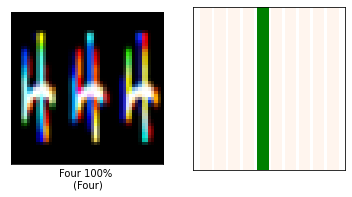

In [23]:
# Prediction of individual images taken from internet

# call the function

import random 
# defining parameters to pass to function
i=random.randrange(1, 10000) # image number 12. You may change value of i for play around
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
# we are passing "val_images_Original" just to show original image instead of "val_images" 
# which is preprocessed as VGG16 process and used for prediction.
plot_image(i,predictions, ytest, xtest) 
plt.subplot(1,2,2)
plot_value_array(i, predictions, ytest)
plt.show()

Classification of using Transfer Learning (VGG16)

Predicted, Percentage, (Original)



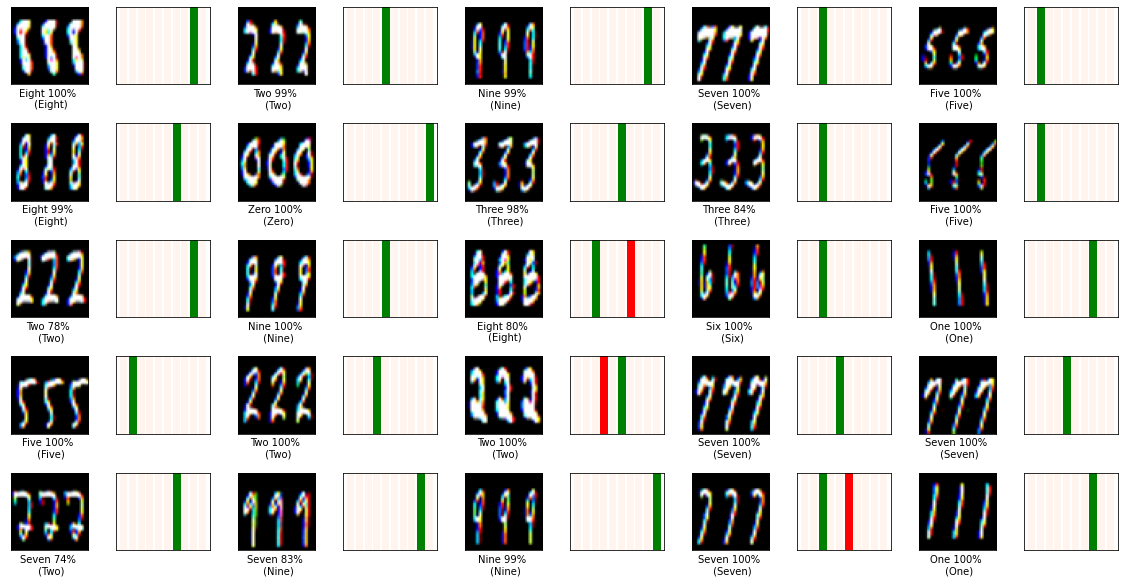

In [24]:
# Declaring variables
num_rows=5
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

print("Classification of using Transfer Learning (VGG16)\n")
print("Predicted, Percentage, (Original)\n")

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    ii=random.randrange(1,10000)
    # we are passing "val_images_Original" just to show original image instead of "val_images" 
    # which is preprocessed as VGG16 process and used for prediction.
    plot_image(ii,predictions, ytest, xtest)
    
    plt.subplot(num_rows, 2*num_cols, 2*i+2)

    plot_value_array(i, predictions, ytest)
plt.subplots_adjust(hspace=0.5)
plt.show()

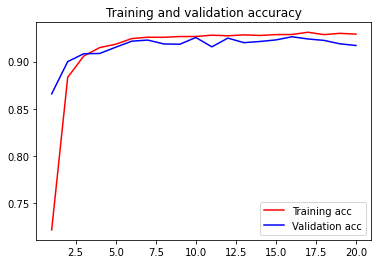

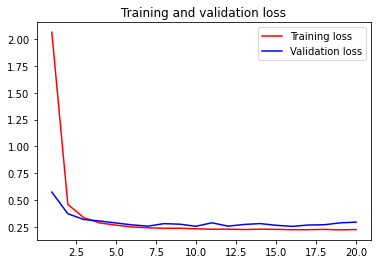

In [25]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()
